# Will it be an early Spring?

On February 2<sup>nd</sup> every year Punxsutawney Phil makes a prediction about if there will be an early Spring or if Winter will continue for 6 more weeks (till about mid-March). He is however not very accurate (well, according to [The Inner Circle](https://www.groundhog.org/inner-circle) he is 100% correct but the human handler may not interpret his response correctly). The overall goal is to be able to predict if it will be an early Spring.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled final model along with this notebook.

The group with the best results on the 10% of the data that I kept for myself will earn +5 extra credit (if multiple groups are close points may be given to multiple groups).

In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, make_scorer, precision_recall_curve, roc_curve, auc



Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.** <mark>The objective is to predict whether there will be an early Spring, allowing farmers to decide whether to purchase a new kind of corn seed that can grow two crops. Early Spring is defined as a period when the average temperature is above 40°F, the minimum temperature is above 32°F, and the average soil temperature is above 50°F before April 1st, with no snow on the ground.</mark>
2. **How will your solution be used?** <mark>The solution will be used by farmers in western PA to make informed decisions about purchasing seeds by February 25th. The prediction will help them determine if conditions will be favorable for planting the new corn seed early.</mark>
3. **What are the current solutions/workarounds (if any)?** <mark>Currently, farmers rely on Punxsutawney Phil's prediction, which is not very accurate. They may also use historical weather data and personal experience to make decisions.</mark>
4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?** <mark>This problem should be framed as a supervised learning problem, where the goal is to predict a binary outcome (early Spring or not) based on historical weather and soil data. This will be a classification model, using offline learning since the most important data involves winter and spring only.</mark>
5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Performance should be measured using accuracy, precision, recall, and F1-score. Since the preference is to avoid false negatives (missing an early Spring), recall might be particularly important.</mark>
6. **What would be the minimum performance needed to reach the business objective?** <mark>The minimum performance needed would be a recall rate that ensures farmers can confidently make purchasing decisions with minimal risk of missing an early Spring.</mark>
7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools from the MNIST in-class notebook to help with this model, especially with working with binary classifiers and a classification model. </mark>
8. **Is human expertise available?** <mark>Yes, human expertise is available from the farmers who have historical data and experience with weather patterns and planting conditions.</mark>
9. **How would you solve the problem manually?** <mark>I would solve this manually by focusing on the weather conditions, soil conditions, temperature of both weather and soil, whether or not there is snow cosverage within the land in Western PA. </mark>
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** <mark>We assume that almost all of these features will have decent relevance in predicting an early spring as all of the variables seem like reasonable predictors (UPDATE: that was not true. there were many variables that had 0 relevance as we found in our random forest classifier)</mark>

Get the Data
=======================================================================

1. **List the data you need and how much you need.** <mark>We need data to predict either an early spring, or late winter. To do that we need weather, soil, and a dataset which gives us a label feature like early spring. Also could use El Nino or La Nina data to predict this.</mark>
2. **Find and document where you can get that data:** <mark> We got the first 3 datasets from the cluent. From https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php we also got th El nino and La Nina data</mark>
3. **Get access authorizations:** <mark>Done</mark>
4. **Create a workspace (with enough storage space)**: This notebook.
5. **Get the data:** <mark>Got the data.</mark>
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** Done.
8. **Check the size and type of data (time series, geographical, …):** <mark>DONE</mark> - complete in the cells below
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** <mark>DONE</mark> - complete in the cells below

In [2]:
def load_data(weather_filename="weather.csv", soil_filename="soil.csv", phil_pred_filename="phil_pred.csv", early_spring_filename="early_spring.csv"):
    """
    Load all the data and join it together. The data will be pivoted so that the year is the row index.
    The years will be the same as the years in the data file.

    Notes:
      - You MUST provide this function
      - This function must have the same parameters
      - This function must return a dataframe with the years as the row index and only include the
        years that are in the data file provided
      - You can change the contents of this function, but will likely want to keep the parts I have
        provided
      - This function must do nothing BESIDES loading the data, pivoting, joining it, and selecting
        the proper year rows (no imputation, scaling, etc.)
    """

    # Load the basic data
    weather = pd.read_csv(weather_filename, parse_dates=[0], na_values=['M'], converters={
        "precipitation": convert_precipitation,
        "snowfall": convert_precipitation,
        "snowdepth": convert_depth
    })
    soil = pd.read_csv(soil_filename, parse_dates=[0])
    phil_pred = pd.read_csv(phil_pred_filename)
    early_spring = pd.read_csv(early_spring_filename)

    # Pivot and join basic data
    basic_data = (
        pivot(weather, 'date')
        .join(pivot(soil, 'day'))
        .join(phil_pred.set_index('year'))
        .join(early_spring.set_index('year'))
    )

    # Load additional data
    oni_data = pd.read_csv("ExtraDataONI.csv")
    oni_data = oni_data.set_index('year')

    # Join the basic data with the additional data
    data = basic_data.join(oni_data, how='inner')

    # Ensure years are the same
    years = basic_data.index  # the years in the basic data
    return data.loc[years]



def pivot(data, date_col, pivot_value='day_of_year'):
    """
    Pivot the data using the given date column. By default the pivot value is the day of the year
    but this can be changed to other values, such as the month or the week of the year.

    The returned data will have the year as the row index and a flattened column index.
    """
    data['year'] = data[date_col].dt.year
    data[pivot_value] = getattr(data[date_col].dt, pivot_value)
    data = data.drop(columns=[date_col]).pivot(index=['year'], columns=[pivot_value])
    data.columns = ["_".join(str(x) for x in a) for a in data.columns.to_flat_index()]  # from https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
    return data


def convert_precipitation(raw):
        return 0.0025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
def convert_depth(raw):
        return 0.025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)


class ImputerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.fillna(X.mean())

class WeeklyFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_prefixes):

        self.feature_prefixes = feature_prefixes
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Returns:
        DataFrame
            Transformed DataFrame with weekly features and original features dropped.
        """
        X = X.copy() 
        
        for prefix in self.feature_prefixes:
            # Select columns that match the prefix
            columns_to_sum = [col for col in X.columns if col.startswith(prefix)]
            if not columns_to_sum:
                continue
            
            # Check if there are enough columns to sum
            if len(columns_to_sum) < 7:
                raise ValueError(f"Not enough columns to sum for prefix '{prefix}'")
            
            # Sum every 7 columns and create new weekly features
            num_weeks = len(columns_to_sum) // 7
            for week in range(num_weeks):
                week_sum = X[columns_to_sum[week * 7:(week + 1) * 7]].sum(axis=1)
                X[f'{prefix}_week_{week + 1}'] = week_sum
            
            # Drop original columns
            X.drop(columns=columns_to_sum, inplace=True)
        
        return X

class WeeklyDeltaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_prefixes=None):
 
        if feature_prefixes is None:
            feature_prefixes = []
        self.feature_prefixes = feature_prefixes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """ 
        Create delta features for the selected columns.
        """

        # Create a DataFrame to hold the delta results
        delta_results = pd.DataFrame()

        for prefix in self.feature_prefixes:
            # Select columns based on the provided prefix
            cols = [col for col in X.columns if col.startswith(prefix)]

            # Calculate the delta for the selected columns
            deltas = X[cols].diff(axis=1).iloc[:, 1:]  # Skip the first week (no previous week to compare)

            # Rename columns to indicate they are deltas
            deltas.columns = [f'{prefix}delta_week_{i}' for i in range(1, len(deltas.columns) + 1)]

            # Concatenate deltas to the results DataFrame
            delta_results = pd.concat([delta_results, deltas], axis=1)

        # Drop the original weekly columns
        X_transformed = X.drop(columns=[col for prefix in self.feature_prefixes for col in X.columns if col.startswith(prefix)])

        # Combine the delta results with the original DataFrame
        X_transformed = pd.concat([X_transformed, delta_results], axis=1)

        return X_transformed

In [3]:
# read csv file

data = load_data(weather_filename="weather.csv", soil_filename="soil.csv", phil_pred_filename="phil_pred.csv", early_spring_filename="early_spring.csv")

In [4]:
data.shape

(70, 686)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 1947 to 2024
Columns: 686 entries, max_temp_1 to NDJ
dtypes: bool(2), float64(684)
memory usage: 374.7 KB


In [6]:
data.describe()

max_temp_1  max_temp_2  max_temp_3  max_temp_4  max_temp_5  max_temp_6  \
count   70.000000   69.000000   69.000000   70.000000   70.000000   69.000000   
mean    39.271429   39.057971   38.797101   38.428571   37.271429   36.521739   
std     11.266111   10.181997   10.821520   13.200320   12.274542   10.325025   
min     12.000000   12.000000   13.000000    9.000000   11.000000    8.000000   
25%     33.000000   32.000000   32.000000   30.250000   31.000000   29.000000   
50%     38.000000   38.000000   38.000000   36.500000   38.000000   35.000000   
75%     44.750000   46.000000   46.000000   48.500000   43.750000   42.000000   
max     70.000000   64.000000   64.000000   71.000000   66.000000   60.000000   

       max_temp_7  max_temp_8  max_temp_9  max_temp_10  ...        FMA  \
count   68.000000   70.000000   69.000000    70.000000  ...  66.000000   
mean    35.985294   34.842857   35.811594    35.428571  ...  -0.030303   
std     10.715441   12.849898   12.019929    11.889066  ...   0.694366   
min      8.000000    2.000000   12.000000     8.000000  ...  -1.300000   
25%     30.000000   25.250000   25.000000    27.000000  ...  -0.600000   
50%     35.000000   34.000000   36.000000    36.000000  ...   0.050000   
75%     41.000000   41.000000   44.000000    44.000000  ...   0.375000   
max     64.000000   69.000000   67.000000    59.000000  ...   1.600000   

             MAM        AMJ        MJJ        JJA        JAS        ASO  \
count  66.000000  66.000000  66.000000  66.000000  66.000000  66.000000   
mean   -0.030303  -0.036364  -0.033333  -0.033333  -0.037879  -0.046970   
std     0.587555   0.559020   0.571996   0.631807   0.721487   0.852728   
min    -1.200000  -1.100000  -1.300000  -1.300000  -1.300000  -1.600000   
25%    -0.400000  -0.500000  -0.400000  -0.500000  -0.500000  -0.675000   
50%     0.000000   0.000000   0.000000  -0.050000  -0.100000  -0.150000   
75%     0.300000   0.400000   0.375000   0.375000   0.400000   0.475000   
max     1.300000   1.100000   1.200000   1.600000   1.900000   2.200000   

             SON        OND        NDJ  
count  66.000000  66.000000  66.000000  
mean   -0.043939  -0.056061  -0.057576  
std     0.970983   1.084312   1.110933  
min    -1.700000  -1.900000  -2.000000  
25%    -0.775000  -0.875000  -0.875000  
50%    -0.200000  -0.200000  -0.200000  
75%     0.650000   0.700000   0.775000  
max     2.400000   2.600000   2.600000  

[8 rows x 684 columns]

In [7]:
data.head()

max_temp_1  max_temp_2  max_temp_3  max_temp_4  max_temp_5  max_temp_6  \
year                                                                           
1947        30.0        44.0        54.0        42.0        33.0        33.0   
1948        46.0        41.0        32.0        34.0        34.0        32.0   
1949        31.0        34.0        40.0        43.0        55.0        54.0   
1950        49.0        53.0        61.0        69.0        54.0        53.0   
1951        40.0        46.0        52.0        50.0        41.0        46.0   

      max_temp_7  max_temp_8  max_temp_9  max_temp_10  ...  FMA  MAM  AMJ  \
year                                                   ...                  
1947        34.0        35.0        31.0         30.0  ...  NaN  NaN  NaN   
1948        32.0        41.0        49.0         33.0  ...  NaN  NaN  NaN   
1949        49.0        56.0        61.0         53.0  ...  NaN  NaN  NaN   
1950        43.0        30.0        48.0         59.0  ...  NaN  NaN  NaN   
1951        36.0        23.0        30.0         46.0  ... -1.2 -1.2 -1.1   

      MJJ  JJA  JAS  ASO  SON  OND  NDJ  
year                                     
1947  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1948  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1949  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1950  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1951 -0.9 -0.5 -0.4 -0.4 -0.4 -0.6 -0.8  

[5 rows x 686 columns]

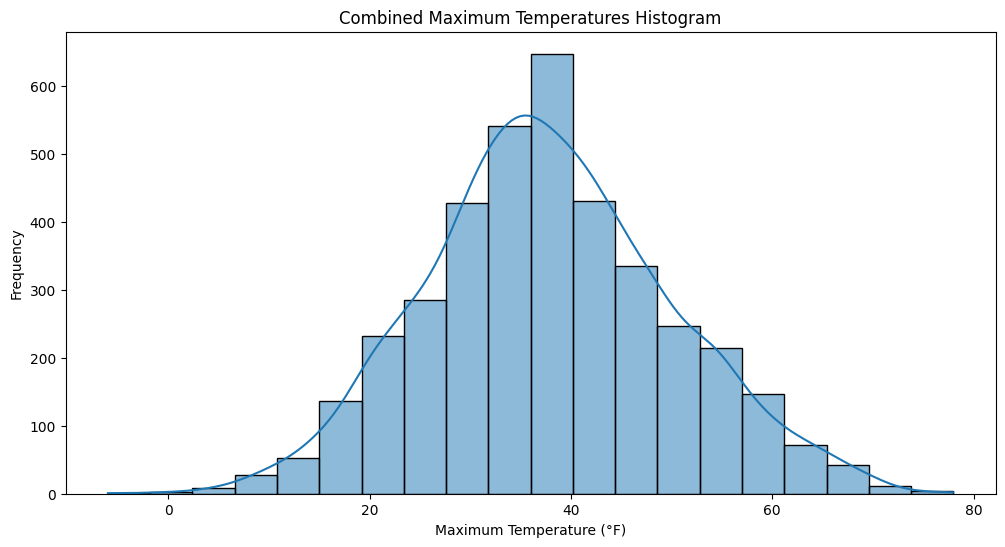

In [8]:
max_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_temp' in col], 
                           var_name='Temperature_Type', value_name='Max_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_temp_values['Max_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Maximum Temperatures Histogram')
plt.xlabel('Maximum Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

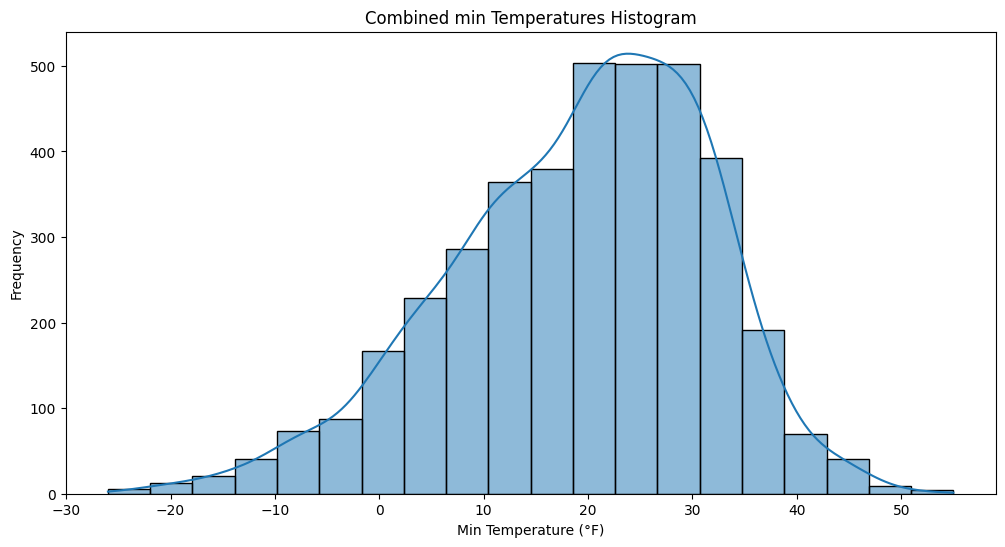

In [9]:
min_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_temp' in col], 
                           var_name='Temperature_Type', value_name='Min_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_temp_values['Min_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined min Temperatures Histogram')
plt.xlabel('Min Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

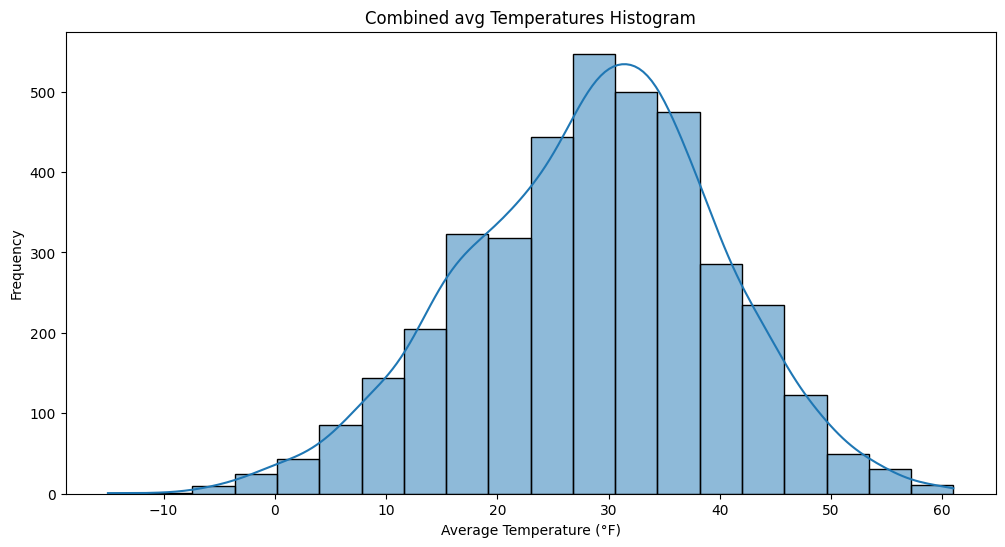

In [10]:
avg_temp_values = pd.melt(data, value_vars=[col for col in data if 'avg_temp' in col], 
                           var_name='Temperature_Type', value_name='Avg_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(avg_temp_values['Avg_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined avg Temperatures Histogram')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

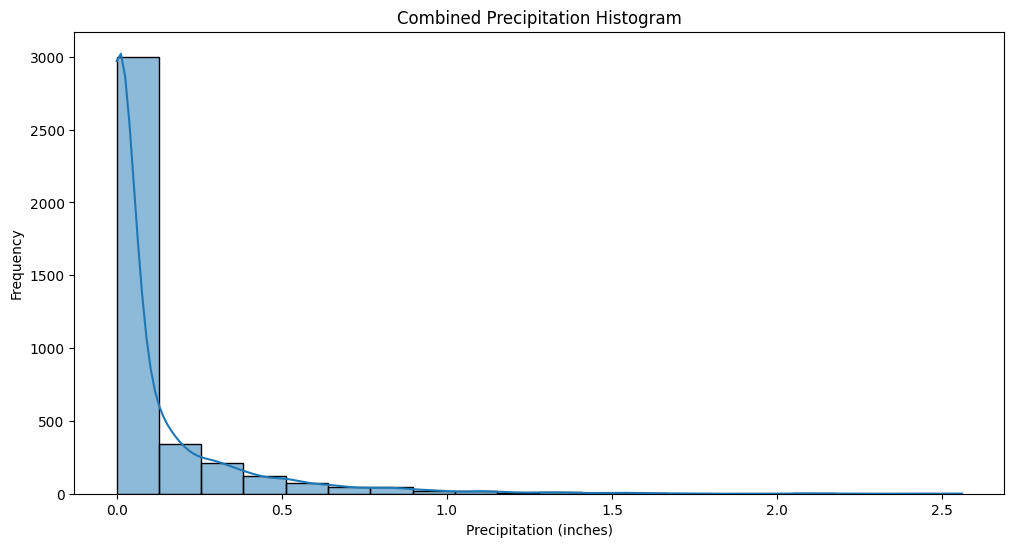

In [11]:
precipitation_values = pd.melt(data, value_vars=[col for col in data if 'precipitation' in col],
                                 var_name='Precipitation_Type', value_name='Precipitation')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(precipitation_values['Precipitation'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Precipitation Histogram')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

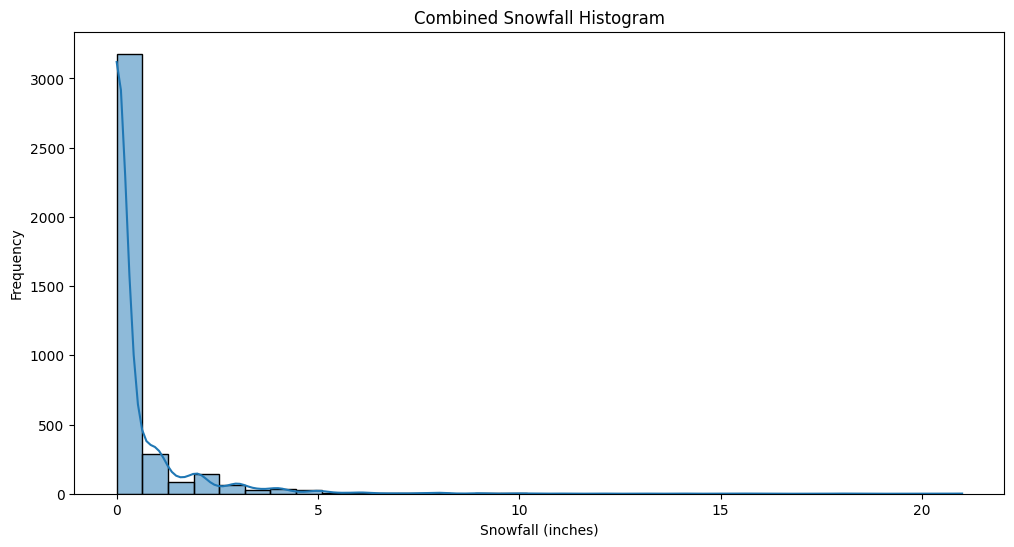

In [12]:
snowfall_values = pd.melt(data, value_vars=[col for col in data if 'snowfall' in col],
                                    var_name='Snowfall_Type', value_name='Snowfall')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(snowfall_values['Snowfall'], bins=33, kde=True)

# Add labels and title
plt.title('Combined Snowfall Histogram')
plt.xlabel('Snowfall (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

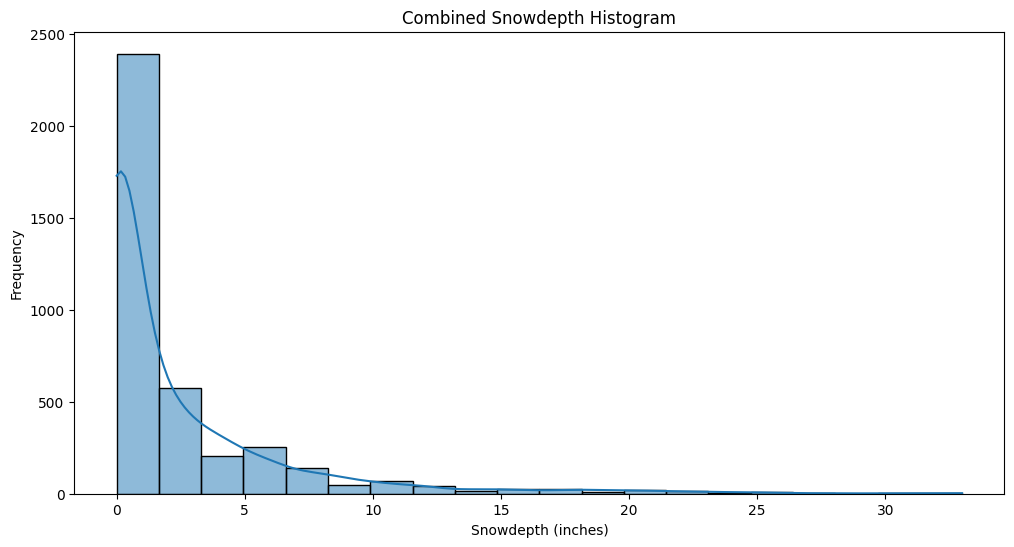

In [13]:
snowdepth_values = pd.melt(data, value_vars=[col for col in data if 'snowdepth' in col],
                                    var_name='Snowdepth_Type', value_name='Snowdepth')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(snowdepth_values['Snowdepth'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Snowdepth Histogram')
plt.xlabel('Snowdepth (inches)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

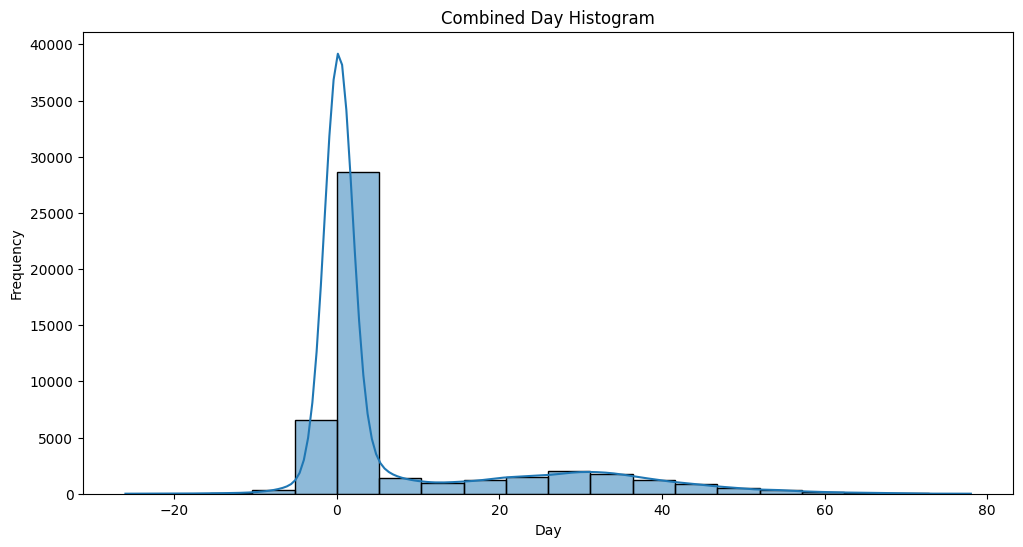

In [14]:
day_values = pd.melt(data, value_vars=[col for col in data if 'day' in col],
                                    var_name='Day_Type', value_name='Day')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(day_values['Day'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Day Histogram')
plt.xlabel('Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

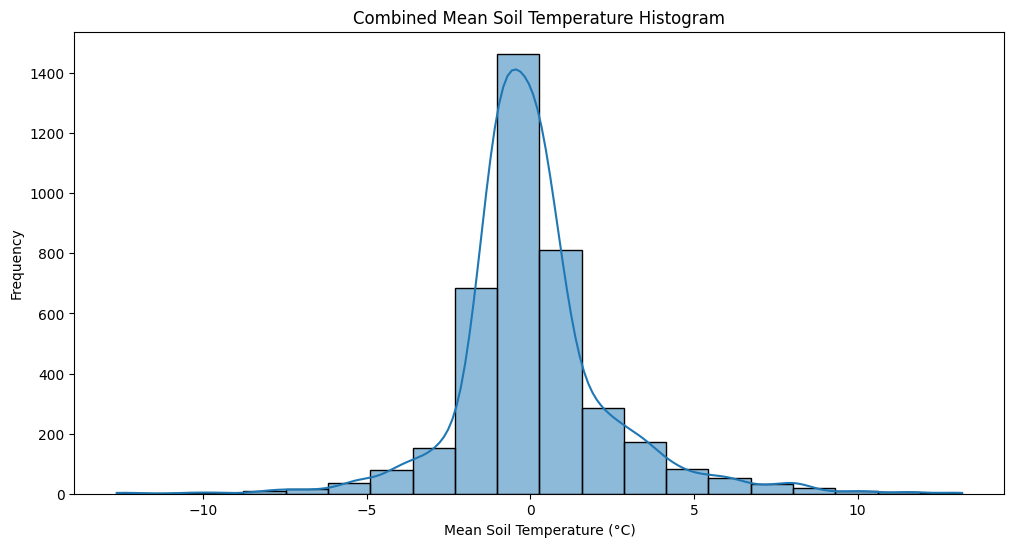

In [15]:
mean_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_temp' in col],
                                    var_name='Mean_Soil_Temperature_Type', value_name='Mean_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(mean_soil_temp_values['Mean_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Mean Soil Temperature Histogram')
plt.xlabel('Mean Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

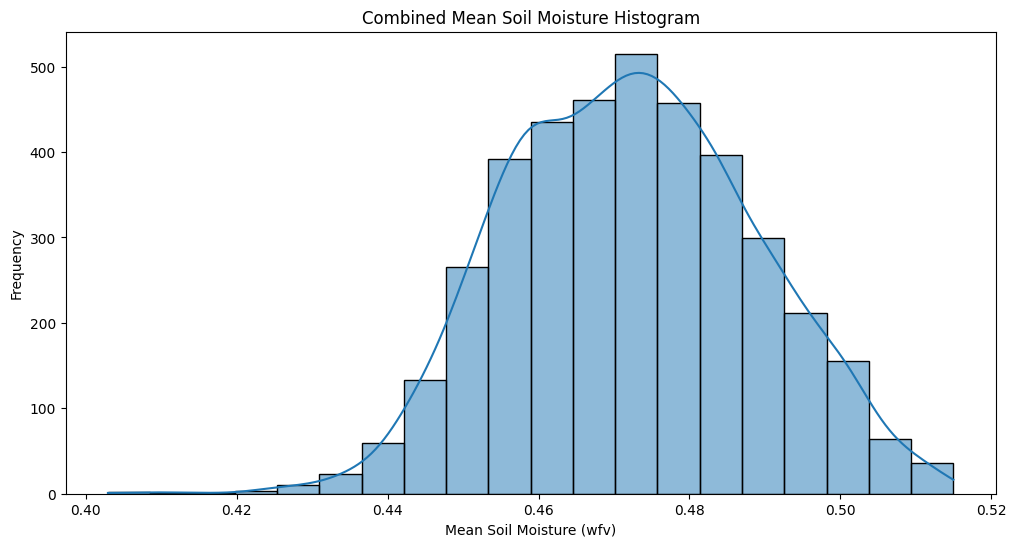

In [16]:
mean_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'mean_soil_moisture' in col],
                                    var_name='Mean_Soil_Moisture_Type', value_name='Mean_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(mean_soil_moisture_values['Mean_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Mean Soil Moisture Histogram')
plt.xlabel('Mean Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

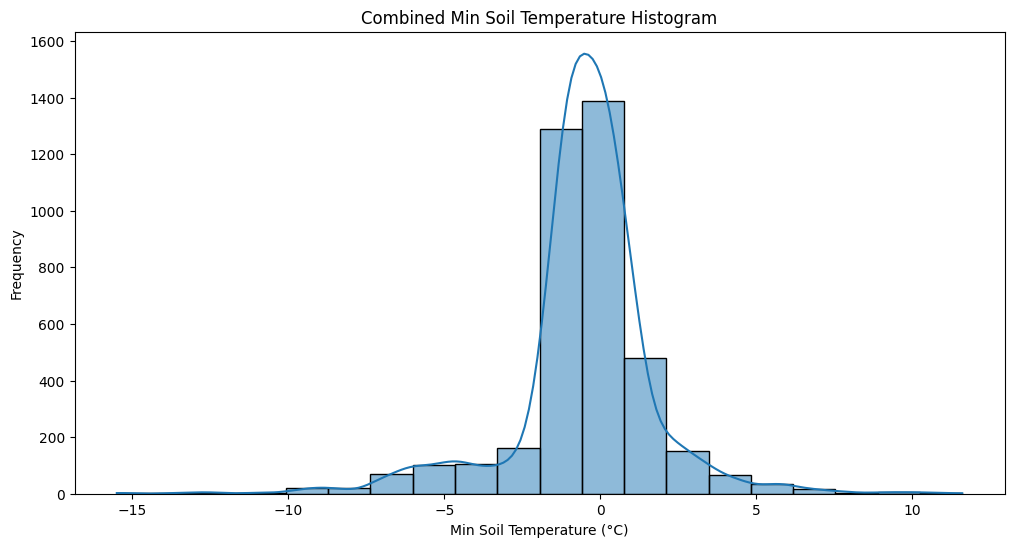

In [17]:
min_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_temp' in col],
                                    var_name='Min_Soil_Temperature_Type', value_name='Min_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_soil_temp_values['Min_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Min Soil Temperature Histogram')
plt.xlabel('Min Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

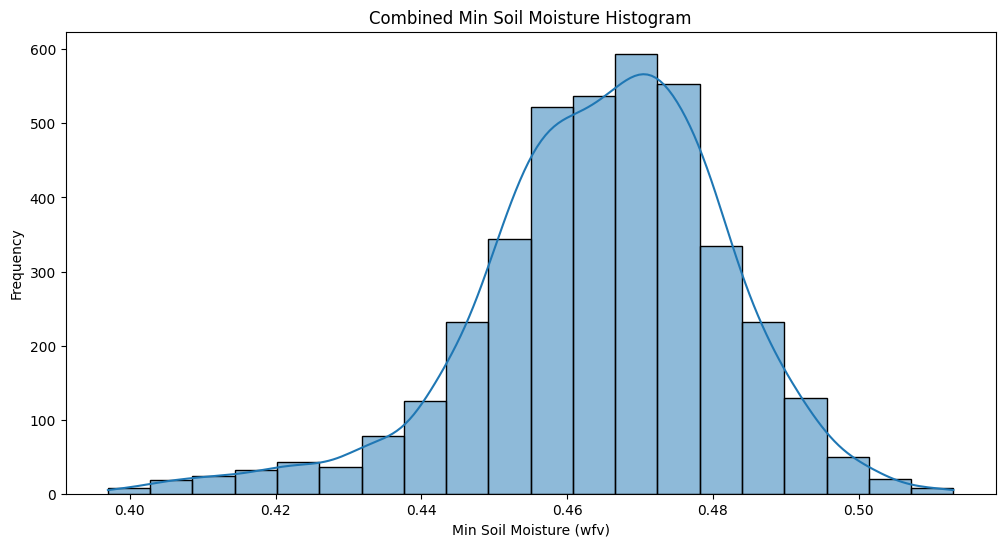

In [18]:
min_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'min_soil_moisture' in col],
                                    var_name='Min_Soil_Moisture_Type', value_name='Min_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(min_soil_moisture_values['Min_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Min Soil Moisture Histogram')
plt.xlabel('Min Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


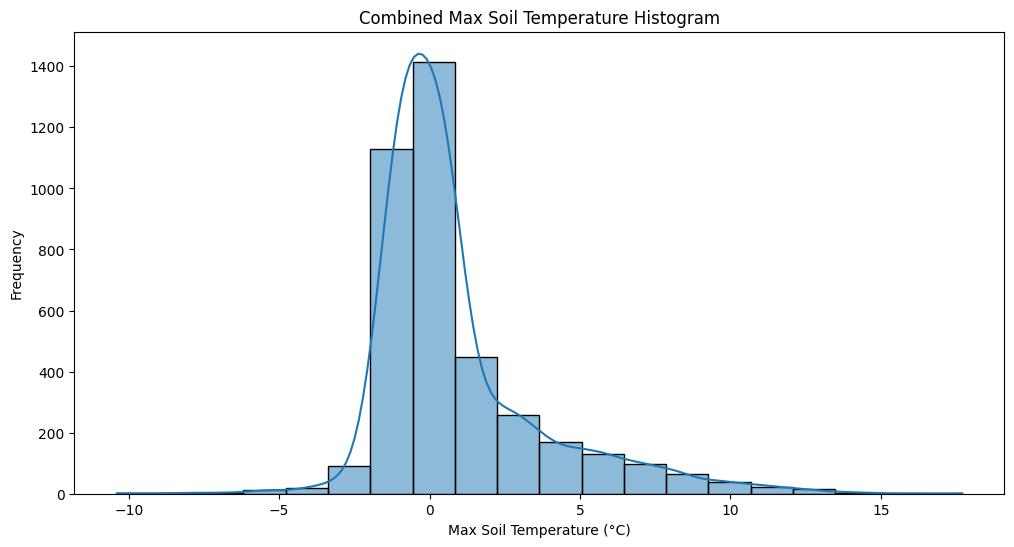

In [19]:
max_soil_temp_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_temp' in col],
                                    var_name='Max_Soil_Temperature_Type', value_name='Max_Soil_Temperature')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_soil_temp_values['Max_Soil_Temperature'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Max Soil Temperature Histogram')
plt.xlabel('Max Soil Temperature (°C)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


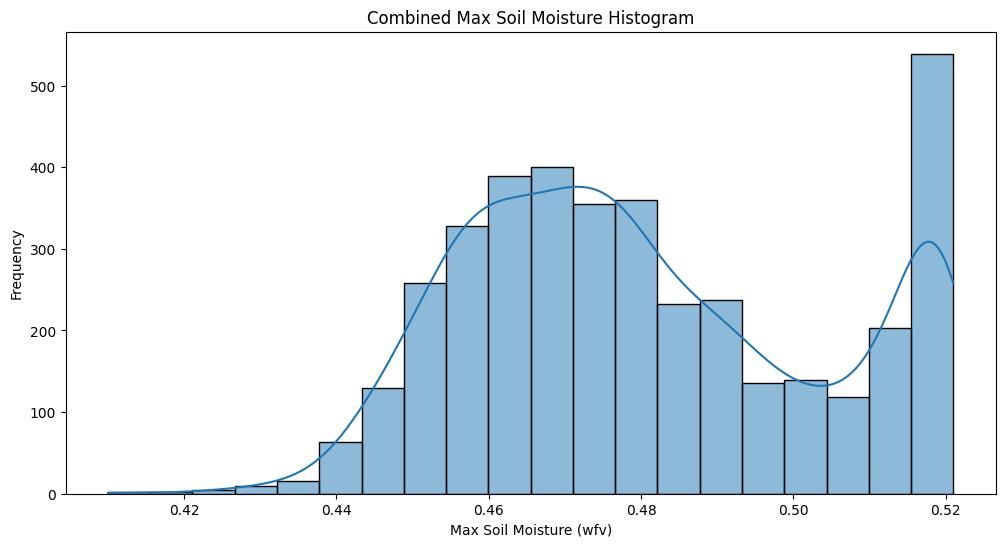

In [20]:
max_soil_moisture_values = pd.melt(data, value_vars=[col for col in data if 'max_soil_moisture' in col],
                                    var_name='Max_Soil_Moisture_Type', value_name='Max_Soil_Moisture')

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(max_soil_moisture_values['Max_Soil_Moisture'], bins=20, kde=True)

# Add labels and title
plt.title('Combined Max Soil Moisture Histogram')
plt.xlabel('Max Soil Moisture (wfv)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

<Axes: xlabel='DJF', ylabel='Count'>

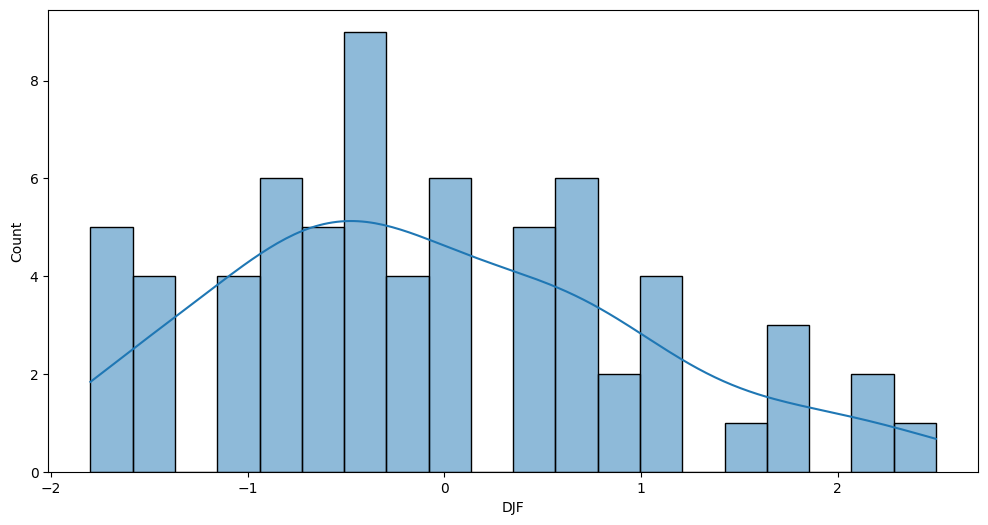

In [21]:
#plot DJF variable in data

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['DJF'], bins=20, kde=True)

<Axes: xlabel='JFM', ylabel='Count'>

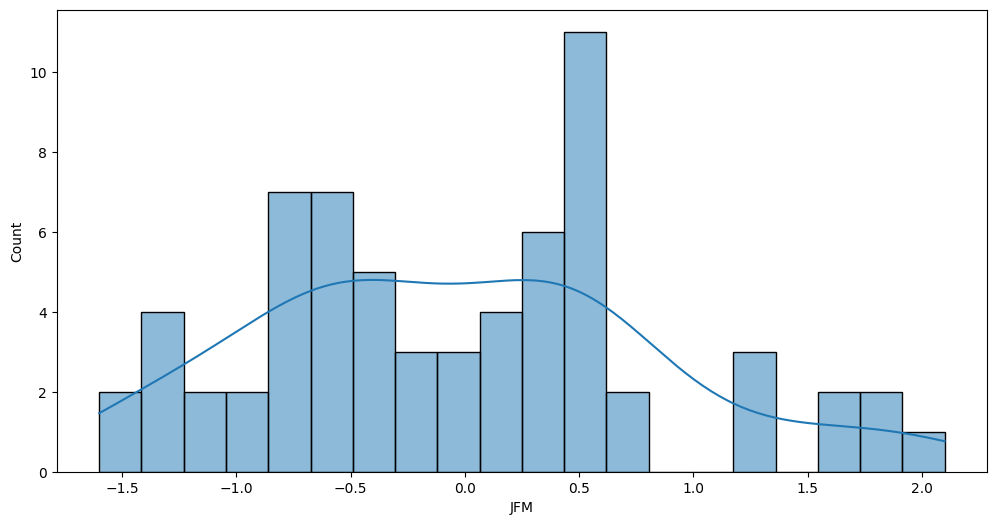

In [22]:
#plot JFM
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['JFM'], bins=20, kde=True)

<Axes: xlabel='FMA', ylabel='Count'>

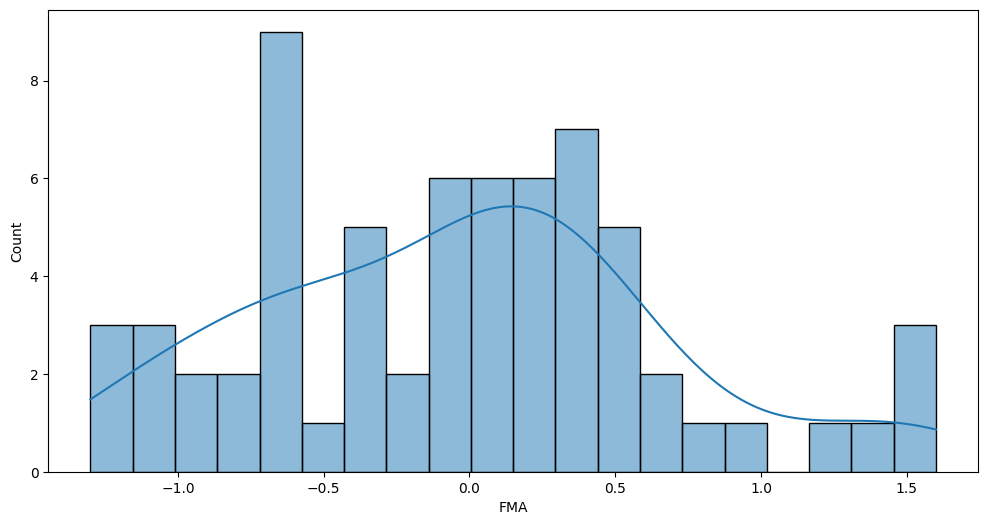

In [23]:
#plot FMA

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['FMA'], bins=20, kde=True)

<Axes: xlabel='MAM', ylabel='Count'>

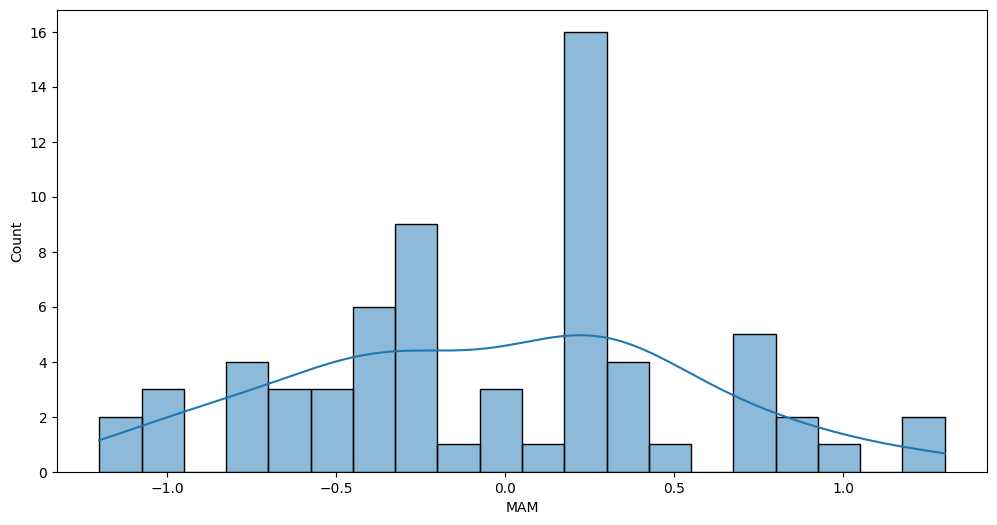

In [24]:
#plot MAM

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['MAM'], bins=20, kde=True)

<Axes: xlabel='AMJ', ylabel='Count'>

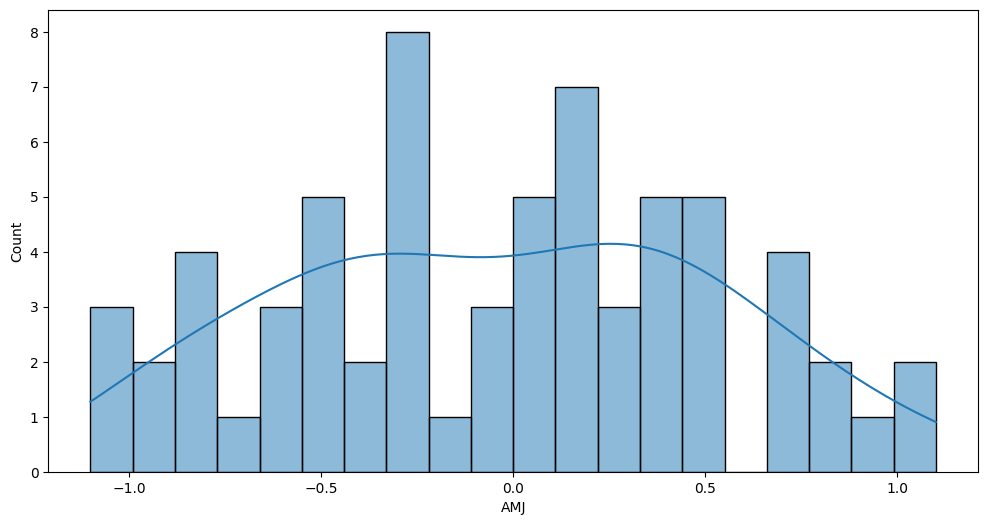

In [25]:
#plot AMJ

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['AMJ'], bins=20, kde=True)

<Axes: xlabel='MJJ', ylabel='Count'>

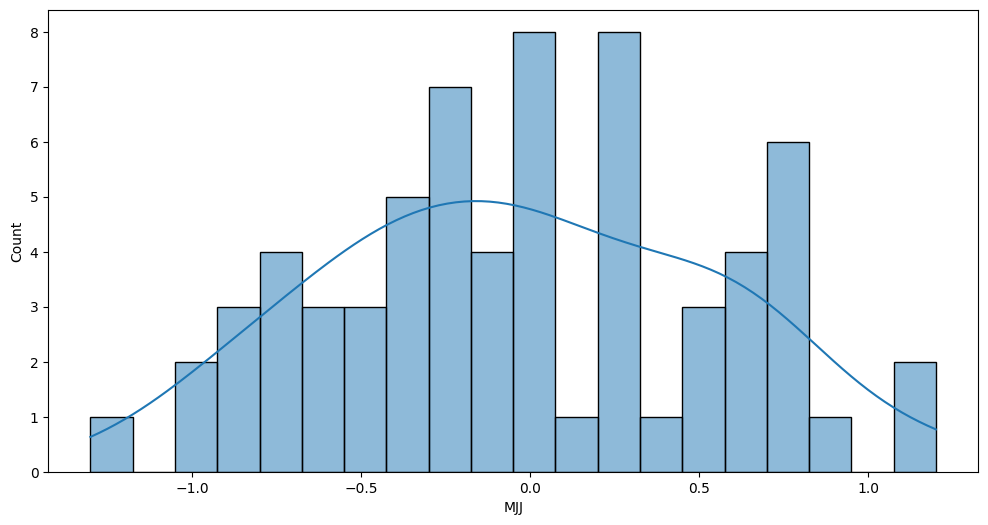

In [26]:
#plot MJJ

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['MJJ'], bins=20, kde=True)

<Axes: xlabel='JJA', ylabel='Count'>

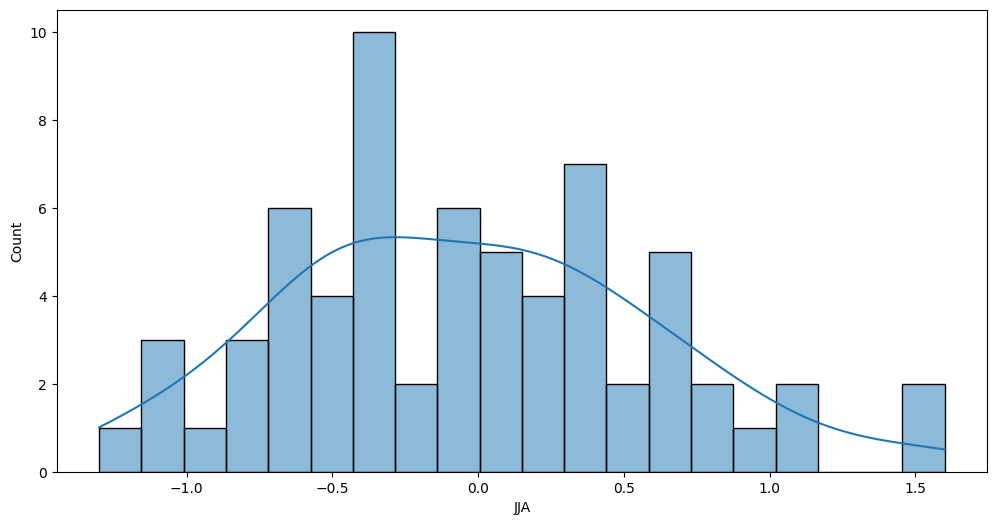

In [27]:
#plot JJA

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(data['JJA'], bins=20, kde=True)

<Axes: xlabel='JAS', ylabel='Count'>

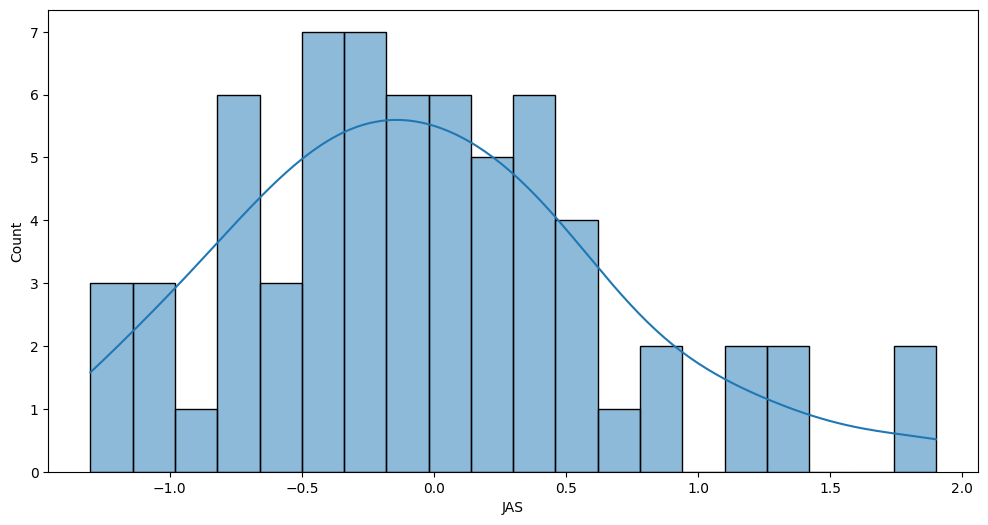

In [28]:
#plot JAS

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['JAS'], bins=20, kde=True)

<Axes: xlabel='ASO', ylabel='Count'>

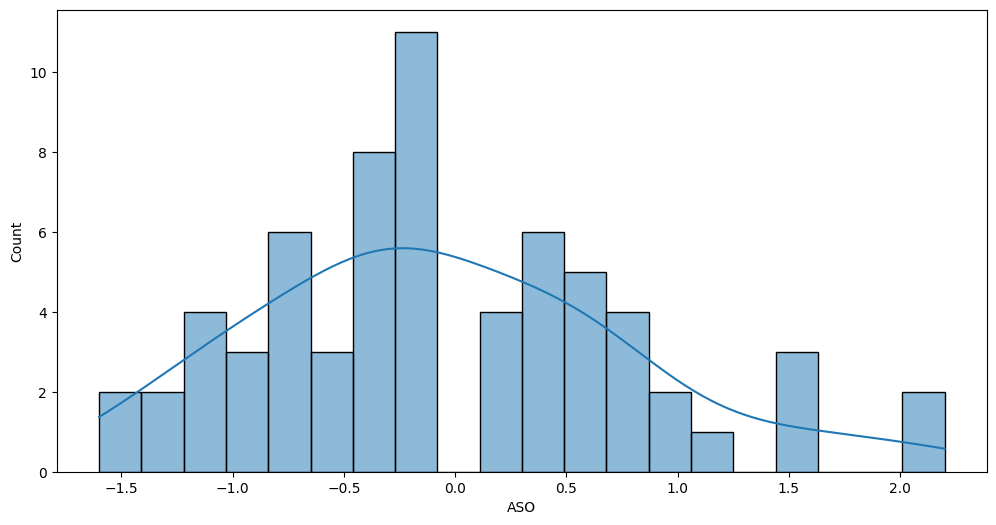

In [29]:
#plot ASO

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['ASO'], bins=20, kde=True)

<Axes: xlabel='SON', ylabel='Count'>

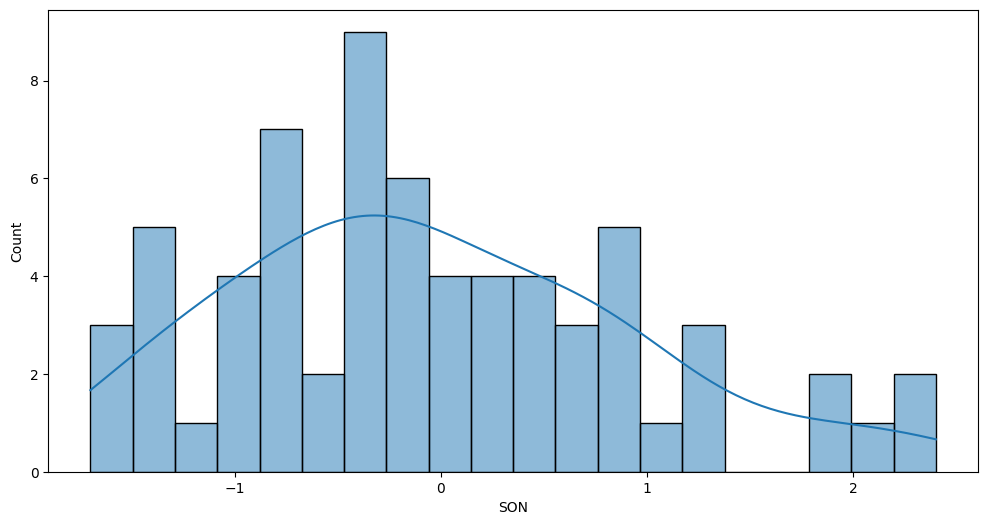

In [30]:
#plot SON

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['SON'], bins=20, kde=True)

<Axes: xlabel='OND', ylabel='Count'>

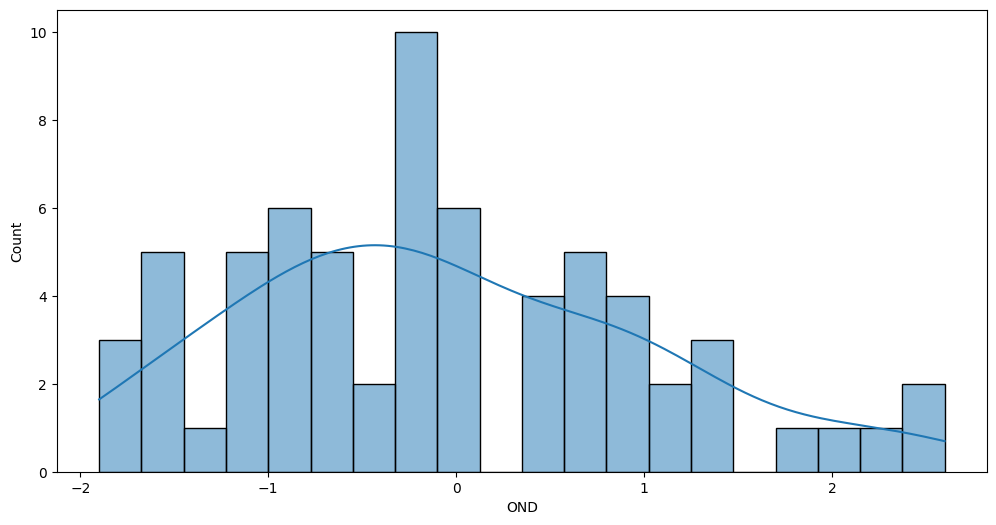

In [31]:
#plot OND

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['OND'], bins=20, kde=True)

<Axes: xlabel='NDJ', ylabel='Count'>

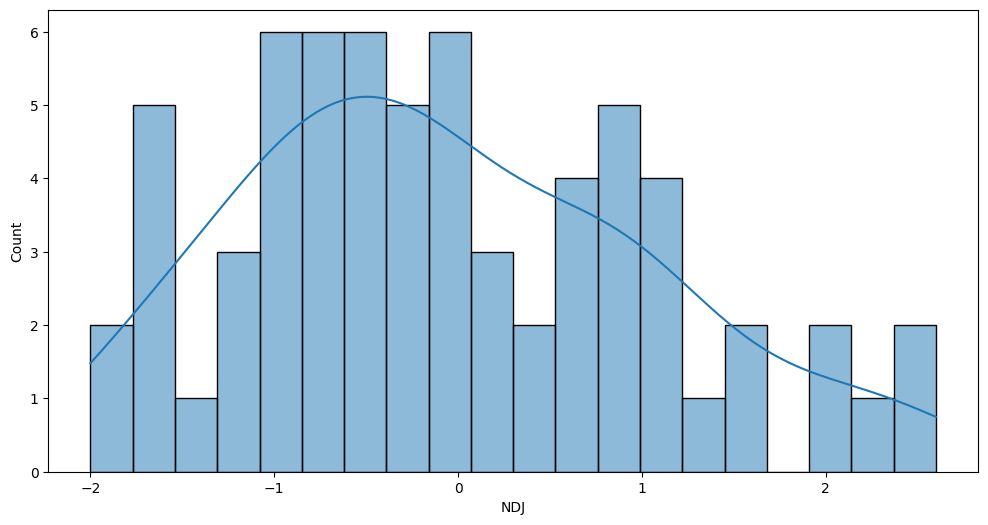

In [32]:
#plot NDJ

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['NDJ'], bins=20, kde=True)

<Axes: xlabel='early_spring', ylabel='Count'>

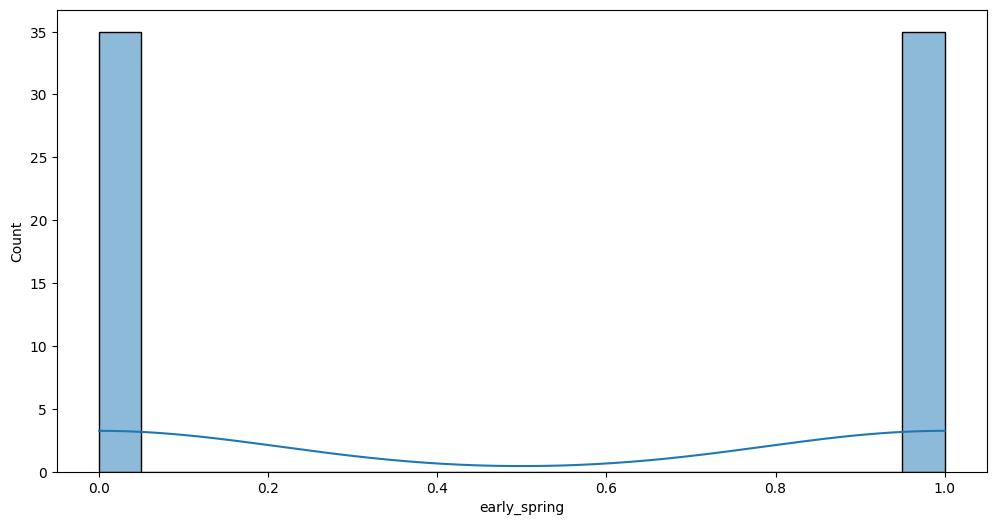

In [33]:
#early_spring

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(data['early_spring'], bins=20, kde=True)

In [34]:
#drop any column with day in it
data = data.drop(columns=[col for col in data if 'day' in col])

In [35]:
data['early_spring'].value_counts()


early_spring
False    35
True     35
Name: count, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split



# Perform the train-test split, stratifying by the combined variable
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='early_spring'), data['early_spring'], test_size=0.2, random_state=42, stratify=data['early_spring'])

## Get the Data Notes

- Took 20% for test set because of small data size. That allows us to get more of our data to train.

Things I'm interested in for data visualizaion
- Do different days have more or less of an effect on whether its an early spring or not?
- Are there patterns of days that do not matter in predicting an early spring at all
- What seem to be the most important features?

# Explore the Data

In [37]:
X_train.drop(columns='prediction', inplace=True)

In [38]:
y_train.value_counts()

early_spring
False    28
True     28
Name: count, dtype: int64

In [39]:
#combine x train and y train
train = X_train.copy()
train['early_spring'] = y_train

<Axes: xlabel='max_temp_1', ylabel='Count'>

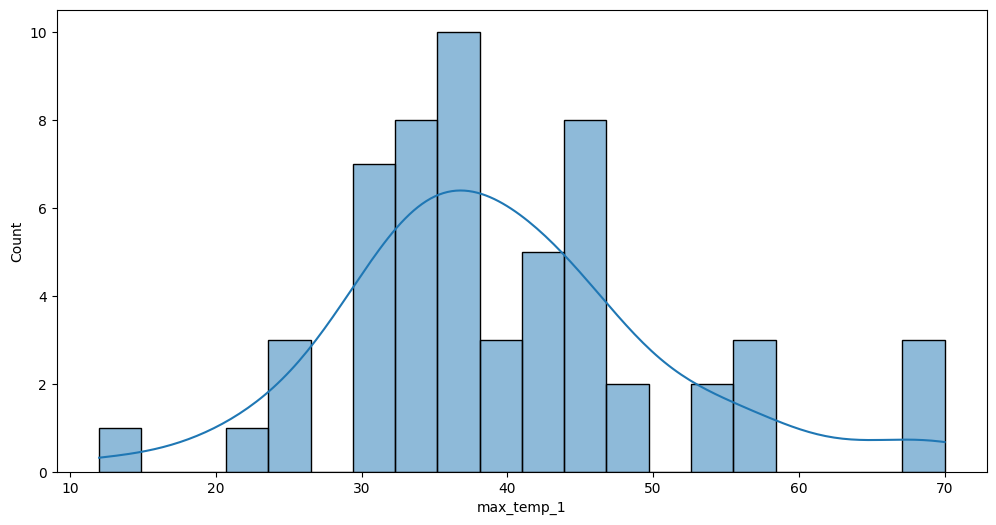

In [40]:
#histogram of max temp on jan 1st

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['max_temp_1'], bins=20, kde=True)

<Axes: xlabel='max_temp_32', ylabel='Count'>

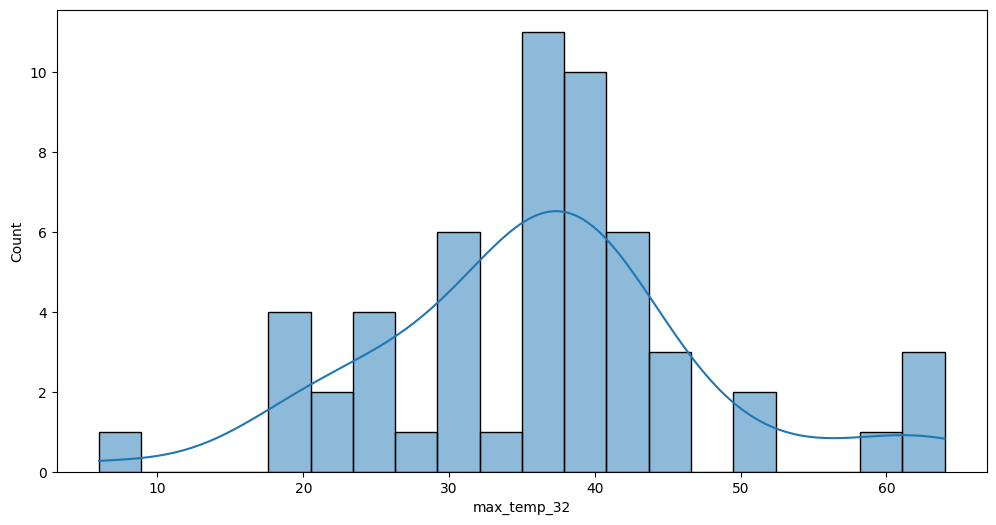

In [41]:
#histogram of max temp on feb 1st

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['max_temp_32'], bins=20, kde=True)

<Axes: xlabel='max_temp_56', ylabel='Count'>

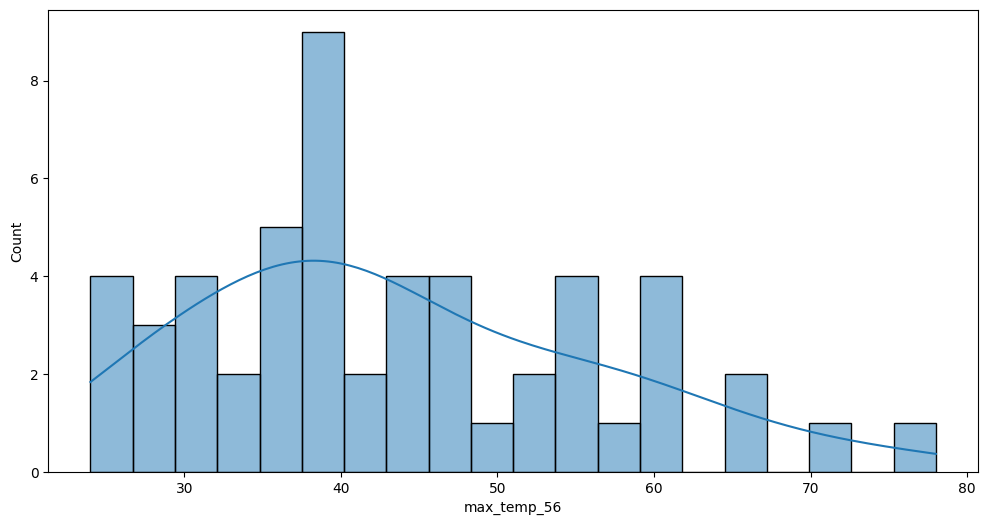

In [42]:
#histogram of max temp on feb 25th

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['max_temp_56'], bins=20, kde=True)

<Axes: xlabel='precipitation_1', ylabel='Count'>

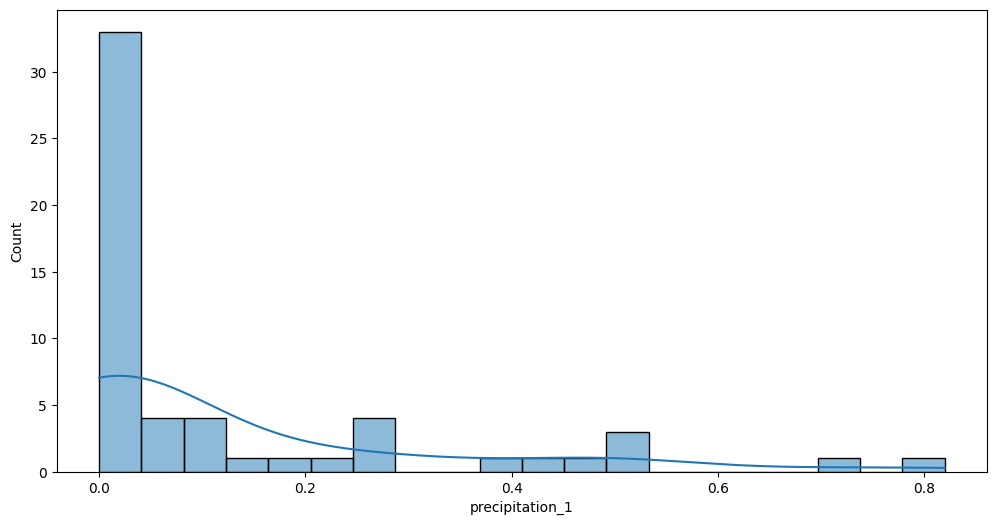

In [43]:
#histogram of precipitation jan 1

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['precipitation_1'], bins=20, kde=True)

In [44]:
#log all precipitation values and add them to the train data

train['log_precipitation_1'] = np.log1p(train['precipitation_1'])


<Axes: xlabel='log_precipitation_1', ylabel='Count'>

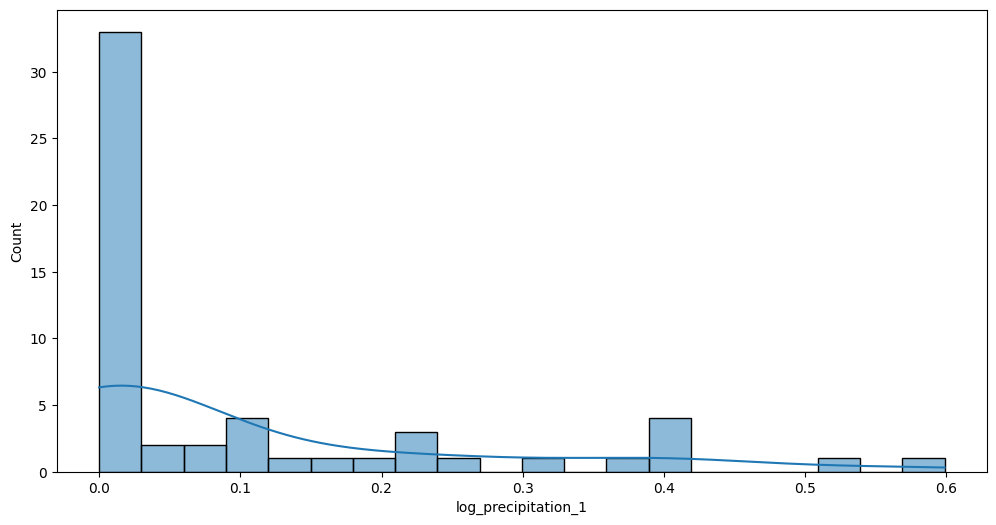

In [45]:
#histogram of log precipitation 1

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['log_precipitation_1'], bins=20, kde=True)

<Axes: >

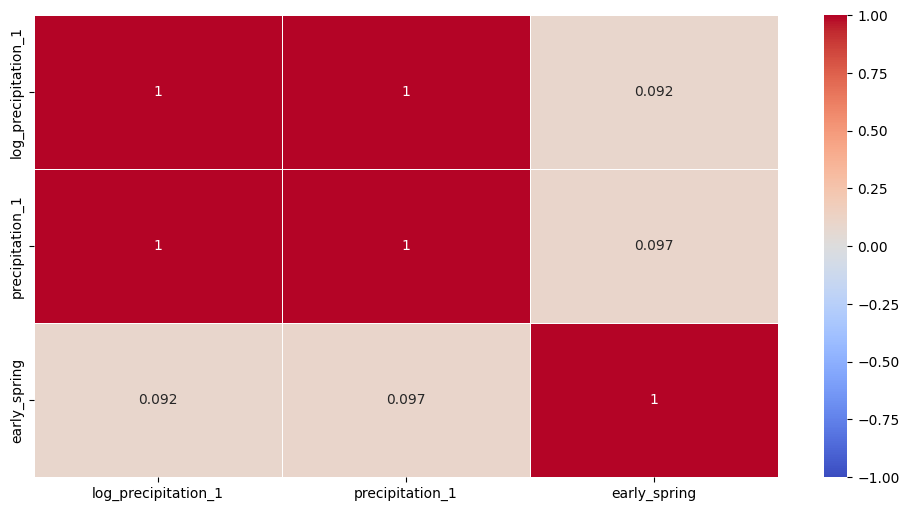

In [46]:
# see correlation between log precipitation 1, precipitation 1 and early spring

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# create corr matrix

corr_matrix = train[['log_precipitation_1', 'precipitation_1', 'early_spring']]

# Create the heatmap
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

Interestingly Precipitation_1 has more correlation than log_precipitation_1 despite looking log normal in our earlier analysis.

Same for all Precipitation days

<Axes: xlabel='snowdepth_1', ylabel='Count'>

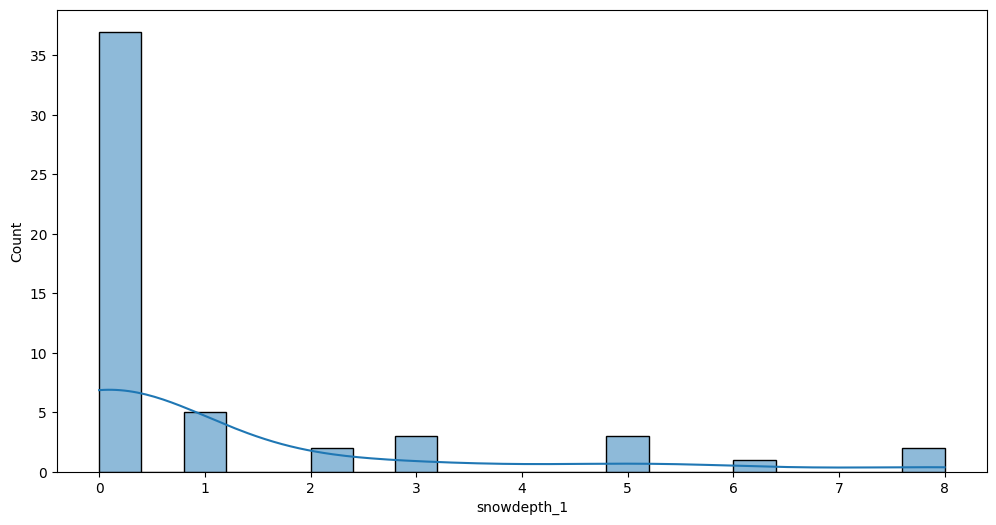

In [47]:
# hist of snowdepth on jan 1st

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['snowdepth_1'], bins=20, kde=True)



In [48]:
# create log snowdepth 1

# log snowdepth 1 and add it to train data
train['log_snowdepth_1'] = np.log1p(train['snowdepth_1'])


<Axes: xlabel='log_snowdepth_1', ylabel='Count'>

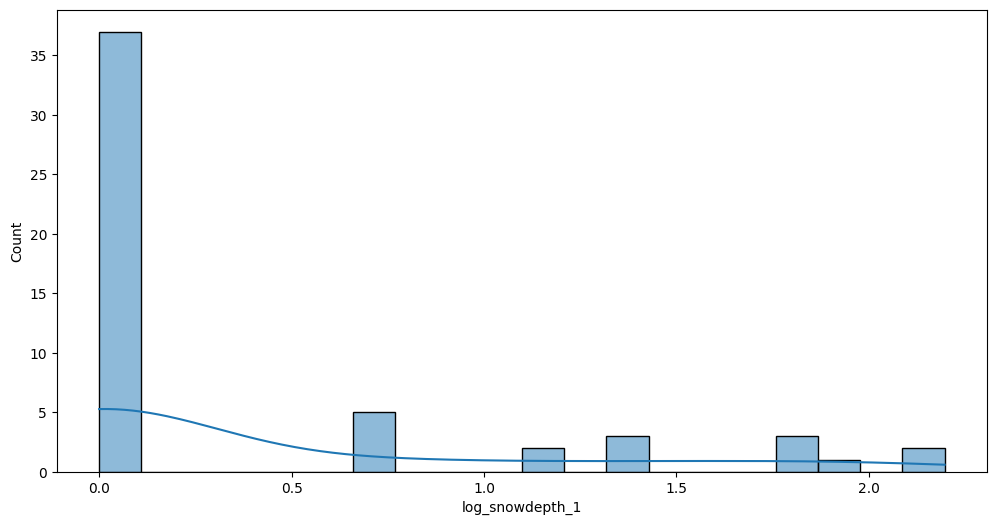

In [49]:
# hist of log snowdepth 1

# Set the figure size for better readability

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['log_snowdepth_1'], bins=20, kde=True)


<Axes: >

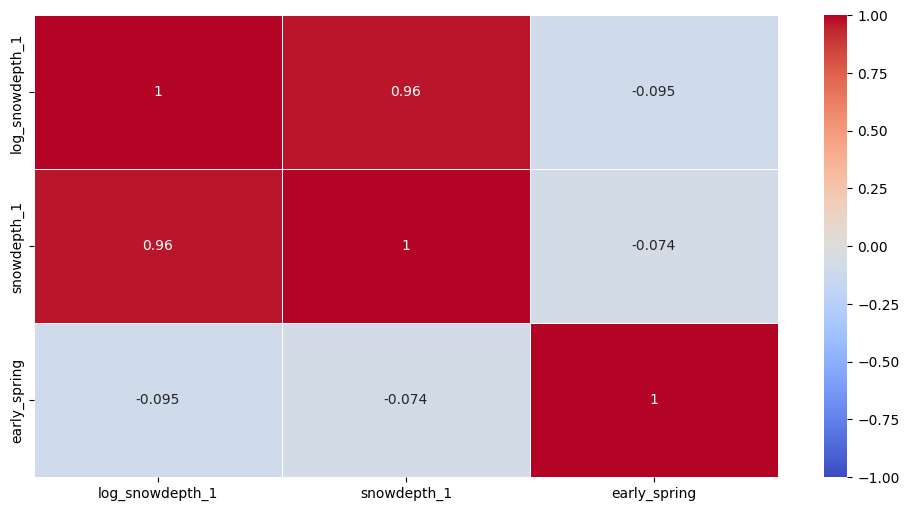

In [50]:
# corr matrix of log snowdepth 1, snowdepth 1 and early spring

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# create corr matrix
corr_matrix = train[['log_snowdepth_1', 'snowdepth_1', 'early_spring']]

# Create the heatmap
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

Yooooooo I see some changes. Will now try logging all of snow depth

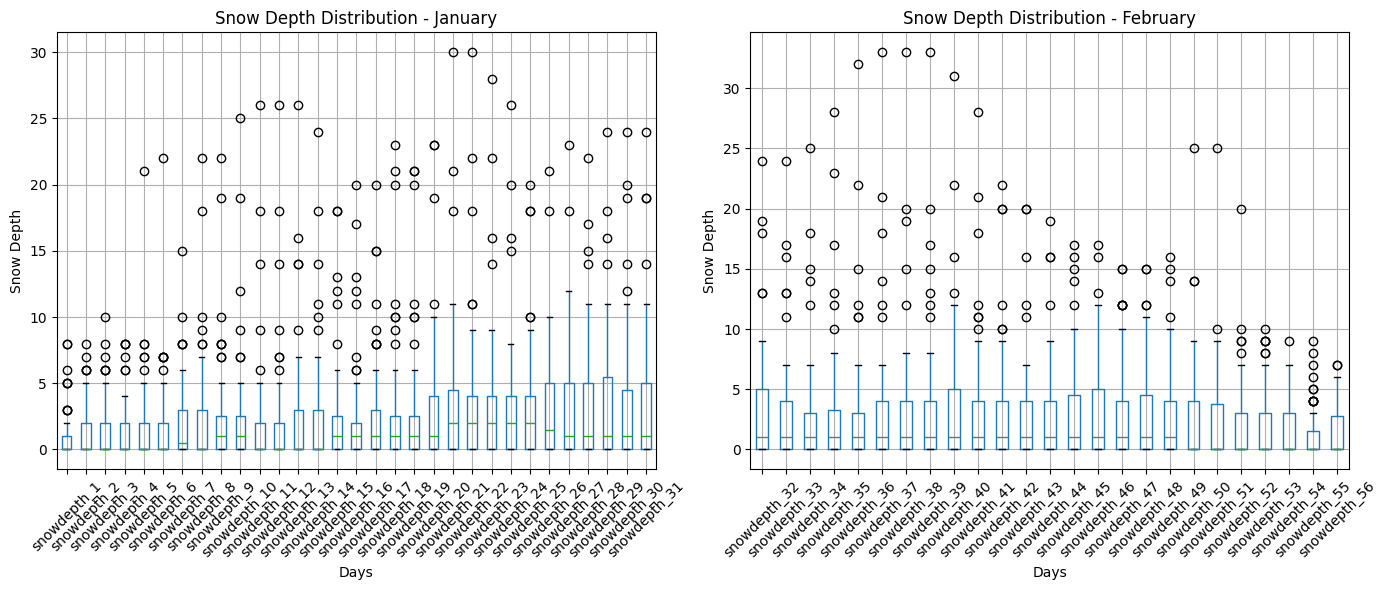

In [51]:
snow_depth_cols = [f'snowdepth_{i}' for i in range(1, 57)]
snow_depth_df = train[snow_depth_cols]

january_depths = snow_depth_df.iloc[:, 0:31]  # Days 1-31
february_depths = snow_depth_df.iloc[:, 31:56]  # Days 32-56


# Box plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
january_depths.boxplot()
plt.title('Snow Depth Distribution - January')
plt.xlabel('Days')
plt.ylabel('Snow Depth')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
february_depths.boxplot()
plt.title('Snow Depth Distribution - February')
plt.xlabel('Days')
plt.ylabel('Snow Depth')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Very interesting. It looks as if we get less snow during the first days of janurary and the end of Februrary

<Axes: >

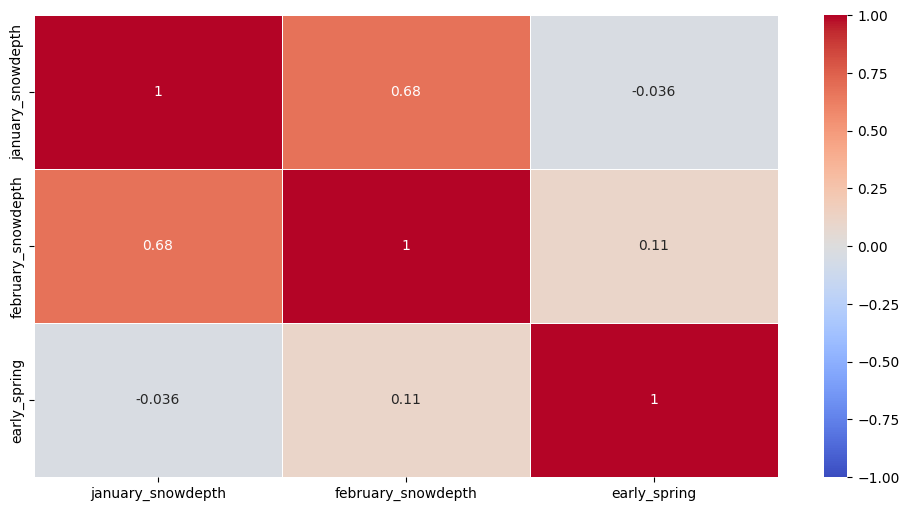

In [52]:
# corr matrix of combined jan snowdepths, and combined feb snowdepths, and early spring

#add snowdepth columns to combined data
train[snow_depth_cols] = train[snow_depth_cols]

#combine first 31 days of snowdepth and last 25 days of snowdepth

train['january_snowdepth'] = train[snow_depth_cols[:31]].sum(axis=1)
train['february_snowdepth'] = train[snow_depth_cols[31:56]].sum(axis=1)


# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# create corr matrix

corr_matrix = train[['january_snowdepth', 'february_snowdepth', 'early_spring']]

# Create the heatmap
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

<Axes: xlabel='january_snowdepth', ylabel='Count'>

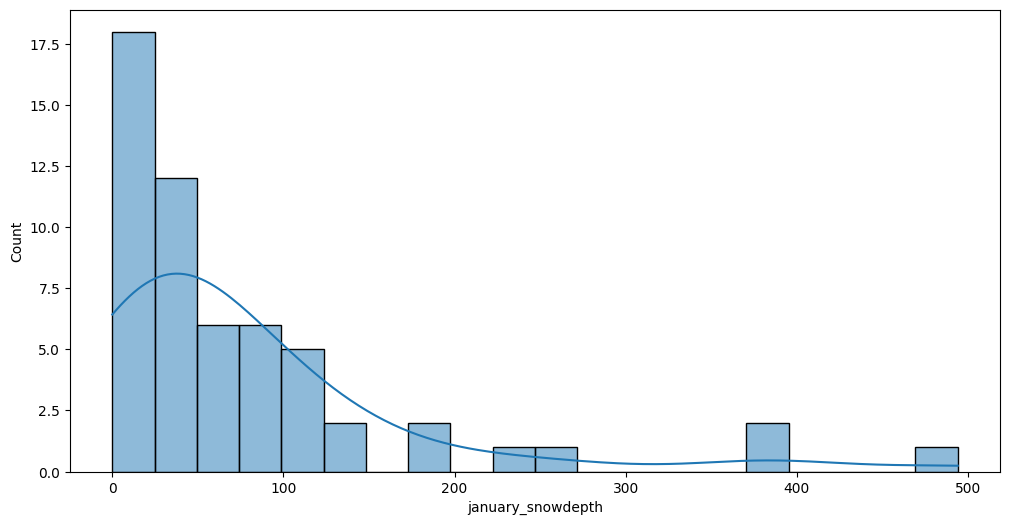

In [53]:
#plot january snowdepth

# Set the figure size for better readability

plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['january_snowdepth'], bins=20, kde=True)

<Axes: xlabel='february_snowdepth', ylabel='Count'>

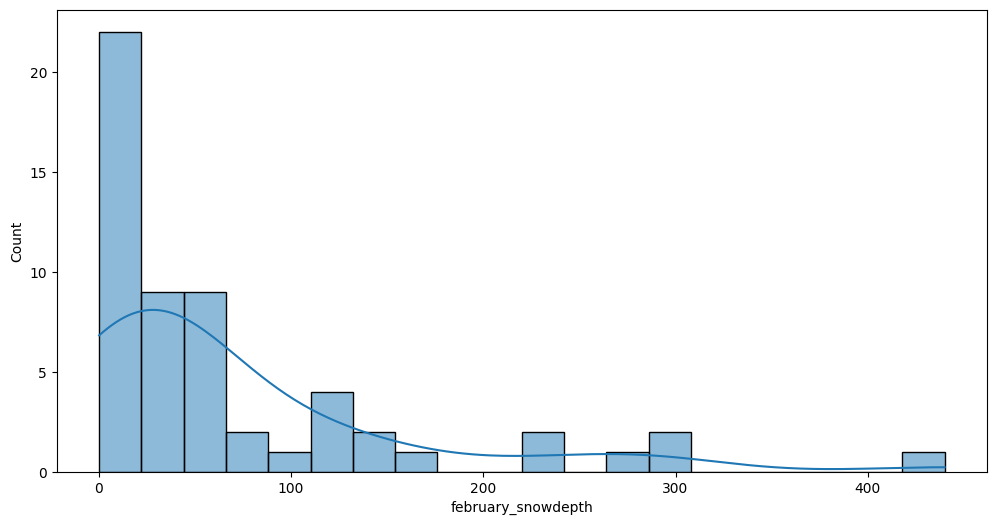

In [54]:
#plot february snowdepth

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['february_snowdepth'], bins=20, kde=True)

<Axes: >

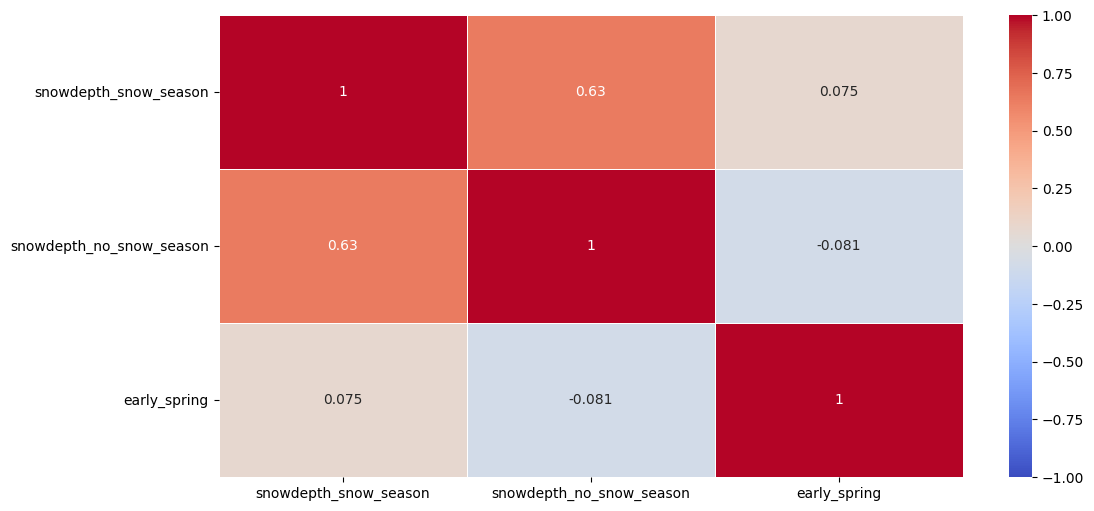

In [55]:
# break up middle 50% of snowdepths into "snowdepth_snow_season" and "snowdepth_no_snow_season"

#make day 9-day 42 snowdepths into snowdepth_snow_season

train['snowdepth_snow_season'] = train[snow_depth_cols[8:42]].sum(axis=1)

#make day 1-8 and day 43-56 snowdepths into snowdepth_no_snow_season

train['snowdepth_no_snow_season'] = train[snow_depth_cols[:8] + snow_depth_cols[42:56]].sum(axis=1)

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# create corr matrix

corr_matrix = train[['snowdepth_snow_season', 'snowdepth_no_snow_season', 'early_spring']]

# Create the heatmap
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)



<Axes: >

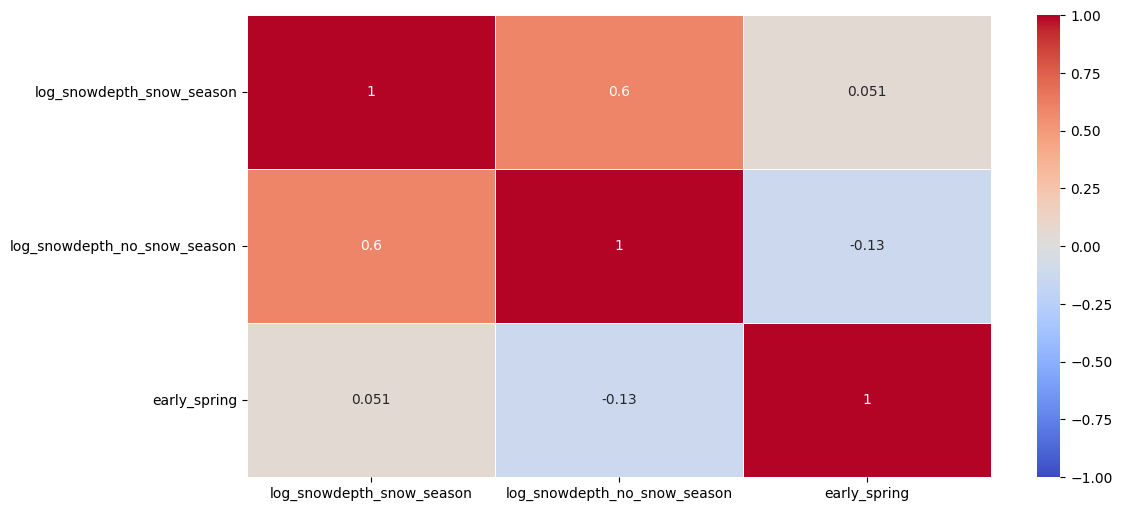

In [56]:
# log both snowdepths

train['log_snowdepth_snow_season'] = np.log1p(train['snowdepth_snow_season'])

train['log_snowdepth_no_snow_season'] = np.log1p(train['snowdepth_no_snow_season'])

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the correlation matrix

corr_matrix = train[['log_snowdepth_snow_season', 'log_snowdepth_no_snow_season', 'early_spring']]

# Create the heatmap
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

HUUUUUUUGE JUMP

<Axes: xlabel='log_snowdepth_snow_season', ylabel='Count'>

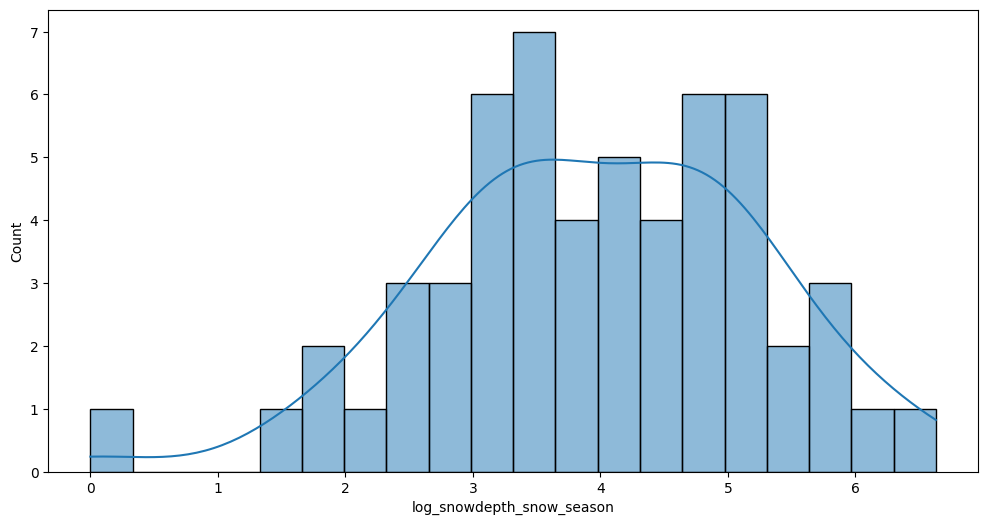

In [57]:
#histogram of log snowdepth snow season

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['log_snowdepth_snow_season'], bins=20, kde=True)

<Axes: xlabel='snowdepth_no_snow_season', ylabel='Count'>

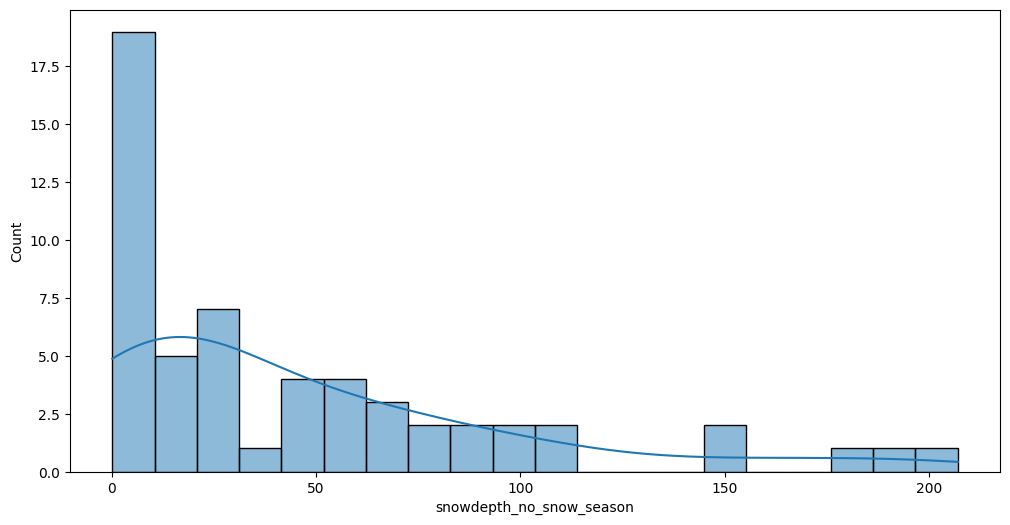

In [58]:
#histogram of snowdepth no snow season

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['snowdepth_no_snow_season'], bins=20, kde=True)

<Axes: xlabel='log_snowdepth_no_snow_season', ylabel='Count'>

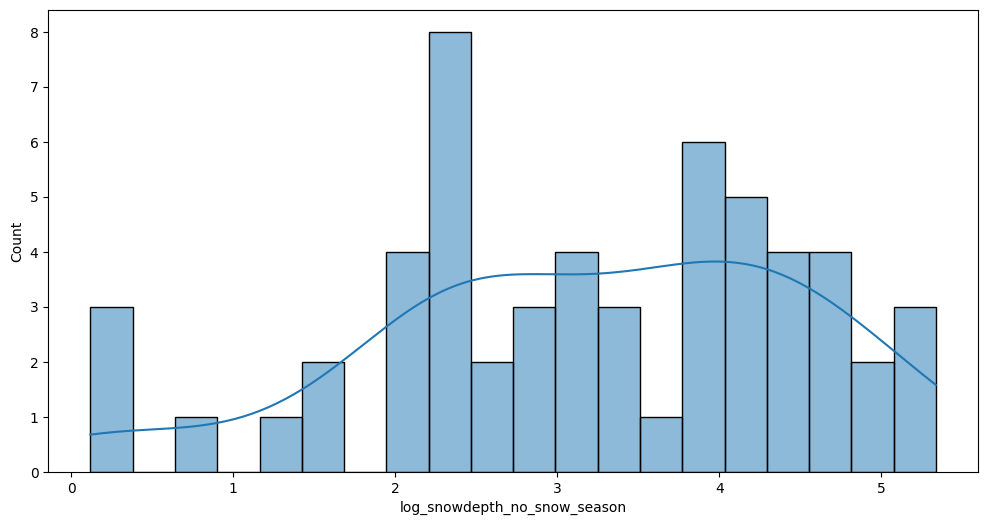

In [59]:
# histogram of log snowdepth no snow season

# Set the figure size for better readability

plt.figure(figsize=(12, 6))

# Create the histogram

sns.histplot(train['log_snowdepth_no_snow_season'], bins=20, kde=True)


<Axes: xlabel='snowdepth_56', ylabel='Count'>

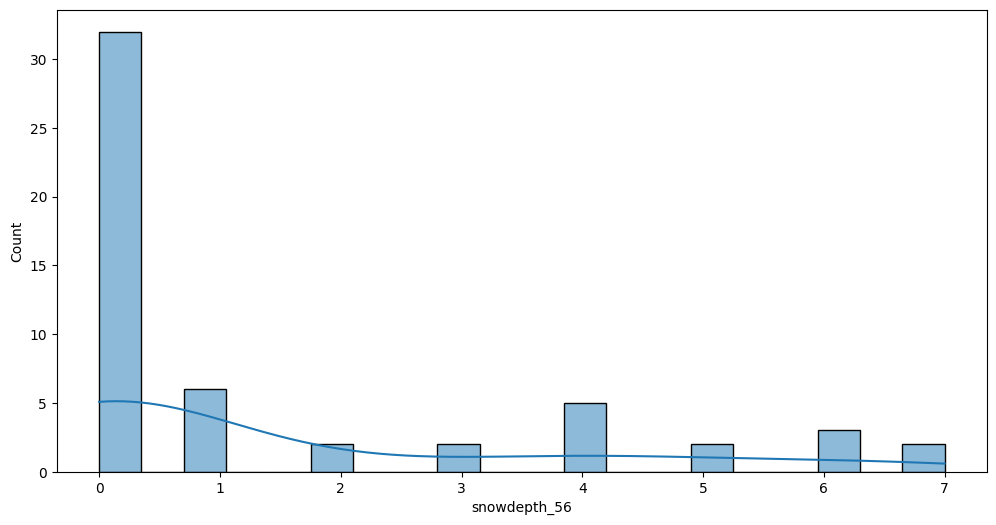

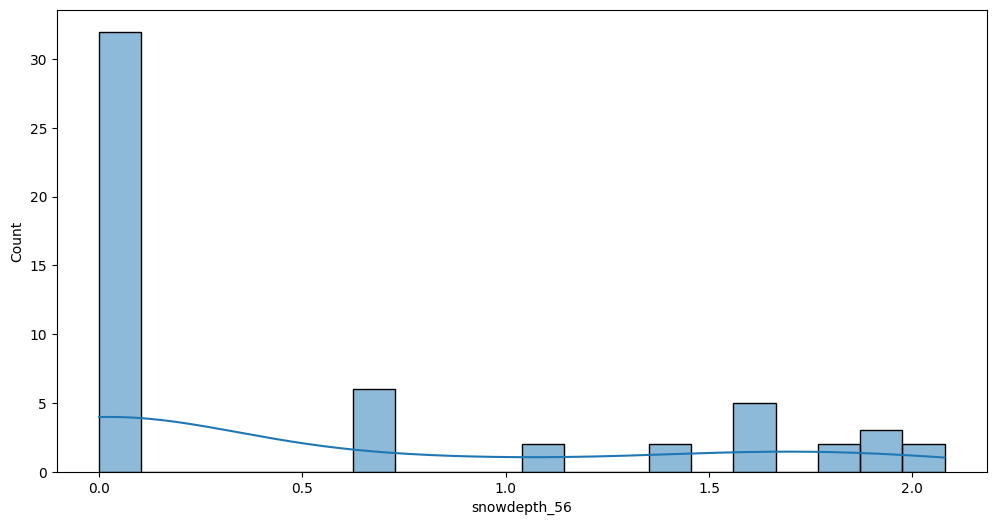

In [60]:
#snowdepth feb 25

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(train['snowdepth_56'], bins=20, kde=True)

#log snowdepth 25

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the histogram
sns.histplot(np.log1p(train['snowdepth_56']), bins=20, kde=True)

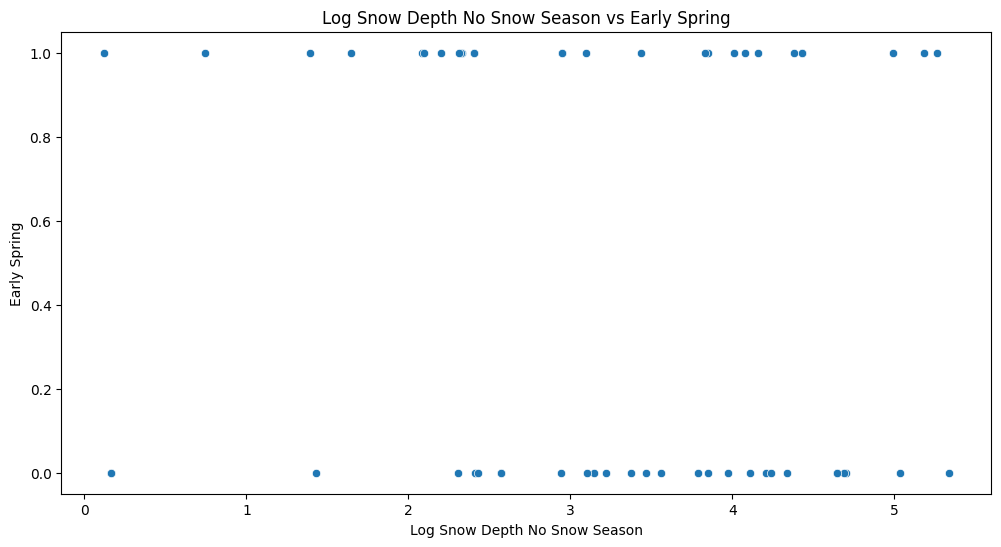

In [61]:
#scatterplot of log snowdepth no snow season and early spring

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the scatter plot
sns.scatterplot(train, x='log_snowdepth_no_snow_season', y='early_spring')
plt.title('Log Snow Depth No Snow Season vs Early Spring')
plt.xlabel('Log Snow Depth No Snow Season')
plt.ylabel('Early Spring')
plt.show()


# check day 42 to 53 for snowfall 

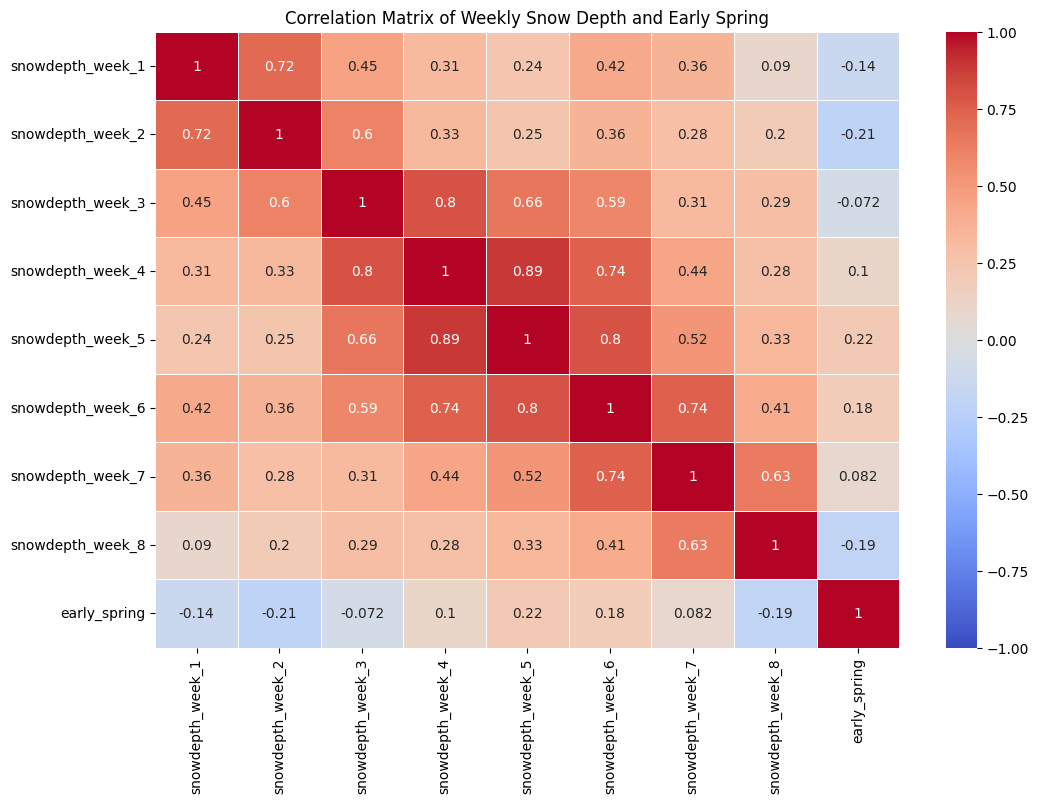

In [62]:
# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total snow depth
for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'snowdepth_week_{week}'
    week_cols = [f'snowdepth_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'snowdepth_week_{week}' for week in range(1, 9)]
corr_matrix_weeks = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_weeks, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Weekly Snow Depth and Early Spring')
plt.show()

Some of the weeks have some sort of correlation with the target label

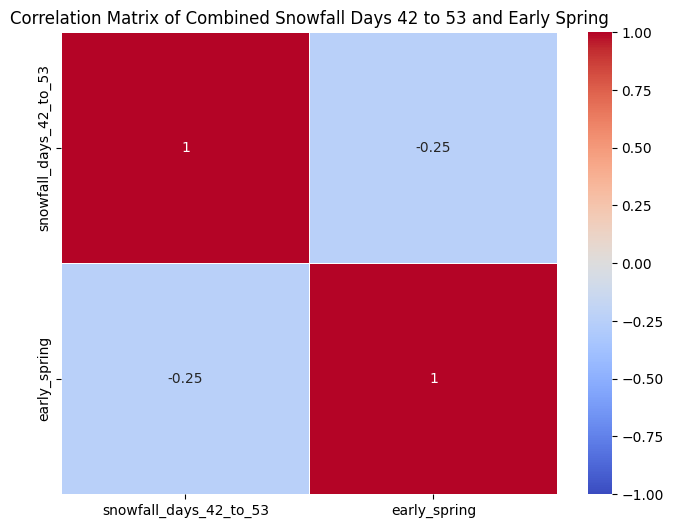

In [63]:
# define snowfall_days_42_to_53
snowfall_days_42_to_53 = [f'snowfall_{i}' for i in range(42, 54)]

# Combine snowfall columns from day 42 to day 53 into a single feature
train['snowfall_days_42_to_53'] = train[snowfall_days_42_to_53].sum(axis=1)

# Calculate the correlation matrix
corr_matrix_combined = train[['snowfall_days_42_to_53', 'early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_combined, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Combined Snowfall Days 42 to 53 and Early Spring')
plt.show()

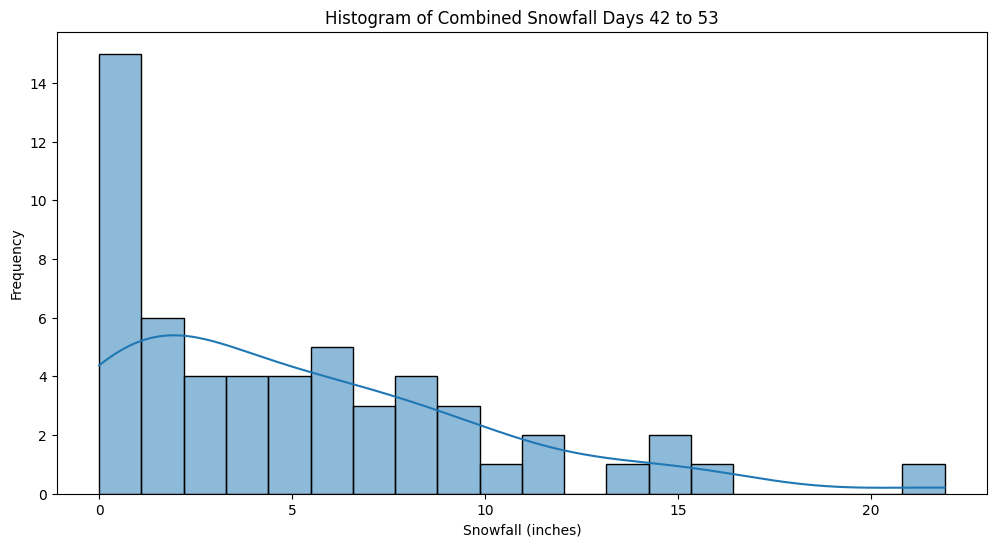

In [64]:
# show histogram for snowfall days 42 to 53
plt.figure(figsize=(12, 6))
sns.histplot(train['snowfall_days_42_to_53'], bins=20, kde=True)
plt.title('Histogram of Combined Snowfall Days 42 to 53')
plt.xlabel('Snowfall (inches)')
plt.ylabel('Frequency')
plt.show()

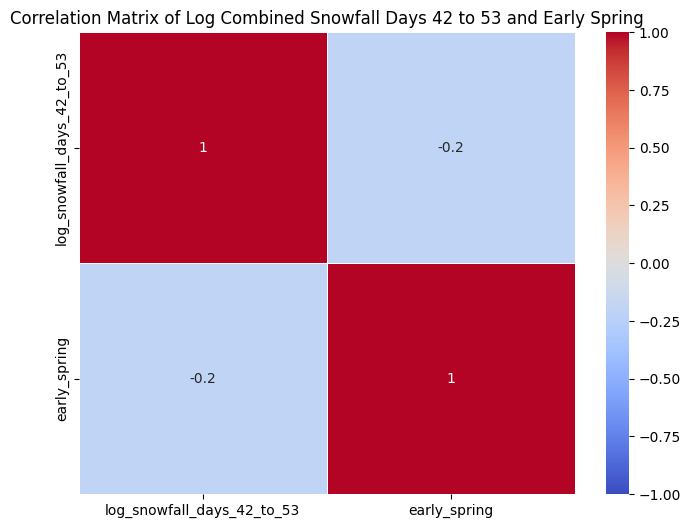

In [65]:
train['log_snowfall_days_42_to_53'] = np.log1p(train['snowfall_days_42_to_53'])

# Heatmap correlation for log snowfall days 42 to 53 and early spring
corr_matrix_log_snowfall = train[['log_snowfall_days_42_to_53', 'early_spring']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_log_snowfall, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Log Combined Snowfall Days 42 to 53 and Early Spring')
plt.show()


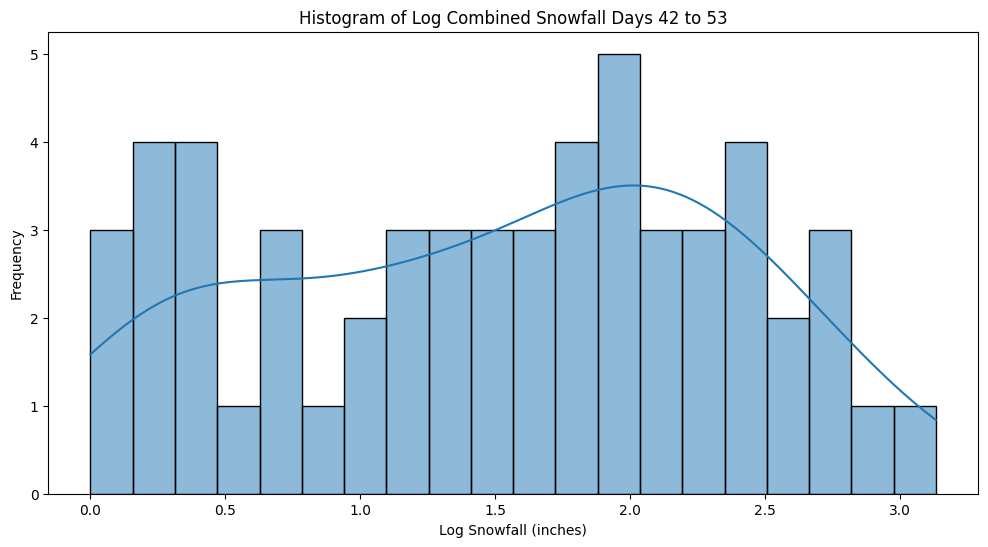

In [66]:
# histogram of log snowfall days 42 to 53
plt.figure(figsize=(12, 6))
sns.histplot(train['log_snowfall_days_42_to_53'], bins=20, kde=True)
plt.title('Histogram of Log Combined Snowfall Days 42 to 53')
plt.xlabel('Log Snowfall (inches)')
plt.ylabel('Frequency')
plt.show()

logging snowfall made it look more uniform rather than normal 

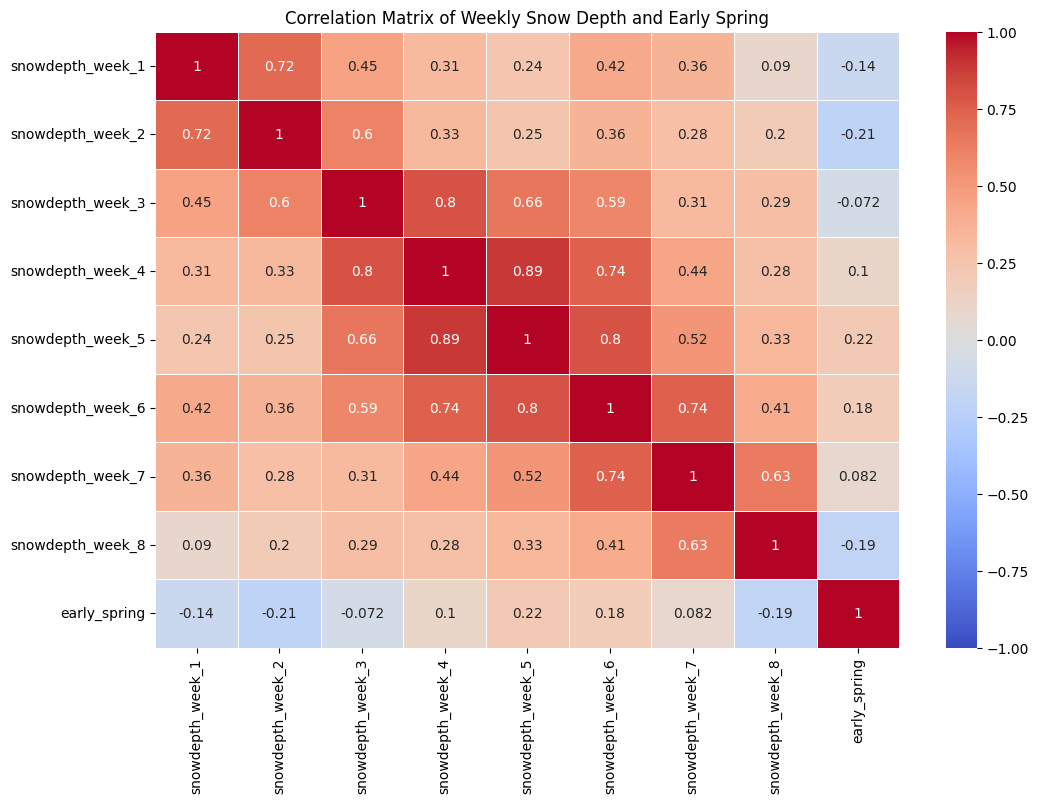

In [67]:
# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total snow depth
for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'snowdepth_week_{week}'
    week_cols = [f'snowdepth_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'snowdepth_week_{week}' for week in range(1, 9)]
corr_matrix_weeks_snowdepth = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_weeks_snowdepth, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Weekly Snow Depth and Early Spring')
plt.show()

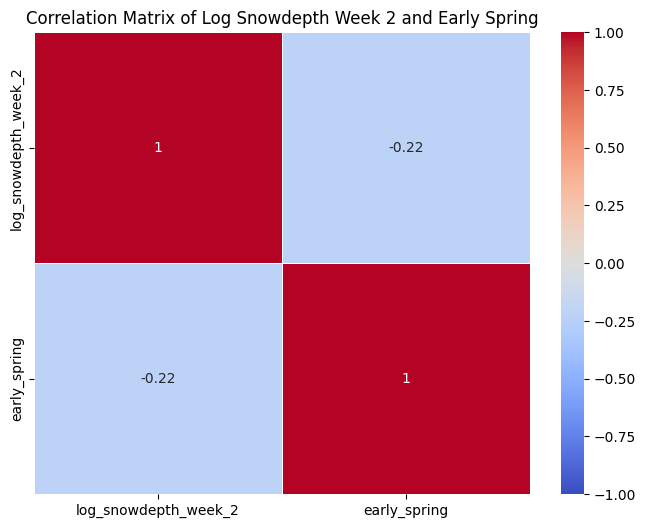

In [68]:
# Log-transform snowdepth_week_2
train['log_snowdepth_week_2'] = np.log1p(train['snowdepth_week_2'])

# Calculate the correlation matrix
corr_matrix_log_week_2 = train[['log_snowdepth_week_2', 'early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_log_week_2, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Log Snowdepth Week 2 and Early Spring')
plt.show()

<Axes: >

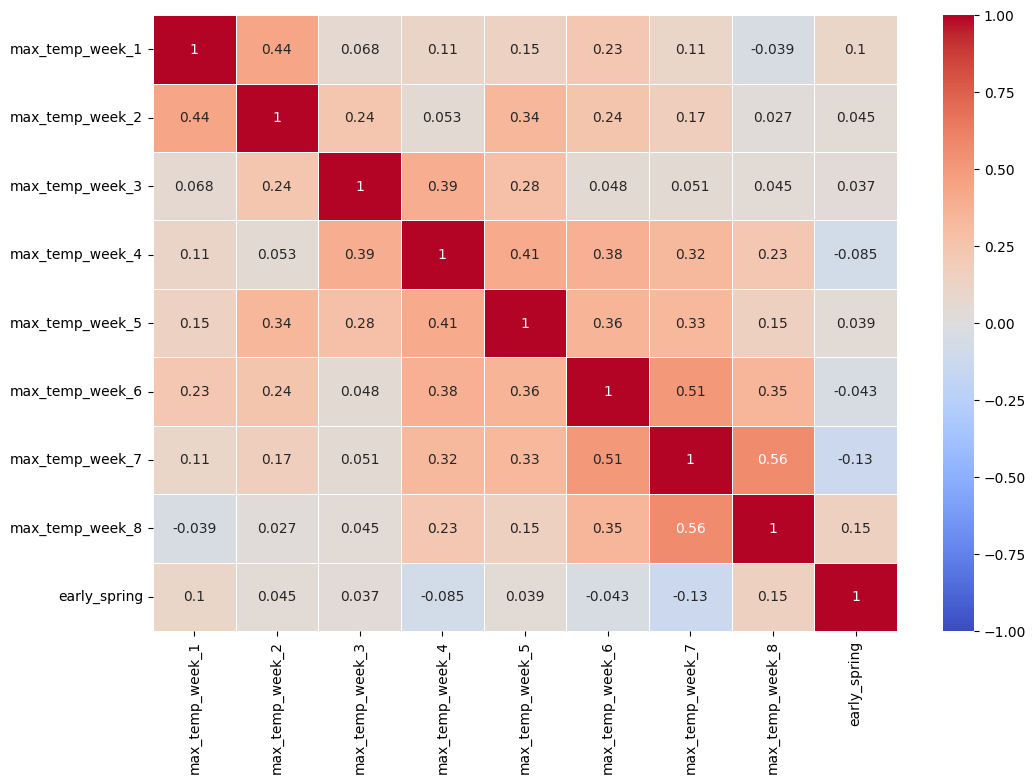

In [69]:
# Break up max temp into weeks

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total max temp

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'max_temp_week_{week}'
    week_cols = [f'max_temp_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'max_temp_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_max_temp = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_max_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)


<Axes: >

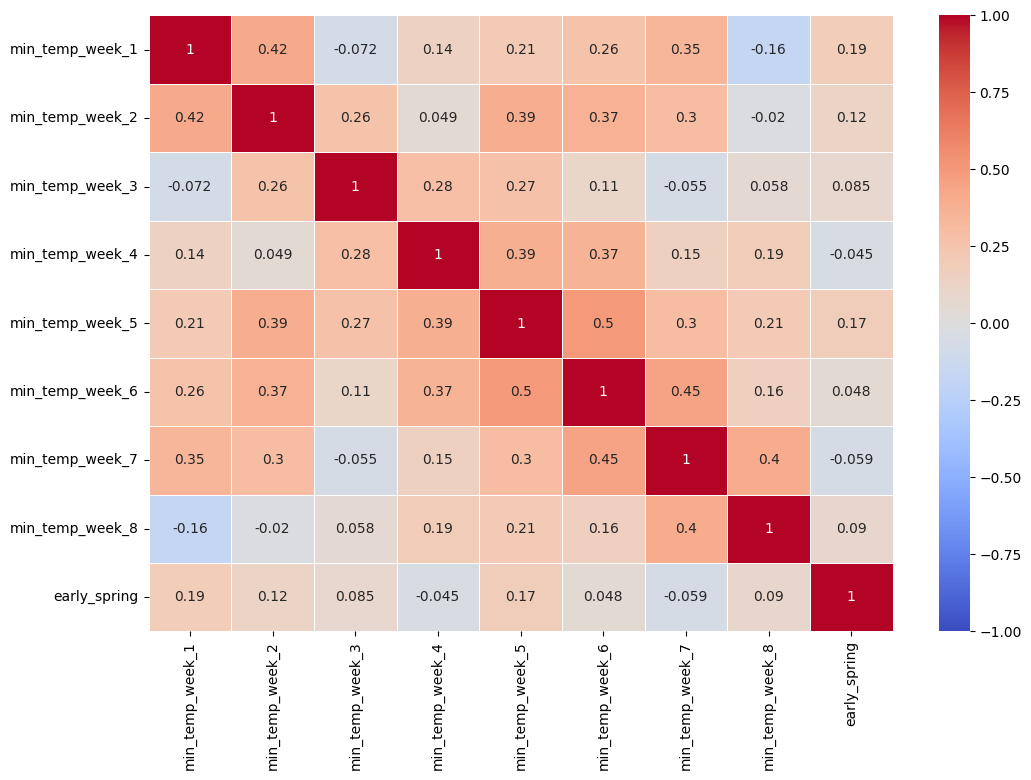

In [70]:
# break up min temp into weeks

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total min temp

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'min_temp_week_{week}'
    week_cols = [f'min_temp_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)


# Calculate the correlation matrix
week_cols = [f'min_temp_week_{week}' for week in range(1, 9)]
corr_matrix_weeks_min_temp = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_min_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/2115300592.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/2115300592.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)


<Axes: >

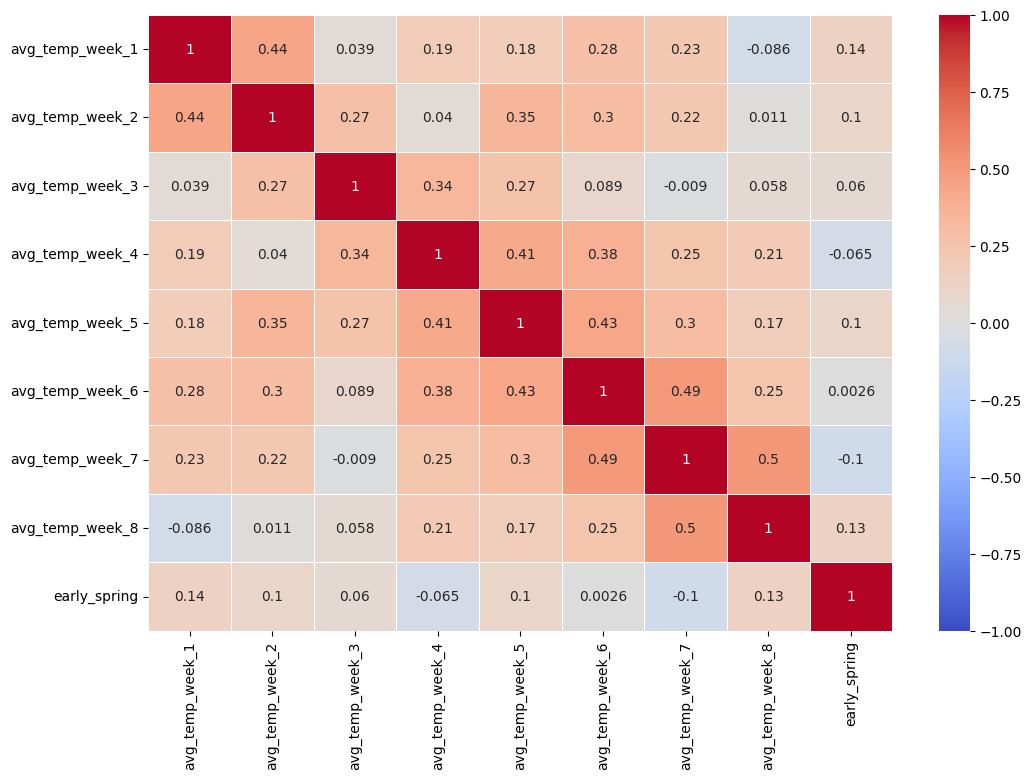

In [71]:
# break up avg temp into weeks

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total avg temp

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'avg_temp_week_{week}'
    week_cols = [f'avg_temp_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'avg_temp_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_avg_temp = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_avg_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/412558143.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/412558143.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/412558143.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

<Axes: >

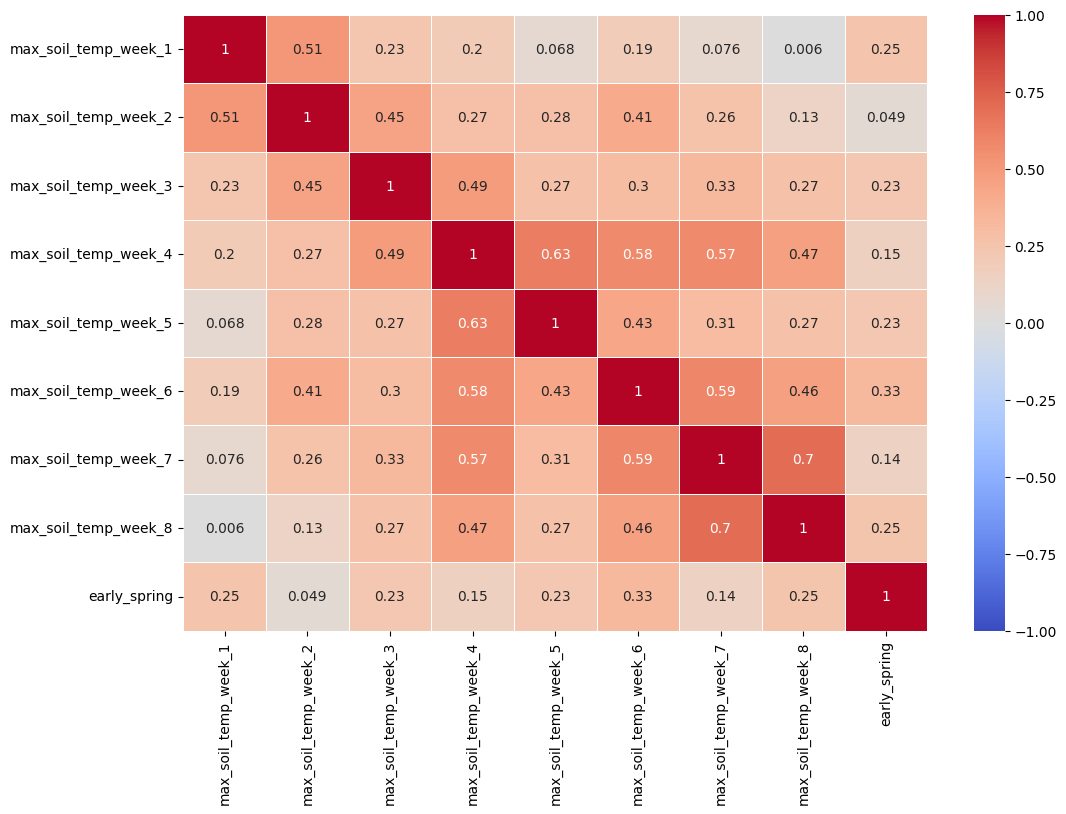

In [72]:
# Max soil temp

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total max soil temp

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'max_soil_temp_week_{week}'
    week_cols = [f'max_soil_temp_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'max_soil_temp_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_max_soil_temp = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_max_soil_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1664278877.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1664278877.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1664278877.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

<Axes: >

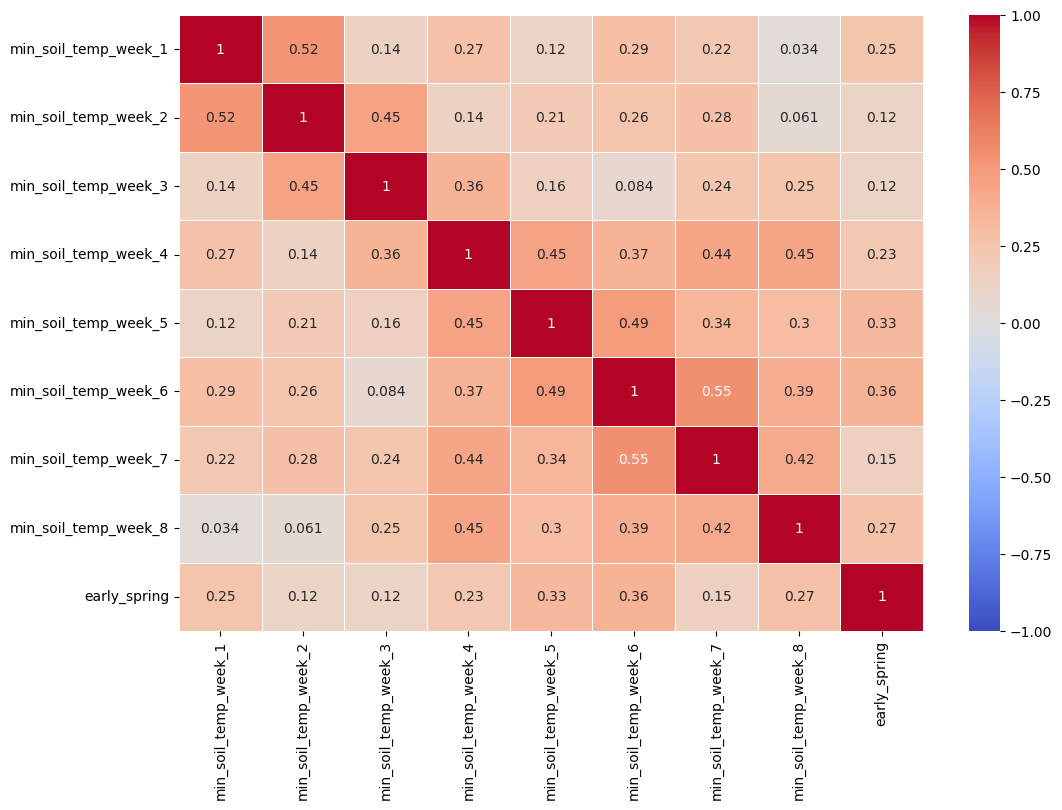

In [73]:
# min soil temp

# Define the number of days in each week

days_in_week = 7

# Create new columns for each week's total min soil temp

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'min_soil_temp_week_{week}'
    week_cols = [f'min_soil_temp_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'min_soil_temp_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_min_soil_temp = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_min_soil_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1022303339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1022303339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1022303339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

<Axes: >

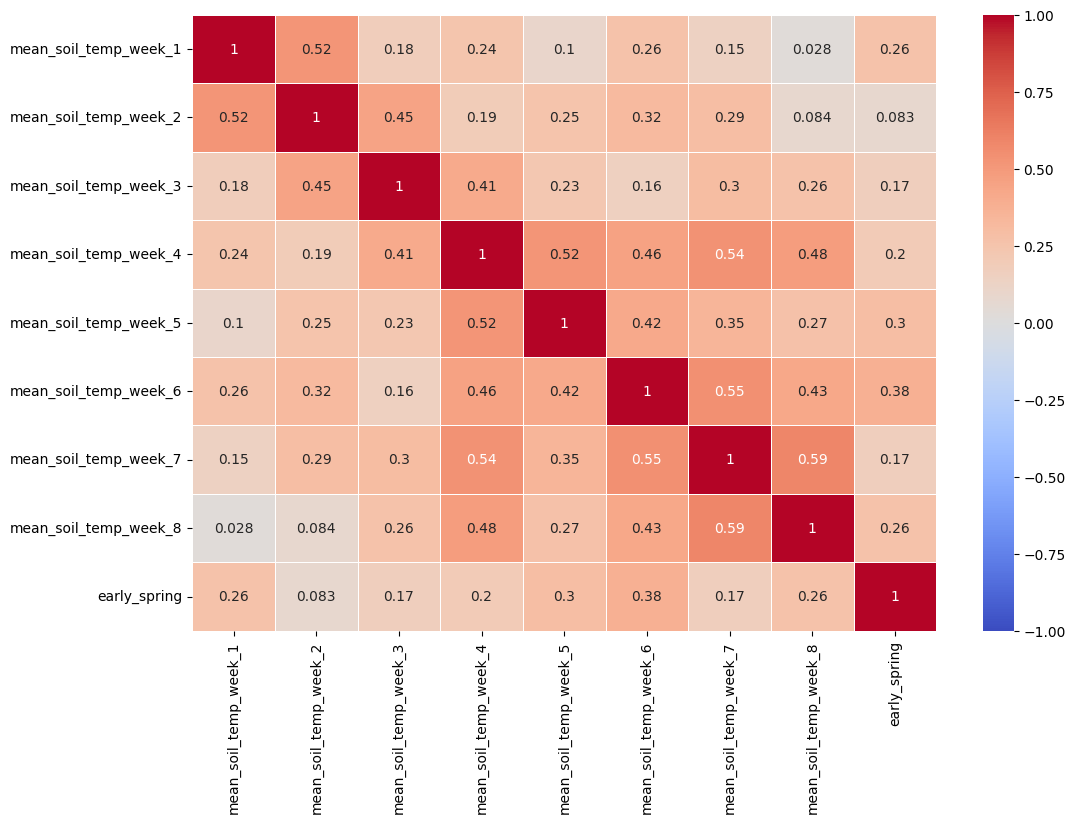

In [74]:
# mean soil temp

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total avg soil temp

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'mean_soil_temp_week_{week}'
    week_cols = [f'mean_soil_temp_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'mean_soil_temp_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_avg_soil_temp = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_avg_soil_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)


/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/137635053.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/137635053.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/137635053.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

<Axes: >

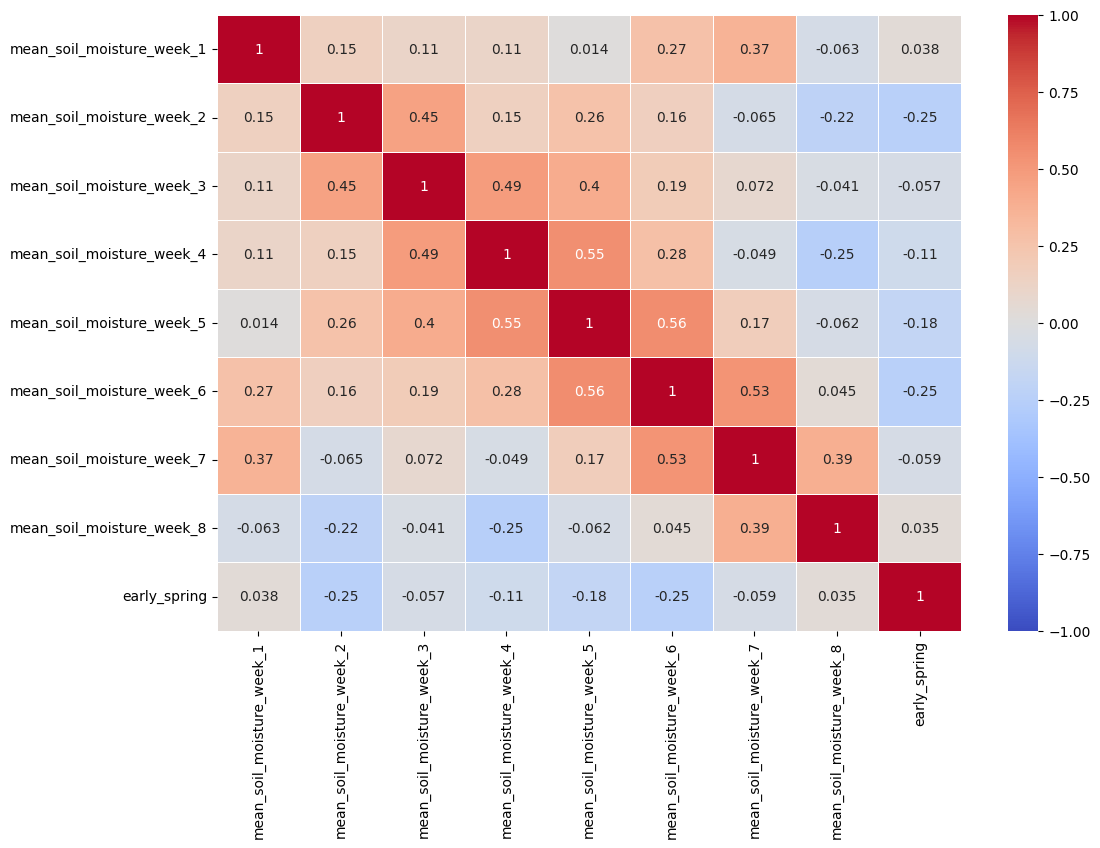

In [75]:
# mean soil moisture

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total avg soil moisture

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'mean_soil_moisture_week_{week}'
    week_cols = [f'mean_soil_moisture_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)

# Calculate the correlation matrix
week_cols = [f'mean_soil_moisture_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_avg_soil_moisture = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_avg_soil_moisture, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/660501267.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/660501267.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/660501267.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

<Axes: >

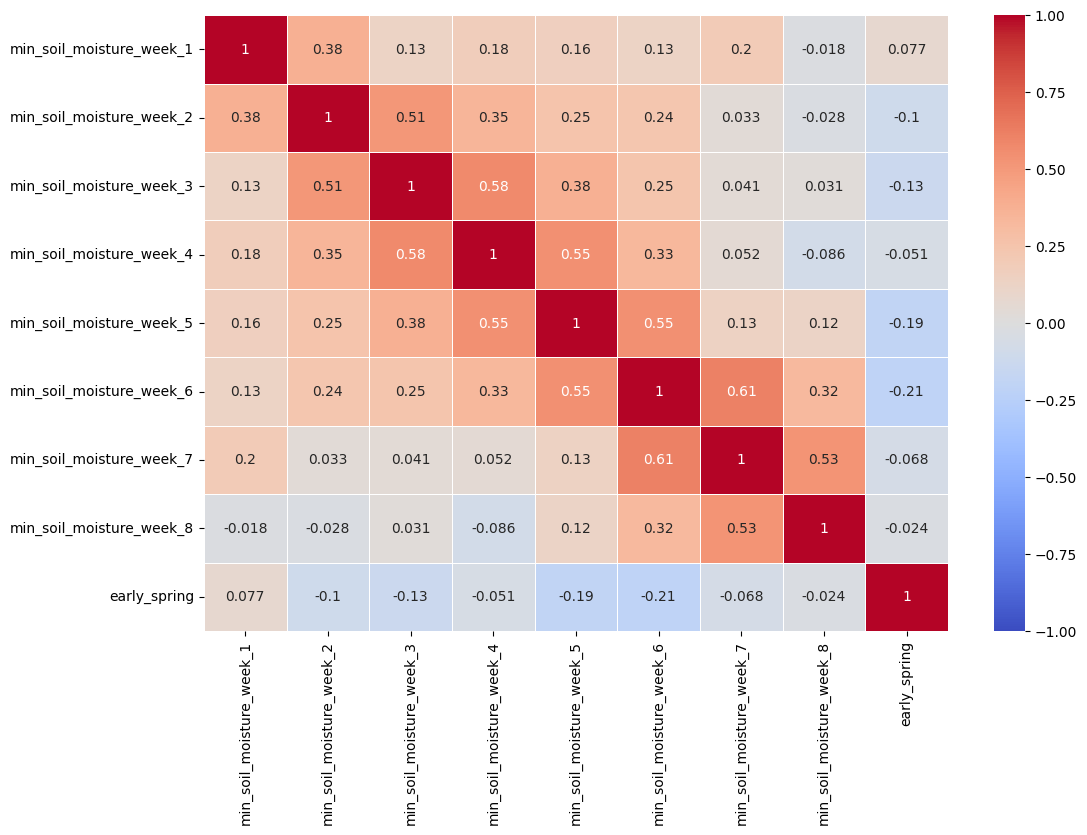

In [76]:
#min soil moisture

# Define the number of days in each week
days_in_week = 7   

# Create new columns for each week's total min soil moisture

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'min_soil_moisture_week_{week}'
    week_cols = [f'min_soil_moisture_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)


# Calculate the correlation matrix
week_cols = [f'min_soil_moisture_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_min_soil_moisture = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_min_soil_moisture, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/3151049838.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/3151049838.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[week_col_name] = train[week_cols].sum(axis=1)
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/3151049838.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

<Axes: >

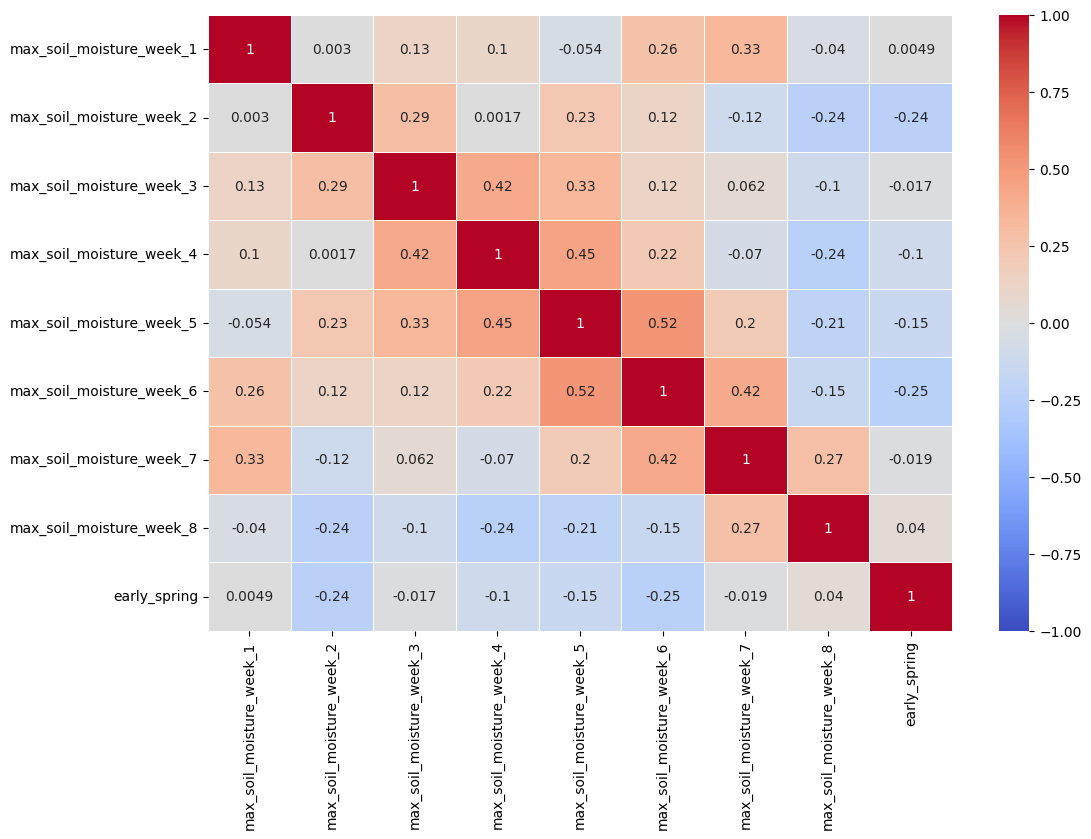

In [77]:
#max soil moisture

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total max soil moisture

for week in range(1, 9):  # There are 8 weeks in 56 days
    start_day = (week - 1) * days_in_week + 1
    end_day = week * days_in_week
    week_col_name = f'max_soil_moisture_week_{week}'
    week_cols = [f'max_soil_moisture_{day}' for day in range(start_day, end_day + 1)]
    train[week_col_name] = train[week_cols].sum(axis=1)


# Calculate the correlation matrix
week_cols = [f'max_soil_moisture_week_{week}' for week in range(1, 9)]

corr_matrix_weeks_max_soil_moisture = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_max_soil_moisture, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

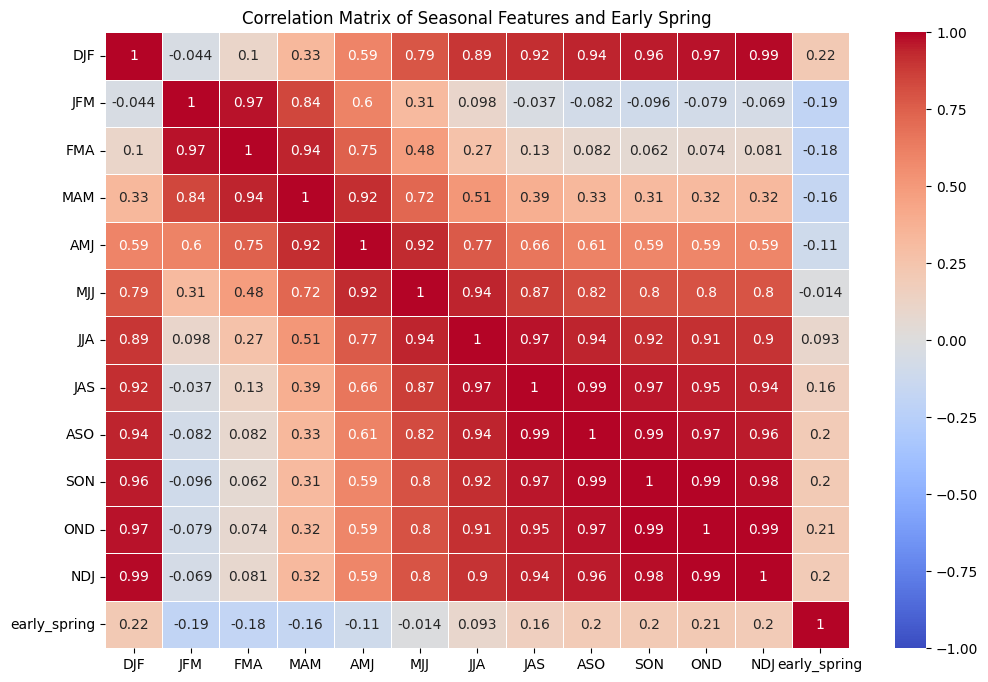

In [78]:
# Select the relevant columns for the correlation matrix
seasonal_columns = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ', 'early_spring']

# Create the correlation matrix
corr_matrix_seasonal = data[seasonal_columns].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_seasonal, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Seasonal Features and Early Spring')
plt.show()

In [79]:
# get the delta of week to week for min soil moisture

# Define the number of days in each week
days_in_week = 7

# Create new columns for each week's total min soil moisture

for week in range(1, 8):  # There are 8 weeks in 56 days
    week_col_name = f'min_soil_moisture_week_{week}'
    next_week_col_name = f'min_soil_moisture_week_{week + 1}'
    train[f'min_soil_moisture_week_{week}_delta'] = train[next_week_col_name] - train[week_col_name]

# Calculate the correlation matrix
week_cols = [f'min_soil_moisture_week_{week}_delta' for week in range(1, 8)]


/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1859933815.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'min_soil_moisture_week_{week}_delta'] = train[next_week_col_name] - train[week_col_name]
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1859933815.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'min_soil_moisture_week_{week}_delta'] = train[next_week_col_name] - train[week_col_name]
/var/folders/bp/tqx1fv0145x29m0h097lbn2r0000gp/T/ipykernel_31742/1859933815.py:11:

<Axes: >

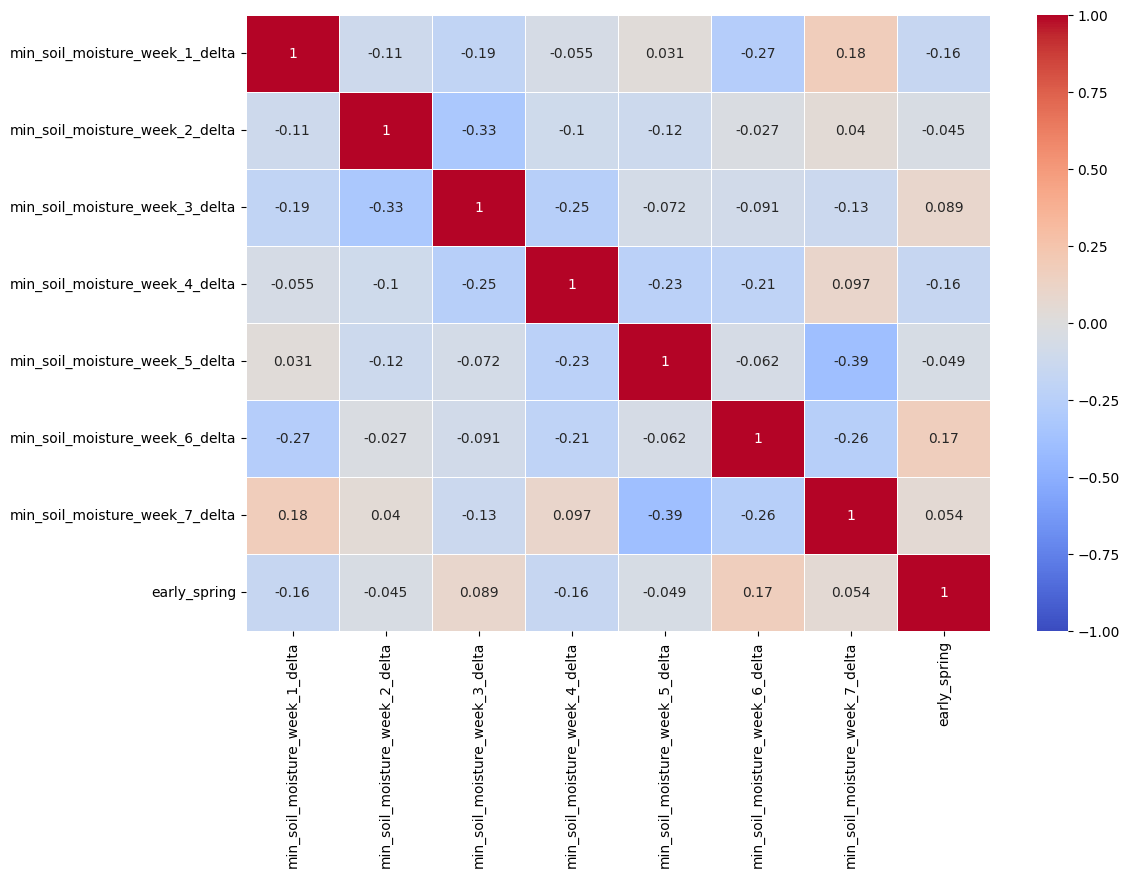

In [80]:
# Ensure 'early_spring' is included in the train DataFrame
train['early_spring'] = y_train

# Plot the correlation matrix of the deltas
corr_matrix_weeks_min_soil_moisture_delta = train[week_cols + ['early_spring']].corr()

# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_min_soil_moisture_delta, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)



In [81]:
# add all weeks in train to x_train

train = train.drop(columns='early_spring')


In [82]:
# Create the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(train, y_train)

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': train.columns,
    'importance': feature_importances
})

# Sort values by importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

In [83]:
week_columns = [col for col in train.columns if '_week_' in col]

# Iterate over unique variable types (e.g., snowdepth, max_temp, etc.)
for feature_type in set(col.split('_week_')[0] for col in week_columns):
    # Select columns for the current feature type
    cols = [col for col in train.columns if col.startswith(feature_type)]
    
    # Compute week-to-week delta for this feature type
    delta_cols = train[cols].diff(axis=1)
    
    # Add a suffix to indicate the delta
    delta_cols.columns = [f"{col}_delta" for col in cols]
    
    # Add the delta columns to the original DataFrame
    train = pd.concat([train, delta_cols], axis=1)

| **Feature**         | **Type**       | **Missing Values?**  | **Noisiness (Outliers, Gaps, etc.)** | **Usefulness (Business Goal)**                          | **Distribution**                                          |
|---------------------|----------------|-----------------------|--------------------------------------|---------------------------------------------------------|-----------------------------------------------------------|
| max_temp            | numerical       | No                | Outliers detected (5)                | Highly useful (affects early spring)                     | Normal distribution with slight skew                      |
| min_temp            | numerical       | No                | Outliers detected (2)                | Highly useful (affects early spring)                     | Normal distribution with slight skew                      |
| avg_temp            | numerical       | No               | No outliers detected                 | Highly useful (affects early spring)                     | Normal distribution                                       |
| precipitation       | numerical       | No               | Outliers detected (7)                | Somewhat useful (affects snow/soil)                      | Highly skewed (low values dominate) - Log Normal          |
| snowfall            | numerical       | No               | Outliers detected (7)                | Important for snow coverage                              | Normal distribution            |
| snowdepth           | numerical       |Yes               | Outliers detected (4)                | Useful (indicates snow cover)                            | Normal Distribution                |
| early_spring        | categorical            | No                | No issues detected                   | Target variable                                          | Binary: True/False                                        |
| mean_soil_moisture  | numerical       | No                | No outliers detected                 | Useful for predicting soil conditions                    | Skewed, concentrated around a median                      |
| min_soil_temp       | numerical       | No                | Outliers detected (8)                | Relevant (affects soil temperature)                      | Skewed, with negative values                              |
| min_soil_moisture   | numerical       | No               | No outliers detected                 | Some relevance                                           | Skewed, concentrated in a narrow range                    |
| max_soil_temp       | numerical       | No                | Outliers detected (10)               | Relevant for planting decisions                          | Skewed but centered                                       |
| max_soil_moisture   | numerical       | No                | No outliers detected                 | Useful for soil moisture trends                          | Right-Skewed Distribution                                 |
| mean_soil_temp       | numerical       | No               | Outliers detected (7)               | Relevant for planting decisions                          | Skewed but centered                                       |
| DJF                 | numerical       | Yes                | Outliers detected (0)   | Useful for El Nino changes                               | Slightly skewed, sort of Normal                           |
| JFM             | numerical       | Yes                  | Outliers detected (0)                   | Useful for seasonal analysis (Winter months)             | Normal Distribution                   |
| FMA             | numerical       | Yes                  | Outliers detected (0)                   | Useful for seasonal analysis (spring months)             | Normal Distribution                   |
| MAM             | numerical       | Yes                 | Outliers detected (0)                  | Useful for seasonal analysis (spring months)             | Bimodial distribution                  |
| AMJ             | numerical       | Yes                  | Outliers detected (0)                  | Useful for planting windows (late spring to early summer)| Normal Distribution                 |
| MJJ             | numerical       | Yes                 | Outliers detected (0)                  | Useful for seasonal analysis (Summer months)             | Normal distribution                  |
| JJA             | numerical       | Yes                  | Outliers detected (0)                 | Relevant for summer months                              | Normal distribution              |
| JAS             | numerical       | Yes                  | Outliers detected (0)                 | Useful for late summer and harvesting trends             | Normal distribution                                               |
| ASO             | numerical       | Yes                 | Outliers detected (0)                | Useful for late summer to early fall analysis            | Normal distribution                                |
| SON             | numerical       | Yes                  | Outliers detected (0)                   | Relevant for fall seasons                                | Normal distribution                   |
| OND             | numerical       | Yes                 | Outliers detected (0)                   | Useful for winter changes                                | Normal distribution             |
| NDJ             | numerical       | Yes                  | Outliers detected (0)                   | Relevant for early winter                                | Bimodial distribution                         |


1. **Temperature Features (Max, Min, Avg)**:
   - These temperature features (max, min, and average) are highly useful for predicting early spring as they influence the soil temperature and overall growth conditions.
   - The distributions for these features are generally normal with slight skew, meaning that the majority of values are concentrated around the mean with a few outliers, particularly in extreme weather conditions.
   - No missing values are present, making these features reliable for modeling.

2. **Soil Moisture and Soil Temperature**:
   - These features are crucial for understanding the planting conditions, especially `mean_soil_moisture` and `max_soil_moisture`, which have a skewed but centered distribution. This suggests that soil moisture is consistent in certain ranges but there are outliers that may impact planting.
   - `max_soil_temp` and `min_soil_temp` are also essential as they affect planting decisions directly by indicating optimal growing conditions.
   - The distribution shows a skew towards certain values, indicating variability in soil moisture and temperature across the dataset, but no significant gaps or missing values were detected.

3. **Seasonal Features (FMA, MAM, etc.)**:
   - These features represent important seasonal trends for various months and combinations of months (e.g., FMA for February-March-April).
   - They are generally normally distributed with minor outliers, which is expected given seasonal temperature variations.
   - The usefulness of these features comes from their relevance to key planting and growing seasons, particularly spring and early summer, which influence the early spring predictions.

4. **Precipitation and Snowfall**:
   - These features are skewed, with precipitation and snowfall having highly skewed log-normal distributions. The majority of the values are low, but there are a few extreme cases.
   - Despite this skew, these features are still somewhat useful for understanding snow/soil dynamics, which indirectly affect early spring predictions.
   - These variables have no missing values, but the outliers may need further exploration to understand their impact on the model.

5. **Three Letter Features**:
   - The `Three Letter Features` (DJF, FMA, ...) features are used for analyzing El Nino and winter season changes. And they shows some gaps and a slightly skewed distribution.
   - The features could provide insights into the influence of winter temperature trends on the onset of early spring, particularly in extreme conditions like El Nino years.

6. **Early Spring**:
   - This is the target variable and has no missing values or issues detected. It is binary (True/False), which makes it ideal for classification tasks.
   - The overall model should focus on correlating other features to this target variable to make accurate predictions about early spring.

# Summary

### Number of Features
- There are over 500 different features. Mostly because of most features being split up for every day (56 each)

### Things to Drop
- Everything that is not in week format. We are deciding to break it up by weeks because you can see stronger correlation that way, and it will also narrow down the features we are using by a lot.
- Within the random forest that we ran, there were many other features that we will drop. Some from the ONI data, and some weeks are not relevant to predicting Early Spring. We will drop all features that are either 0 or extremely close to 0 in the random forest. We will do that in our pipeline.

### Days to Weeks
- When you change the features from being split up from days into weeks you start to see a lot more consistent correlation with early spring. This is something we will do in our pipeline.

# Delta Information
- We thought that the delta from week to week may also be a useful predictor. Within our pipeline we will extract the deltas for every variables weeks.. As seen in our delta for the min soil temp weeks, there are some weeks where the information shows some relatively strong correlation with early spring. This gives us confidence that it can be useful within our model.

### Soil Temp
- all of the soil temp features are EXTREMELY correlated with early spring compared to other variables. (sometimes as strong as 0.36). This gives us confidence that many of these weeks within all of the soil temp features will be useful predictors for early spring.

### Logging to no success.
- When logging features which originally looked log normal such as snow depth, snowfall, and precipitation, we noticed that logging them did not improve correlation at all with early spring. In fact, logging them actually dropped correlation with early spring most of the time. Because of that, we will not be logging ANY of our features within our pipeline.

### Snow Season Idea
- Also tried breaking up snow features (snowfall, snowdepth) into snow season categories (in season, out of season). This did not work. We were not able to find any correlation with early spring in our testing. We will not be using this in our pipeline


# Data Prep

### GOALS FOR TRANSFORMATION

- Extract week data for each numbered column
- Extract Delta from weekly columns
- Drop unneccecary columns
- Impute Data
- Scale Data

In [84]:
feature_prefixes = ['snowdepth', 'precipitation', 'min_temp', 'max_temp', 'avg_temp', 'snowfall', 'mean_soil_temp', 'mean_soil_moisture', 'min_soil_temp',
                  'min_soil_moisture', 'max_soil_temp', 'max_soil_moisture'  ] 


In [85]:
from sklearn.feature_selection import SelectFromModel
# Define the preprocessor
column_transformer = Pipeline(steps=[
    ('imputer', ImputerTransformer()),
    ('Weekday', WeeklyFeatureTransformer(feature_prefixes=feature_prefixes)),
    ('Delta', WeeklyDeltaTransformer(feature_prefixes=feature_prefixes)),
    ('Scaler', StandardScaler())
])

# Define the full pipeline with feature selection and classifier
preprocessor = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
])

preprocessor

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', ImputerTransformer()),
                                 ('Weekday',
                                  WeeklyFeatureTransformer(feature_prefixes=['snowdepth',
                                                                             'precipitation',
                                                                             'min_temp',
                                                                             'max_temp',
                                                                             'avg_temp',
                                                                             'snowfall',
                                                                             'mean_soil_temp',
                                                                             'mean_soil_moisture',
                                                                             'min_soil_temp',
                                                                             'min_soil_moisture',
                                                                             'max_soil_temp',
                                                                             'max_soil_moisture'])),
                                 ('Delta',
                                  WeeklyDeltaTransformer(feature_prefixes=['snowdepth',
                                                                           'precipitation',
                                                                           'min_temp',
                                                                           'max_temp',
                                                                           'avg_temp',
                                                                           'snowfall',
                                                                           'mean_soil_temp',
                                                                           'mean_soil_moisture',
                                                                           'min_soil_temp',
                                                                           'min_soil_moisture',
                                                                           'max_soil_temp',
                                                                           'max_soil_moisture'])),
                                 ('Scaler', StandardScaler())])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42)))])

In [86]:
X = preprocessor.fit_transform(X_train, y_train)

X

array([[-0.56637078,  2.51118425,  2.45346684, ..., -0.65710829,
         0.12360334, -0.50845739],
       [ 0.7387445 , -1.3774123 , -0.97359795, ..., -0.01528159,
         0.07189309,  1.66267295],
       [-0.86755123, -1.3774123 , -1.28514929, ..., -0.09756706,
        -0.85150434,  0.90900031],
       ...,
       [ 1.84307281, -0.37390351, -0.03894392, ..., -1.16727824,
        -1.1174428 , -0.67440366],
       [ 1.14031843, -0.12302632,  0.4283831 , ..., -1.04385002,
        -0.71853511, -1.30361659],
       [-0.56637078,  0.88048247,  0.27260743, ..., -1.1096784 ,
        -1.70102997, -2.06420365]])

# Pipeline



### 5 steps
1. Impute the missing data. (Created a custom transformer it because the simple imputer was not working for some reason)
    - Decided to impute with mean because most of our data was normally distributed. Even features with things you could maybe consider outliers, the outliers within them were not crazy so we felt the mean was our best choice.
2. Created custom transformer to change features to being categorized by week isntead of day.
3. Created custom transformer to get the delta from week to week of our data.
4. Used standard scaler to scale data. (chose standard scaler over min max because most of our features were normally distributed)
5. Ran a random forest classifier to drop all unneccecary features at the end of our pipeline.

In [87]:
X.shape

(56, 35)

### Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# Create the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Define StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_dt = cross_val_predict(dt_clf, X, y_train, cv=cv)

# Fit the model to the training data
dt_clf.fit(X, y_train)

# Predict on the training data
y_train_pred_dt = dt_clf.predict(X)

# Calculate the accuracy, precision, recall, and F1 score on the training data
accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
precision_dt = precision_score(y_train, y_train_pred_dt)
recall_dt = recall_score(y_train, y_train_pred_dt)
f1_dt = f1_score(y_train, y_train_pred_dt)

# Calculate cross-validated scores
accuracy_cv_dt = accuracy_score(y_train, y_train_pred_cv_dt)
precision_cv_dt = precision_score(y_train, y_train_pred_cv_dt)
recall_cv_dt = recall_score(y_train, y_train_pred_cv_dt)
f1_cv_dt = f1_score(y_train, y_train_pred_cv_dt)

print(f"Cross-Validated Accuracy: {accuracy_cv_dt:.4f}")
print(f"Cross-Validated Precision: {precision_cv_dt:.4f}")
print(f"Cross-Validated Recall: {recall_cv_dt:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_dt:.4f}")

Cross-Validated Accuracy: 0.6071
Cross-Validated Precision: 0.6250
Cross-Validated Recall: 0.5357
Cross-Validated F1 Score: 0.5769


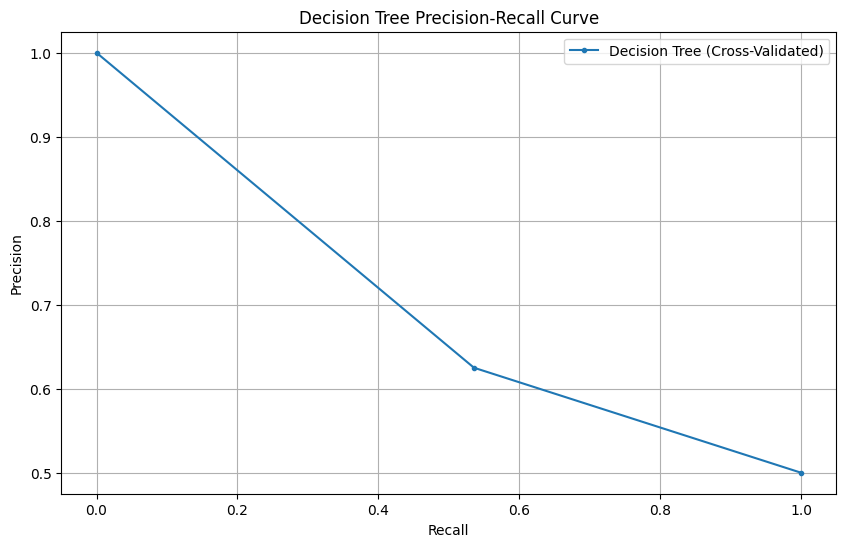

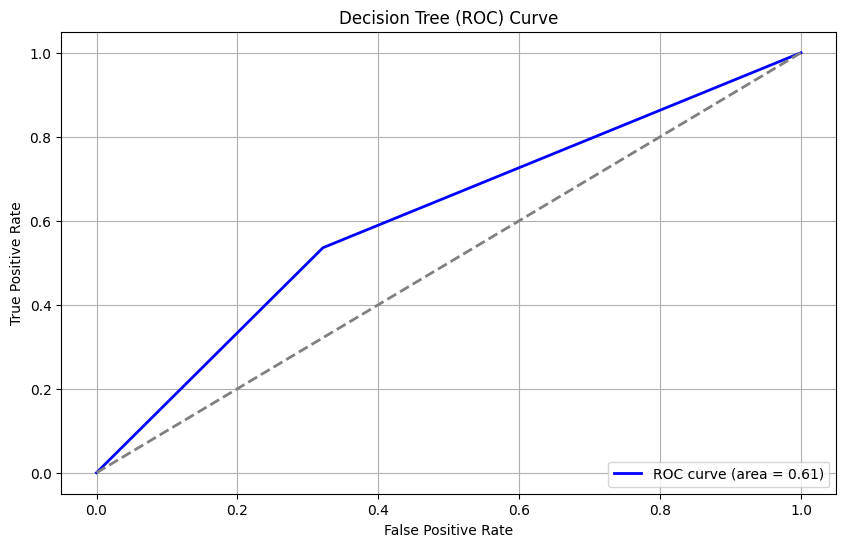

In [89]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the decision scores for the cross-validated predictions
y_scores_dt_cv = cross_val_predict(dt_clf, X, y_train, cv=cv, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_train, y_scores_dt_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Decision Tree (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Decision Tree Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_train, y_scores_dt_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### LinearSVC

In [90]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Create the LinearSVC classifier
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Fit the model to the training data
linear_svc.fit(X, y_train)

# Predict on the training data
y_train_pred = linear_svc.predict(X)

# Calculate the F1 score on the training data
train_f1_score = f1_score(y_train, y_train_pred)

# Perform cross-validation
cv_scores = cross_val_score(linear_svc, X, y_train, cv=5, scoring='f1')

# Perform cross-validation predictions
y_train_pred_cv = cross_val_predict(linear_svc, X, y_train, cv=5)

# Calculate cross-validated scores
accuracy_cv = accuracy_score(y_train, y_train_pred_cv)
precision_cv = precision_score(y_train, y_train_pred_cv)
recall_cv = recall_score(y_train, y_train_pred_cv)
f1_cv = f1_score(y_train, y_train_pred_cv)

print(f"Cross-Validated Accuracy: {accuracy_cv:.4f}")
print(f"Cross-Validated Precision: {precision_cv:.4f}")
print(f"Cross-Validated Recall: {recall_cv:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv:.4f}")

Cross-Validated Accuracy: 0.6964
Cross-Validated Precision: 0.7037
Cross-Validated Recall: 0.6786
Cross-Validated F1 Score: 0.6909


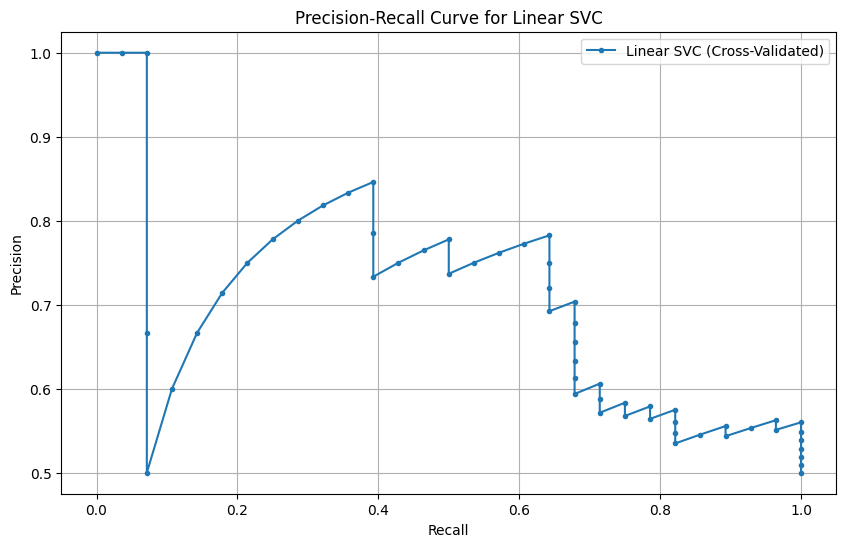

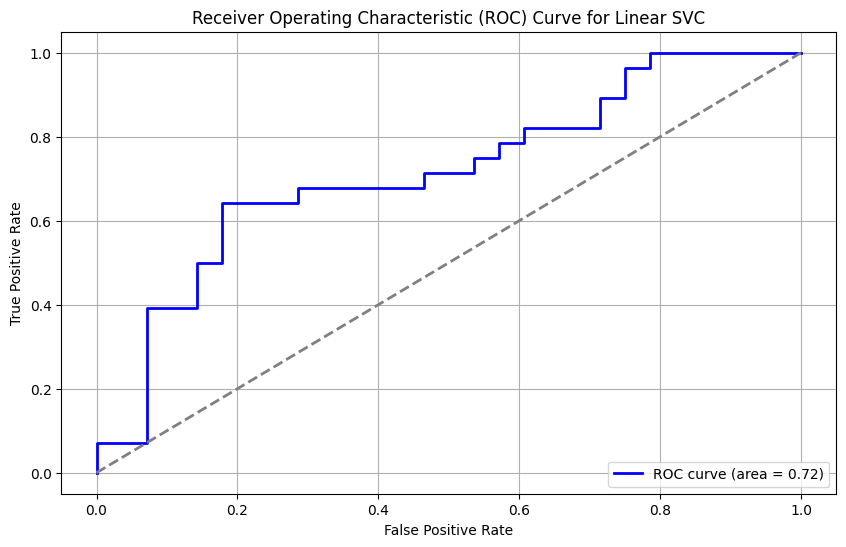

In [91]:
from sklearn.metrics import precision_recall_curve

# Get the decision scores for the cross-validated predictions
y_scores_svc_cv = cross_val_predict(linear_svc, X, y_train, cv=5, method='decision_function')

# Calculate precision and recall values
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_train, y_scores_svc_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_svc, precision_svc, marker='.', label='Linear SVC (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear SVC')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_svc, tpr_svc, roc_thresholds_svc = roc_curve(y_train, y_scores_svc_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear SVC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### K-Neighbors Classifier

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

# Create the KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Perform cross-validation predictions
y_train_pred_cv_knn = cross_val_predict(knn_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_knn = precision_score(y_train, y_train_pred_cv_knn)
recall_cv_knn = recall_score(y_train, y_train_pred_cv_knn)
f1_cv_knn = f1_score(y_train, y_train_pred_cv_knn)

print(f"Cross-Validated Precision: {precision_cv_knn:.4f}")
print(f"Cross-Validated Recall: {recall_cv_knn:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_knn:.4f}")

Cross-Validated Precision: 0.6061
Cross-Validated Recall: 0.7143
Cross-Validated F1 Score: 0.6557


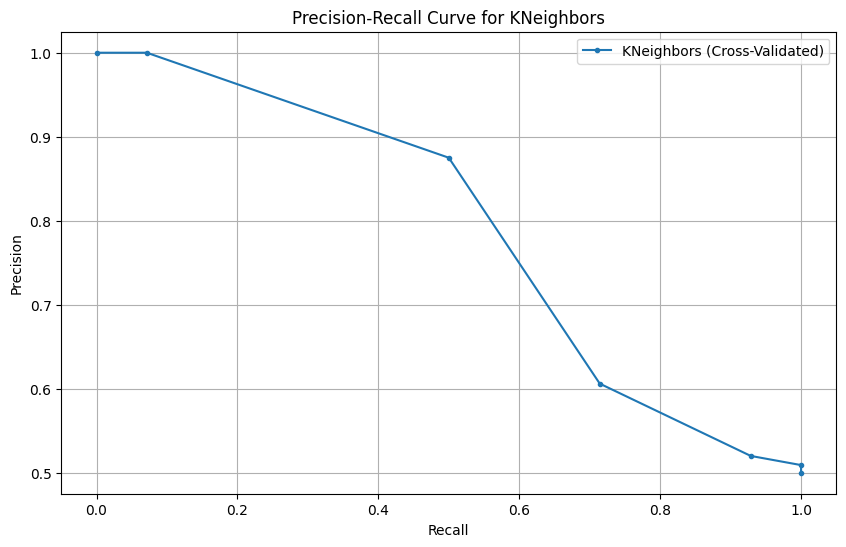

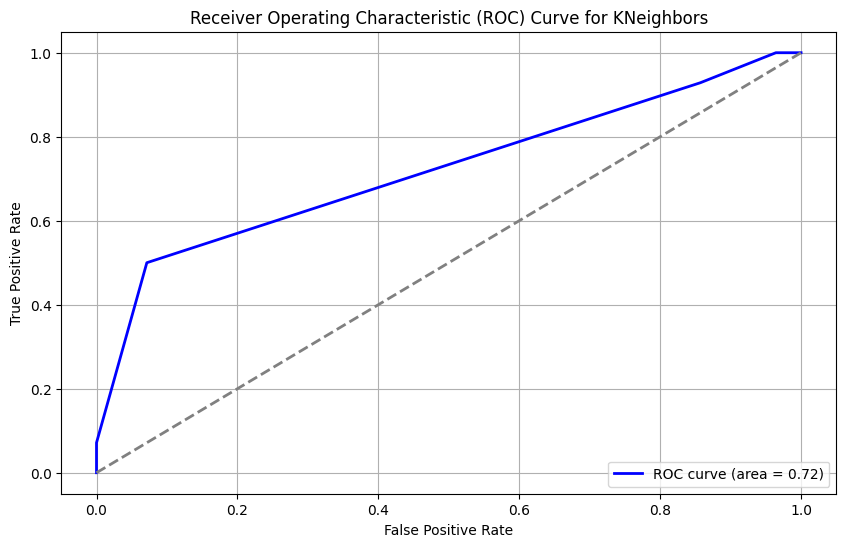

In [93]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Get the decision scores for the cross-validated predictions
y_scores_knn_cv = cross_val_predict(knn_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_train, y_scores_knn_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, marker='.', label='KNeighbors (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNeighbors')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_knn, tpr_knn, roc_thresholds_knn = roc_curve(y_train, y_scores_knn_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNeighbors')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### RadiusNeighborsClassifier

In [94]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

# Create the RadiusNeighborsClassifier
radius_neighbors_clf = RadiusNeighborsClassifier(radius=15.0)  # Increased radius

# Perform cross-validation predictions
y_train_pred_cv_rn = cross_val_predict(radius_neighbors_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_rn = precision_score(y_train, y_train_pred_cv_rn)
recall_cv_rn = recall_score(y_train, y_train_pred_cv_rn)
f1_cv_rn = f1_score(y_train, y_train_pred_cv_rn)

print(f"Cross-Validated Precision: {precision_cv_rn:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rn:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rn:.4f}")

Cross-Validated Precision: 0.4545
Cross-Validated Recall: 0.3571
Cross-Validated F1 Score: 0.4000


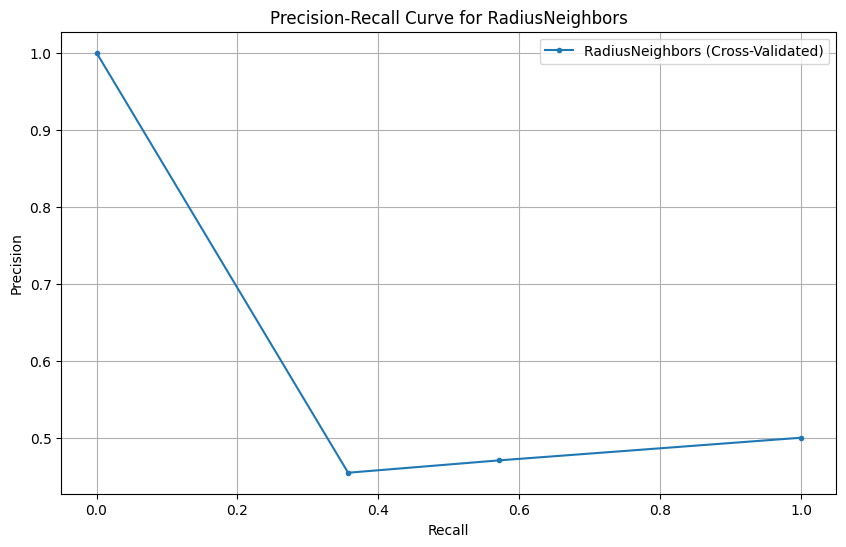

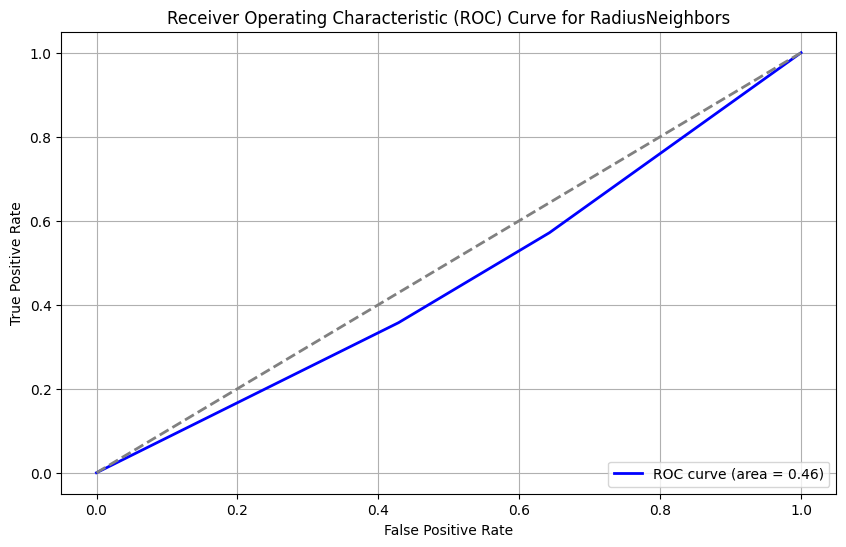

In [95]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

# Get the decision scores for the cross-validated predictions
y_scores_rn_cv = cross_val_predict(radius_neighbors_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_rn, recall_rn, thresholds_rn = precision_recall_curve(y_train, y_scores_rn_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rn, precision_rn, marker='.', label='RadiusNeighbors (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RadiusNeighbors')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rn, tpr_rn, roc_thresholds_rn = roc_curve(y_train, y_scores_rn_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_rn = auc(fpr_rn, tpr_rn)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rn, tpr_rn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RadiusNeighbors')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### SGDClassifier

In [96]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Create the SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

# Fit the model to the training data
sgd_clf.fit(X, y_train)

# Predict on the training data
y_train_pred_sgd = sgd_clf.predict(X)

# Calculate the F1 score on the training data
train_f1_score_sgd = f1_score(y_train, y_train_pred_sgd)

# Perform cross-validation
cv_scores_sgd = cross_val_score(sgd_clf, X, y_train, cv=5, scoring='f1')

# Perform cross-validation predictions
y_train_pred_cv_sgd = cross_val_predict(sgd_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_sgd = precision_score(y_train, y_train_pred_cv_sgd)
recall_cv_sgd = recall_score(y_train, y_train_pred_cv_sgd)
f1_cv_sgd = f1_score(y_train, y_train_pred_cv_sgd)

print(f"Cross-Validated Precision: {precision_cv_sgd:.4f}")
print(f"Cross-Validated Recall: {recall_cv_sgd:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_sgd:.4f}")

Cross-Validated Precision: 0.7037
Cross-Validated Recall: 0.6786
Cross-Validated F1 Score: 0.6909


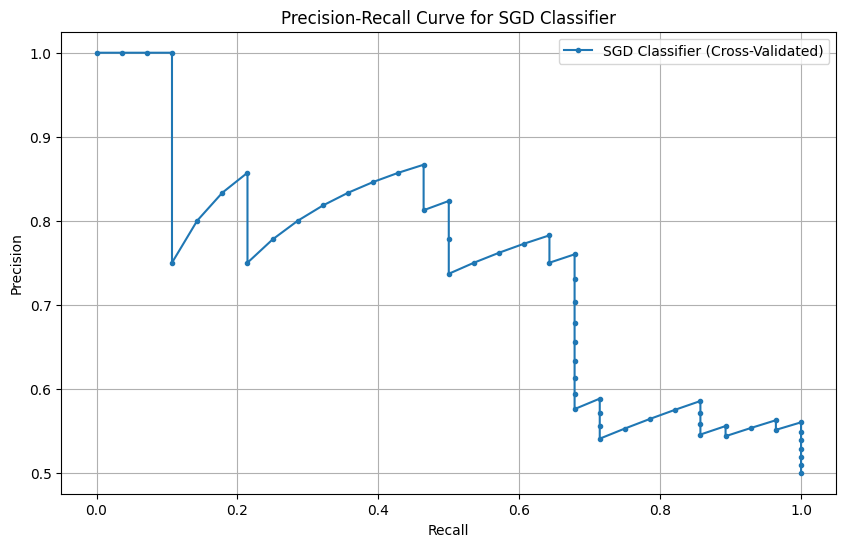

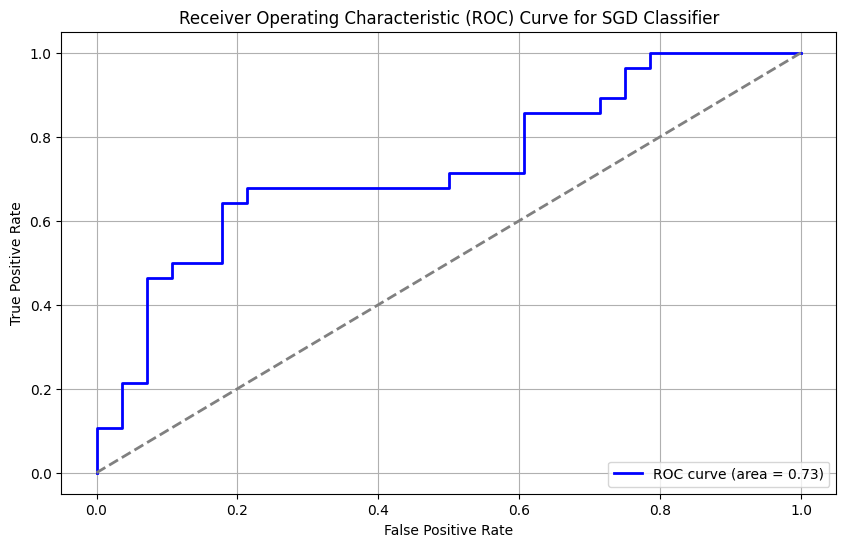

In [97]:
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

# Get the decision scores for the cross-validated predictions
y_scores_sgd_cv = cross_val_predict(sgd_clf, X, y_train, cv=5, method='decision_function')

# Calculate precision and recall values
precision_sgd, recall_sgd, thresholds_sgd = precision_recall_curve(y_train, y_scores_sgd_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_sgd, precision_sgd, marker='.', label='SGD Classifier (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SGD Classifier')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_sgd, tpr_sgd, roc_thresholds_sgd = roc_curve(y_train, y_scores_sgd_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgd, tpr_sgd, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_sgd:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SGD Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

SGD is an online algorithm so no need to use for this model, but wanted to test it out.

### Random Forest

In [98]:
# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_rf = cross_val_predict(rf_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")

Cross-Validated Precision: 0.5926
Cross-Validated Recall: 0.5714
Cross-Validated F1 Score: 0.5818


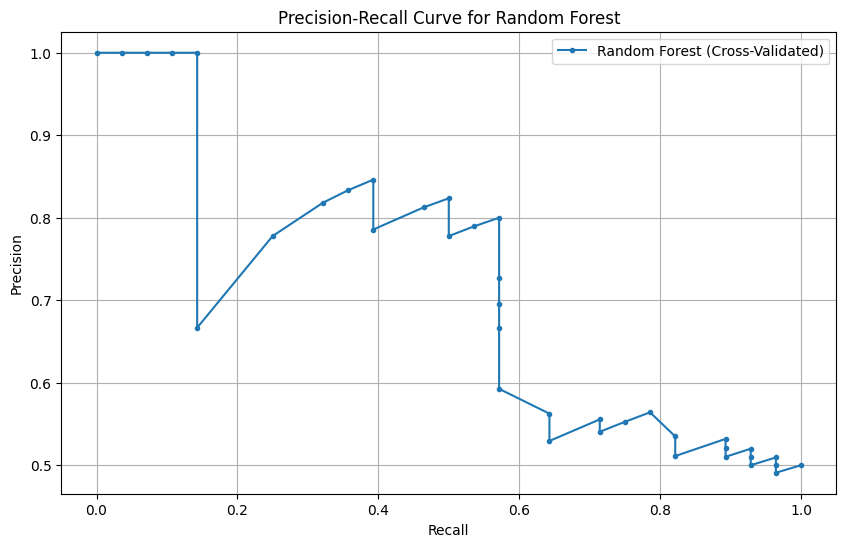

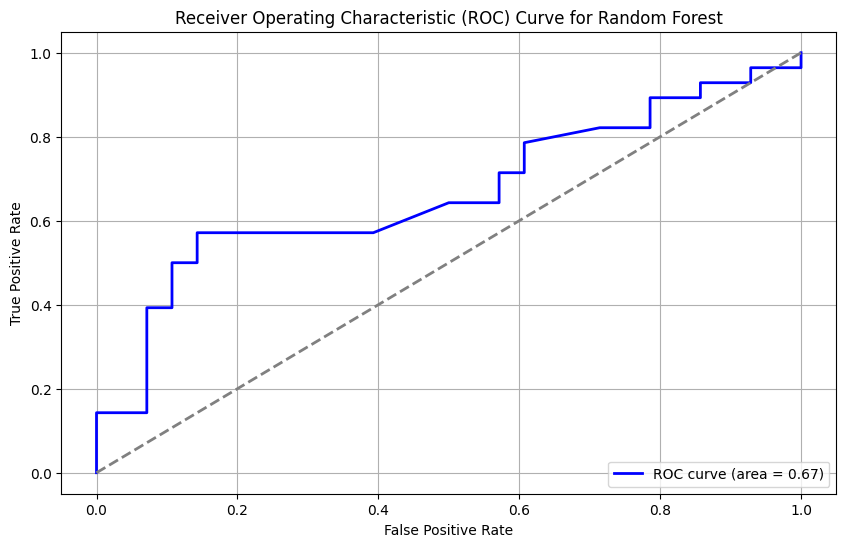

In [99]:
# Get the decision scores for the cross-validated predictions
y_scores_rf_cv = cross_val_predict(rf_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_train, y_scores_rf_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, marker='.', label='Random Forest (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rf, tpr_rf, roc_thresholds_rf = roc_curve(y_train, y_scores_rf_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Logistic Regression

In [100]:
# Create the LogisticRegression classifier
log_reg = LogisticRegression(random_state=42, max_iter=10000)

# Perform cross-validation predictions
y_train_pred_cv_log_reg = cross_val_predict(log_reg, X, y_train, cv=5)

# Calculate cross-validated scores
accuracy_cv_log_reg = accuracy_score(y_train, y_train_pred_cv_log_reg)
precision_cv_log_reg = precision_score(y_train, y_train_pred_cv_log_reg)
recall_cv_log_reg = recall_score(y_train, y_train_pred_cv_log_reg)
f1_cv_log_reg = f1_score(y_train, y_train_pred_cv_log_reg)

print(f"Cross-Validated Accuracy: {accuracy_cv_log_reg:.4f}")
print(f"Cross-Validated Precision: {precision_cv_log_reg:.4f}")
print(f"Cross-Validated Recall: {recall_cv_log_reg:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_log_reg:.4f}")

Cross-Validated Accuracy: 0.6607
Cross-Validated Precision: 0.6957
Cross-Validated Recall: 0.5714
Cross-Validated F1 Score: 0.6275


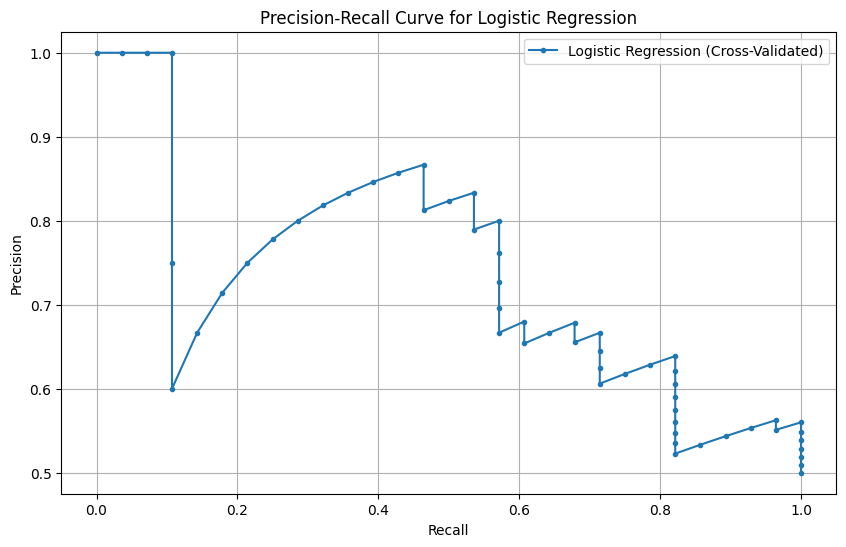

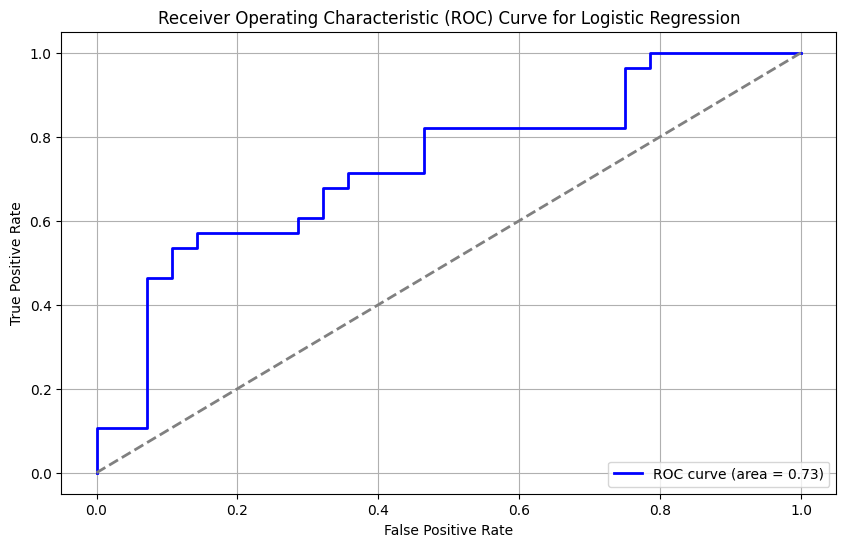

In [101]:
# Get the decision scores for the cross-validated predictions
y_scores_log_reg_cv = cross_val_predict(log_reg, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_log_reg, recall_log_reg, thresholds_log_reg = precision_recall_curve(y_train, y_scores_log_reg_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_log_reg, precision_log_reg, marker='.', label='Logistic Regression (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_log_reg, tpr_log_reg, roc_thresholds_log_reg = roc_curve(y_train, y_scores_log_reg_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### GradientBoostingClassifier

In [102]:
from sklearn.ensemble import GradientBoostingClassifier
# Create the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_gb = cross_val_predict(gb_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_gb = precision_score(y_train, y_train_pred_cv_gb)
recall_cv_gb = recall_score(y_train, y_train_pred_cv_gb)
f1_cv_gb = f1_score(y_train, y_train_pred_cv_gb)

print(f"Cross-Validated Precision: {precision_cv_gb:.4f}")
print(f"Cross-Validated Recall: {recall_cv_gb:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_gb:.4f}")

Cross-Validated Precision: 0.4615
Cross-Validated Recall: 0.4286
Cross-Validated F1 Score: 0.4444


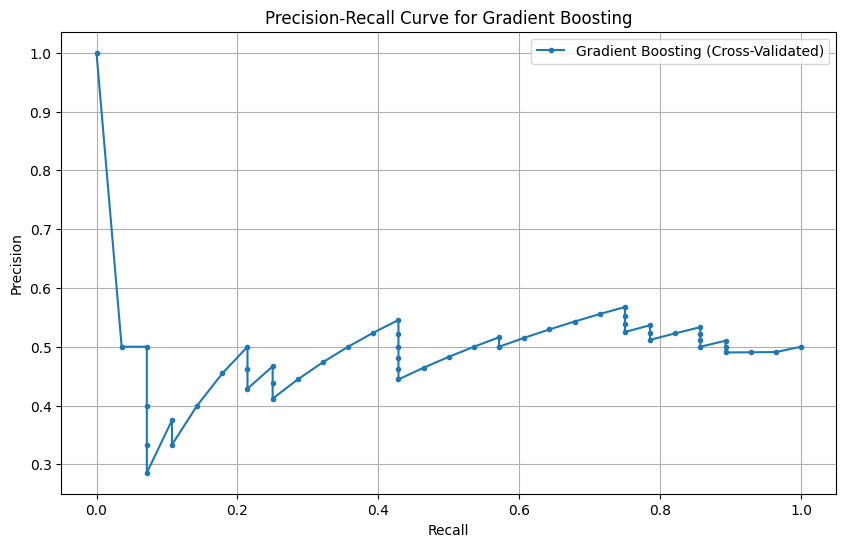

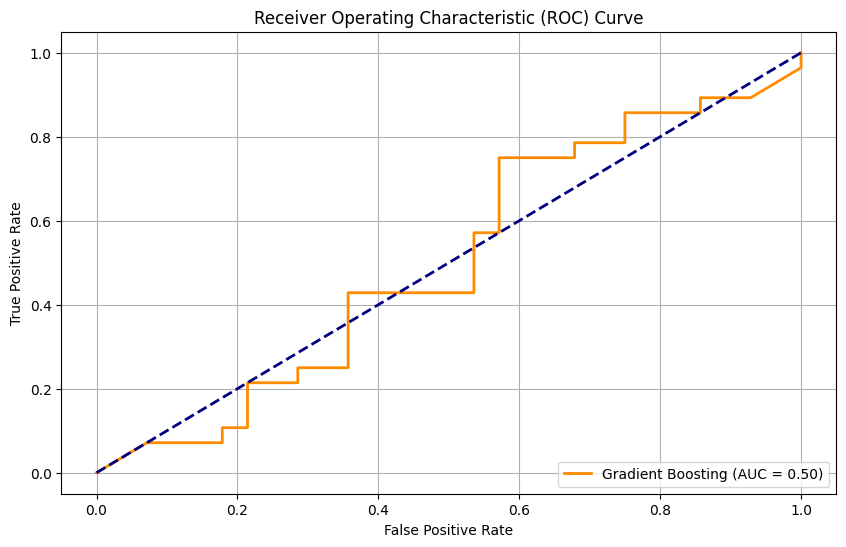

In [103]:
# Get the decision scores for the cross-validated predictions
y_scores_gb_cv = cross_val_predict(gb_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_train, y_scores_gb_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_gb, precision_gb, marker='.', label='Gradient Boosting (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_gb, tpr_gb, _ = roc_curve(y_train, y_scores_gb_cv)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### SVC Classifier

In [104]:
from sklearn.svm import SVC

# Create the SVC classifier
svc_clf = SVC(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_svc = cross_val_predict(svc_clf, X, y_train, cv=5)

# Calculate cross-validated scores
accuracy_cv_svc = accuracy_score(y_train, y_train_pred_cv_svc)
precision_cv_svc = precision_score(y_train, y_train_pred_cv_svc)
recall_cv_svc = recall_score(y_train, y_train_pred_cv_svc)
f1_cv_svc = f1_score(y_train, y_train_pred_cv_svc)

print(f"Cross-Validated Accuracy: {accuracy_cv_svc:.4f}")
print(f"Cross-Validated Precision: {precision_cv_svc:.4f}")
print(f"Cross-Validated Recall: {recall_cv_svc:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_svc:.4f}")

Cross-Validated Accuracy: 0.6964
Cross-Validated Precision: 0.6897
Cross-Validated Recall: 0.7143
Cross-Validated F1 Score: 0.7018


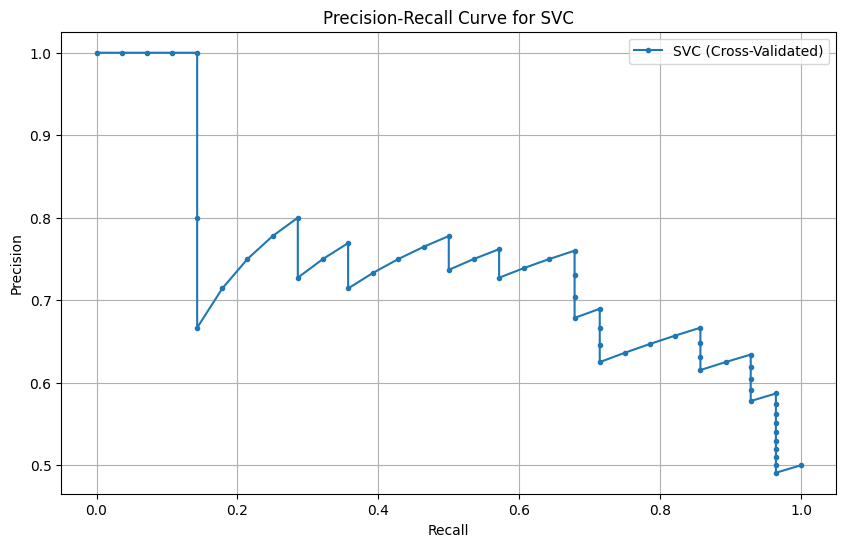

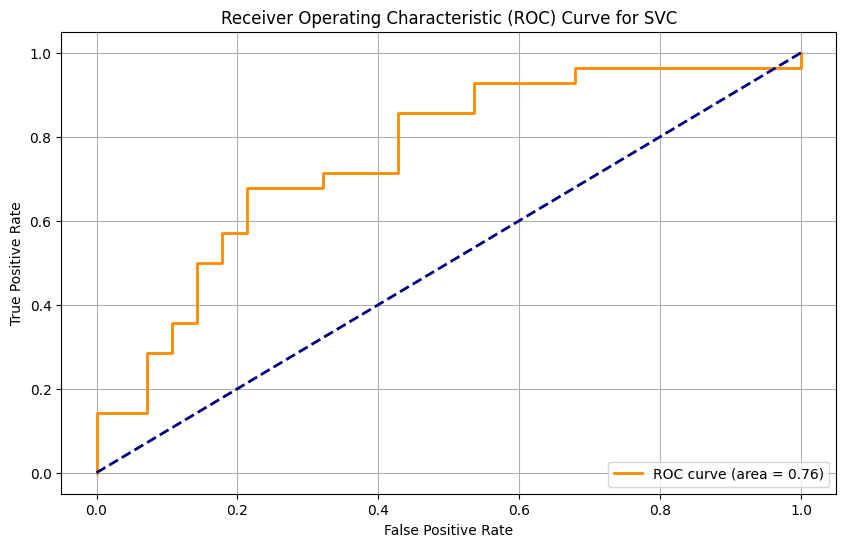

In [105]:
# Get the decision scores for the cross-validated predictions
y_scores_svc_cv = cross_val_predict(svc_clf, X, y_train, cv=5, method='decision_function')

# Calculate precision and recall values
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_train, y_scores_svc_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_svc, precision_svc, marker='.', label='SVC (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVC')
plt.legend()
plt.grid(True)
plt.show()

# Calculate ROC curve
fpr_svc, tpr_svc, _ = roc_curve(y_train, y_scores_svc_cv)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### LinearSVC

In [106]:
from sklearn.svm import LinearSVC

# Define the parameter grid for LinearSVC
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'max_iter': [1000, 7000, 15000, 30000],  # Maximum number of iterations
    'loss': ['hinge', 'squared_hinge'],  # Loss function
    'tol': [1e-3, 1e-4, 1e-5]  # Tolerance for stopping criteria
}

# Create the LinearSVC classifier
linear_svc = LinearSVC(random_state=42)

# Create the GridSearchCV object
grid_search_svc = GridSearchCV(linear_svc, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to the training data
grid_search_svc.fit(X, y_train)

# Get the best estimator
best_linear_svc = grid_search_svc.best_estimator_

# Perform cross-validation predictions
y_train_pred_cv_svc = cross_val_predict(best_linear_svc, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_svc = precision_score(y_train, y_train_pred_cv_svc)
recall_cv_svc = recall_score(y_train, y_train_pred_cv_svc)
f1_cv_svc = f1_score(y_train, y_train_pred_cv_svc)

print(f"Best Parameters: {grid_search_svc.best_params_}")
print(f"Cross-Validated Precision: {precision_cv_svc:.4f}")
print(f"Cross-Validated Recall: {recall_cv_svc:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_svc:.4f}")


Best Parameters: {'C': 10, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 0.001}
Cross-Validated Precision: 0.6667
Cross-Validated Recall: 0.7143
Cross-Validated F1 Score: 0.6897


/Users/missmerk/Documents/ML/P1-Early-Spring/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/missmerk/Documents/ML/P1-Early-Spring/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/missmerk/Documents/ML/P1-Early-Spring/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/missmerk/Documents/ML/P1-Early-Spring/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/missmerk/Documents/ML/P1-Early-Spring/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increas

Bad one

### Fine Tuning Random Forests

In [107]:
param_grid = {
    'n_estimators': [100, 300, 500],  # Reduced options for number of trees
    'max_depth': [None, 20, 50],  # Focusing on a few depth options
    'min_samples_split': [2, 10],  # Simplified range for splits
    'min_samples_leaf': [1, 4],  # Fewer choices for min samples per leaf
    'max_features': ['sqrt', 'log2'],  # Two commonly effective options
    'bootstrap': [True, False],  # Keeping both bootstrap options
    'class_weight': [None, 'balanced']  # Two key options for class weights
}

# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Define the scoring metric
scoring = make_scorer(roc_auc_score, needs_proba=True)

# Define StratifiedKFold with 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X, y_train)



Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 

/Users/missmerk/Documents/ML/P1-Early-Spring/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, class_weight=None, max_depth=None

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [None, 20, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 300, 500]},
             scoring=make_scorer(roc_auc_score, response_method='predict_proba'),
             verbose=2)

In [108]:
# Get the best estimator
best_rf_clf = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [109]:
rf_clf = RandomForestClassifier(bootstrap=True, max_depth=None, class_weight= 'balanced', max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42)

# Fit the model to the training data
rf_clf.fit(X, y_train)

# Perform cross-validation predictions
y_train_pred_cv_rf = cross_val_predict(rf_clf, X, y_train, cv=cv)

# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

#auc score
roc_auc_score_value = roc_auc_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")
print(f"Cross-Validated AUC Score: {roc_auc_score_value:.4f}")

Cross-Validated Precision: 0.7241
Cross-Validated Recall: 0.7500
Cross-Validated F1 Score: 0.7368
Cross-Validated AUC Score: 0.7321


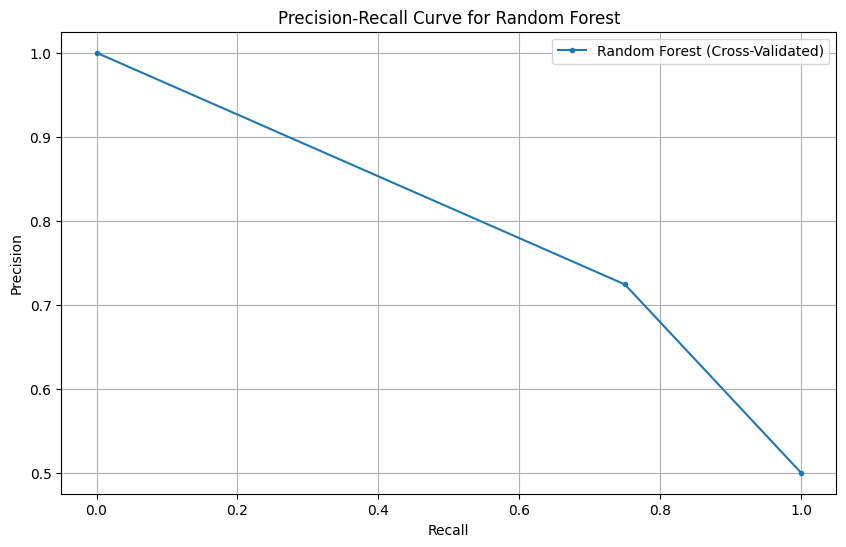

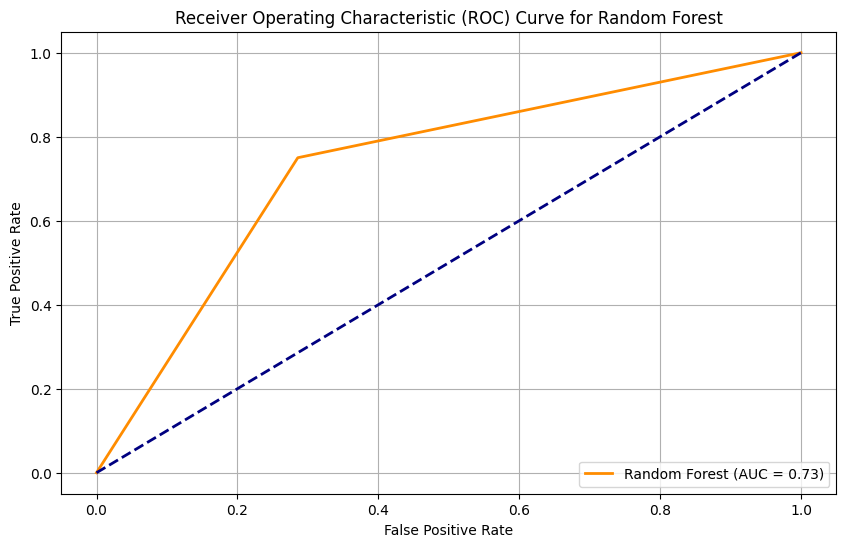

In [110]:
# Calculate precision and recall values
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_train, y_train_pred_cv_rf)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, marker='.', label='Random Forest (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_train_pred_cv_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Models Analysis
We ran through 8 models (one was online, not useful so really 7).
We chose the models for fine tuning based on the f1score as to see the recall and precision trade off. 

These two models were the best:
- LinearSVC (as it had the highest cross val f1 score out of the 8 models)
- RandomForest 

Random Forest had a low cross val score, but because of its many hyperparameters compared to other models, made it a good candidate for fine tuning. 


### Scoring 
Out of the two fine tuned models, Random Forest came out on top with a f1 score of `.72` while LinearSVC had a score of `.69` which wasn't much of a difference from it's original score.

We also based our scoring from the recall as well, where Random Forest still came out on top with a recall score of `.75`. We would much rather make a wrong `early spring` predicition than a wrong `late winter` prediction, as per the business goal. 

In [111]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred_cv_rf)

# Create a DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Display the confusion matrix
conf_matrix_df

Predicted Negative  Predicted Positive
Actual Negative                  20                   8
Actual Positive                   7                  21

Presentation Summary
=========

In this project we were tasked with creating a model to predict an early spring or late winter. Doing this would benefit Western PA farmers because they would be able to determine whether to buy the extra seeds for the year, which saves on costs and if it is a early spring it could make them more money. 

We found it important for this task to get extra data to better predict an early spring. In this case, we ended up getting El Nino dataset. The correlation with early spring are shown below.

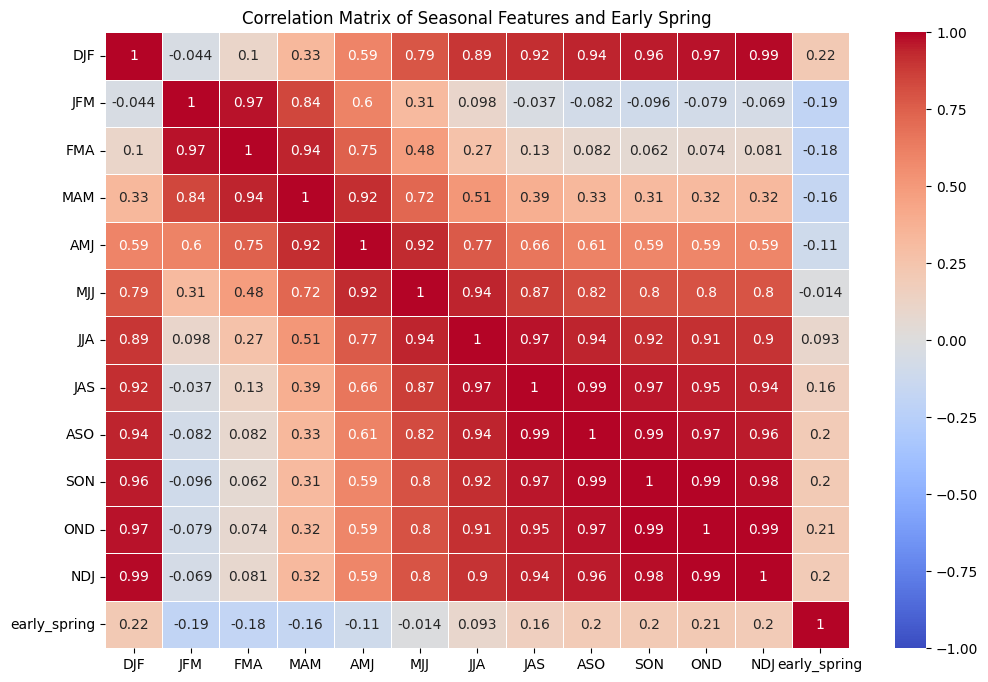

In [112]:
# Display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_seasonal, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Seasonal Features and Early Spring')
plt.show()

### Days to Weeks
During our data visualization step, we could not find very direct and obvious patterns between the days and early spring. However, when breaking it down to weeks rather than days, we could see some correlations with Early Spring variable for most of our weeks. This not only helped with correlations, but it also helped with decreasing the amount of features which helped with convenience. For example, the correlation with the Minimum Soil Temperature per week and Early Spring as seen below:

<Axes: >

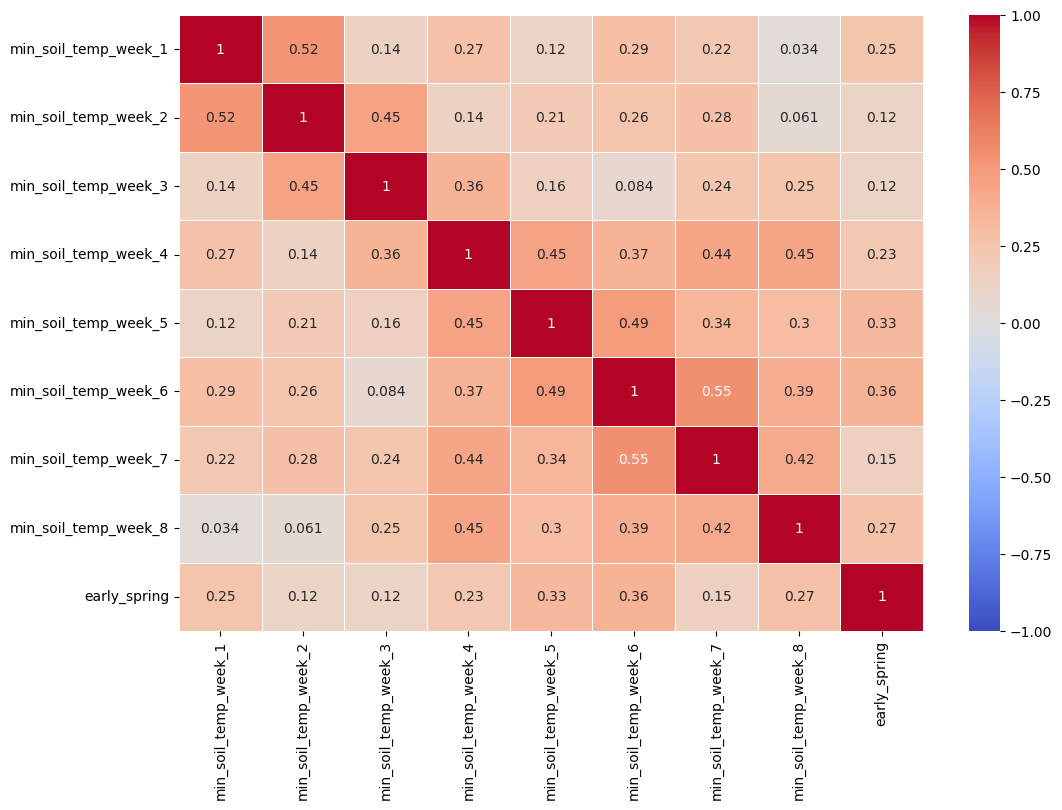

In [113]:
# Display the correlation matrix
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_weeks_min_soil_temp, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

### Pipeline
In the pipeline, there was not much to do becasue all of our data was numerical. Therefore, we only had to do 5 steps:

1. Impute by the mean. Most of our data was Normally Distributed, so it was the obvious option. Even the points that could be labaled as outliers are not so far that they would affect the mean by a great amount.
2. Break down our features into weeks instead of days.
3. Found the delta of weeks and added to the dataset.
4. Scaled our data using standard scalar. Most of our data is normally distributed, so this was the obvious option.
5. Ran a RandomForest Classifier in the pipeline to remove useless features. 

### Final Model

Our final model ended up being a Random Forest Classifier. As seen from the confusion matrix below, our model is able to predict with True Positive = `21` and True Negatives = `20` out of the `56` samples that is was given. While picking our final model we decided to favor recall because as per the farmers' request, it is better to predict a false early spring rather than a false late winter. When our model is an early spring it will predict it 75% of the time. Compared to the ground hog, which the farmers previously relied on to predict an early spring, our model is significantly better. (Sorry Phil...)

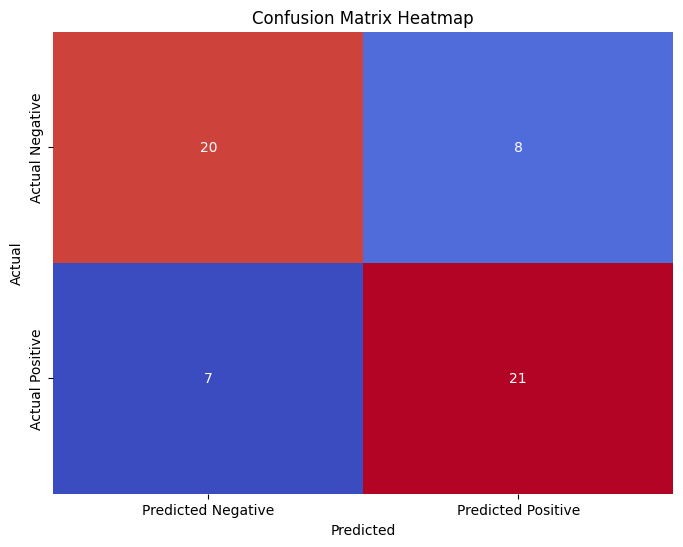

In [114]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [115]:
import pickle

# Save the preprocessor fit data to a pickle file
with open('preprocessor_fit_data.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [116]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)

## Notes are written at bottom of every section that go into more detail than the summary which only covered high level points.